In [1]:
%matplotlib inline
from fastai import *
from fastai.text import *
from fastai.callbacks import *

In [2]:
import numpy as np
from pathlib import Path
import os
import torch.optim as optim
import random

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

# our models of choice
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

In [3]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)
print(f'GPU is available: {torch.cuda.is_available()}')
device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")

fastai version : 1.0.59
transformers version : 2.3.0
GPU is available: True


In [4]:
import argparse
import glob
import json
import logging
import os
import random

import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from transformers import (
    WEIGHTS_NAME,
    AdamW,
    AlbertConfig,
    AlbertForSequenceClassification,
    AlbertTokenizer,
    BertConfig,
    BertForSequenceClassification,
    BertTokenizer,
    DistilBertConfig,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    RobertaConfig,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    XLMConfig,
    XLMForSequenceClassification,
    XLMRobertaConfig,
    XLMRobertaForSequenceClassification,
    XLMRobertaTokenizer,
    XLMTokenizer,
    XLNetConfig,
    XLNetForSequenceClassification,
    XLNetTokenizer,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup
)
from transformers import glue_compute_metrics as compute_metrics
from transformers import glue_convert_examples_to_features as convert_examples_to_features
from transformers import glue_output_modes as output_modes
from transformers import glue_processors as processors

In [5]:
seed = 42
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
seed_all(seed)

## Prepare the full IMDB dataset and inspect the files under that path

In [6]:
path = untar_data(URLs.IMDB)
path

PosixPath('/home/projectx/.fastai/data/imdb')

In [7]:
path.ls()

[PosixPath('/home/projectx/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/projectx/.fastai/data/imdb/models'),
 PosixPath('/home/projectx/.fastai/data/imdb/lm_databunch_RoBERTa'),
 PosixPath('/home/projectx/.fastai/data/imdb/test'),
 PosixPath('/home/projectx/.fastai/data/imdb/data_bunch_classification'),
 PosixPath('/home/projectx/.fastai/data/imdb/imdb_textlist_classifier'),
 PosixPath('/home/projectx/.fastai/data/imdb/fine_tuning_LM'),
 PosixPath('/home/projectx/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/projectx/.fastai/data/imdb/train'),
 PosixPath('/home/projectx/.fastai/data/imdb/lm_databunch'),
 PosixPath('/home/projectx/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/projectx/.fastai/data/imdb/README'),
 PosixPath('/home/projectx/.fastai/data/imdb/unsup')]

In [8]:
(path/'train').ls()

[PosixPath('/home/projectx/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/pos'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/neg')]

In [9]:
(path/'test').ls()

[PosixPath('/home/projectx/.fastai/data/imdb/test/pos'),
 PosixPath('/home/projectx/.fastai/data/imdb/test/labeledBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/test/neg')]

In [10]:
import glob

def text_label_pairs_from_folder(path, folders):
    text_label_pairs = [['sentence', 'label']]
    
    for idx, label in enumerate(folders):
        for fname in glob.glob(os.path.join(path, label, '*.*')):
            text_label_pairs.append(list([open(fname,'r').read(), str(idx)]))
    return text_label_pairs

In [11]:
trainpath = Path(path/'train')
testpath  = Path(path/'test')
train_IMDb = text_label_pairs_from_folder(trainpath, ['pos','neg'])
test_IMDb  = text_label_pairs_from_folder(testpath, ['pos','neg'])

In [12]:
len(train_IMDb), len(test_IMDb)

(25001, 25001)

In [13]:
class InputExample(object):
    """
    A single training/test example for simple sequence classification.

    Args:
        guid: Unique id for the example.
        text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
        text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
        label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """

    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

In [14]:
def _create_examples(lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[0]
            label = line[1]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

In [15]:
example_IMDb_train = _create_examples(train_IMDb, 'train')
example_IMDb_test  = _create_examples(test_IMDb, 'test')

In [16]:
AlbertForSequenceClassification.pretrained_model_archive_map.keys()

dict_keys(['albert-base-v1', 'albert-large-v1', 'albert-xlarge-v1', 'albert-xxlarge-v1', 'albert-base-v2', 'albert-large-v2', 'albert-xlarge-v2', 'albert-xxlarge-v2'])

In [17]:
pretrained_model_name = 'albert-large-v2'
tokenizer = AlbertTokenizer.from_pretrained(pretrained_model_name)

In [18]:
features_IMDb_train = convert_examples_to_features(
                        example_IMDb_train,
                        tokenizer,
                        label_list=['0','1'],
                        max_length= 512,    # the maximum total input sequence length after tokenization.
                                            # Sequences longer than this will be truncated, shorter will be padded
                        output_mode="classification",
                        pad_on_left=bool('ALBERT' in ["xlnet"]),  # pad on the left for xlnet
                        pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                        pad_token_segment_id=4 if 'ALBERT' in ["xlnet"] else 0,
                        )

In [19]:
features_IMDb_test = convert_examples_to_features(
                        example_IMDb_test,
                        tokenizer,
                        label_list=['0','1'],
                        max_length= 512,    # the maximum total input sequence length after tokenization.
                                            # Sequences longer than this will be truncated, shorter will be padded
                        output_mode="classification",
                        pad_on_left=bool('ALBERT' in ["xlnet"]),  # pad on the left for xlnet
                        pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                        pad_token_segment_id=4 if 'ALBERT' in ["xlnet"] else 0,
                        )

In [20]:
# Convert to Tensors and build dataset

# for train
features = features_IMDb_train

all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
all_labels = torch.tensor([f.label for f in features], dtype=torch.long)

# create train_dataset
dataset_IMDb_train = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)

In [21]:
# Convert to Tensors and build dataset

# for test
features = features_IMDb_test

all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
all_labels = torch.tensor([f.label for f in features], dtype=torch.long)

# create train_dataset
dataset_IMDb_test = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)

In [22]:
len(dataset_IMDb_train), len(dataset_IMDb_test)

(25000, 25000)

### Transformers model Zoo
Create a dictionary of parameters required for creating different model classes

In [23]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig),
    'albert': (AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig)
}

In [24]:
model_class, tokenizer_class, config_class = MODEL_CLASSES['albert']

In [25]:
pretrained_model_name

'albert-large-v2'

In [26]:
# Create pretrained model 
config = config_class.from_pretrained(pretrained_model_name, num_labels = 2)

model = model_class.from_pretrained(pretrained_model_name, config = config)

In [27]:
model.to(device);

## Train loop

In [28]:
class args_for_training():
    def __init__(self):
        
        # general parameters
        self.train_batch_size   = 4
        self.eval_batch_size    = 4
        self.max_steps          = -1  # set to -1 if we define the training duration by num_epochs
        self.gradient_accumulation_steps = 1  # update for each batch we take in
        self.num_train_epochs   = 10
        self.device = device
        self.model_type         = 'albert'
        self.logging_steps      = 4000
        self.save_steps         = 4000
        self.local_rank         = -1
        self.output_dir = os.path.join(os.getcwd(),'ALBERT')
        self.evaluate_during_training = True
        self.task_name          = "sst-2"  # this is used to determine evaluation metric (we use simple accuracy)
        self.output_mode        = "classification"
        
        
        # optimizer parameters
        self.weight_decay  = 0.0
        self.learning_rate = 2e-5
        self.adam_epsilon  = 1e-8
        self.warmup_steps  = 4000
        self.model_name_or_path = pretrained_model_name
        self.max_grad_norm = 1.0
        
args = args_for_training()

In [29]:
def train(args, train_dataset, model, tokenizer):
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()
   
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)

    t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, num_warmup_steps=int(t_total*0.3), num_training_steps=t_total
    )
#     scheduler =  get get_linear_schedule_with_warmup(
#         optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
#     )

    # Check if saved optimizer or scheduler states exist
    if os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt")) and os.path.isfile(
        os.path.join(args.model_name_or_path, "scheduler.pt")
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))


    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if os.path.exists(args.model_name_or_path):
        # set global_step to gobal_step of last saved checkpoint from model path
        global_step = int(args.model_name_or_path.split("-")[-1].split("/")[0])
        epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
        steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)


    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=False,
    )

    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=False)
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            model.train()
            batch = tuple(t.to(args.device) for t in batch)
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            if args.model_type != "distilbert":
                inputs["token_type_ids"] = (
                    batch[2] if args.model_type in ["bert", "xlnet", "albert"] else None
                )  # XLM, DistilBERT, RoBERTa, and XLM-RoBERTa don't use segment_ids
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps
            
            loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

                optimizer.step() 
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    logs = {}
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results, accuracies = evaluate(args,train_dataset, model, tokenizer)
                        for key, value in results.items():
                            eval_key = "eval_{}".format(key)
                            logs[eval_key] = value

                    loss_scalar = (tr_loss - logging_loss) / args.logging_steps
                    learning_rate_scalar = scheduler.get_lr()[0]
                    logs["learning_rate"] = learning_rate_scalar
                    logs["loss"] = loss_scalar
                    logging_loss = tr_loss

                    for key, value in logs.items():
                        tb_writer.add_scalar(key, value, global_step)
                    print(json.dumps({**logs, **{"step": global_step}}))

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "checkpoint-{}".format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step, accuracies

In [30]:
def simple_accuracy(preds, labels):
    
    return {"acc": (preds == labels).mean()}

In [31]:
def evaluate(args,dataset, model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_task_names = "sst-2"
    eval_outputs_dirs = (args.output_dir, args.output_dir + "-MM") if args.task_name == "mnli" else (args.output_dir,)

    results = {}
    accuracies = []
    for eval_task, eval_output_dir in zip(eval_task_names, eval_outputs_dirs):
        eval_dataset = dataset_IMDb_test

        if not os.path.exists(eval_output_dir) and args.local_rank in [-1, 0]:
            os.makedirs(eval_output_dir)

        
        # Note that DistributedSampler samples randomly
        eval_sampler = SequentialSampler(dataset)
        eval_dataloader = DataLoader(dataset, sampler=eval_sampler, batch_size=args.train_batch_size)

        
        # Eval!
        
        eval_loss = 0.0
        nb_eval_steps = 0
        preds = None
        out_label_ids = None
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            model.eval()
            batch = tuple(t.to(args.device) for t in batch)

            with torch.no_grad():
                inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
                if args.model_type != "distilbert":
                    inputs["token_type_ids"] = (
                        batch[2] if args.model_type in ["bert", "xlnet", "albert"] else None
                    )  # XLM, DistilBERT, RoBERTa, and XLM-RoBERTa don't use segment_ids
                outputs = model(**inputs)
                tmp_eval_loss, logits = outputs[:2]

                eval_loss += tmp_eval_loss.mean().item()
            nb_eval_steps += 1
            if preds is None:
                preds = logits.detach().cpu().numpy()
                out_label_ids = inputs["labels"].detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

        eval_loss = eval_loss / nb_eval_steps
        if args.output_mode == "classification":
            preds = np.argmax(preds, axis=1)
        elif args.output_mode == "regression":
            preds = np.squeeze(preds)
        result = simple_accuracy(preds, out_label_ids)
        results.update(result)
        accuracies.append(result['acc'])

        output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
        with open(output_eval_file, "w") as writer:
            logger.info("***** Eval results {} *****".format(prefix))
            for key in sorted(result.keys()):
                logger.info("  %s = %s", key, str(result[key]))
                writer.write("%s = %s\n" % (key, str(result[key])))

    return results, accuracies

In [32]:
logger = logging.getLogger(__name__)

In [ ]:
global_step, tr_loss, accuracies = train(args, dataset_IMDb_train, model, tokenizer)
logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

Iteration:   2%|▏         | 122/6250 [01:29<1:15:25,  1.35it/s]


Iteration:   4%|▍         | 244/6250 [03:00<1:17:48,  1.29it/s]


Iteration:   6%|▌         | 366/6250 [04:35<1:15:45,  1.29it/s]


Iteration:   8%|▊         | 488/6250 [06:10<1:17:37,  1.24it/s]


Iteration:  10%|▉         | 610/6250 [07:45<1:14:11,  1.27it/s]


Iteration:  12%|█▏        | 732/6250 [09:21<1:11:34,  1.28it/s]


Iteration:  14%|█▎        | 854/6250 [10:56<1:10:47,  1.27it/s]


Iteration:  16%|█▌        | 976/6250 [12:33<1:11:53,  1.22it/s]


Iteration:  18%|█▊        | 1096/6250 [14:07<1:06:17,  1.30it/s]


Iteration:  19%|█▉        | 1216/6250 [15:42<1:06:44,  1.26it/s]


Iteration:  21%|██▏       | 1336/6250 [17:16<1:03:11,  1.30it/s]


Iteration:  23%|██▎       | 1456/6250 [18:50<1:04:04,  1.25it/s]


Iteration:  25%|██▌       | 1577/6250 [20:25<59:31,  1.31it/s]


Iteration:  27%|██▋       | 1698/6250 [22:00<57:28,  1.32it/s]


Iteration:  29%|██▉       | 1821/6250 [23:37<59:23,  1.24it/s]


Iteration:  31%|███       | 1945/6250 [25:15<57:41,  1.24it/s]


Iteration:  33%|███▎      | 2069/6250 [26:52<55:12,  1.26it/s]


Iteration:  35%|███▌      | 2193/6250 [28:30<54:36,  1.24it/s]


Iteration:  37%|███▋      | 2317/6250 [30:07<50:29,  1.30it/s]


Iteration:  39%|███▉      | 2441/6250 [31:45<48:51,  1.30it/s]


Iteration:  41%|████      | 2565/6250 [33:22<49:25,  1.24it/s]


Iteration:  43%|████▎     | 2689/6250 [35:00<46:31,  1.28it/s]


Iteration:  45%|████▌     | 2813/6250 [36:37<46:10,  1.24it/s]


Iteration:  47%|████▋     | 2937/6250 [38:14<43:45,  1.26it/s]


Iteration:  49%|████▉     | 3061/6250 [39:51<42:27,  1.25it/s]


Iteration:  51%|█████     | 3185/6250 [41:29<40:57,  1.25it/s]


Iteration:  53%|█████▎    | 3309/6250 [43:06<38:42,  1.27it/s]


Iteration:  55%|█████▍    | 3433/6250 [44:43<36:33,  1.28it/s]


Iteration:  57%|█████▋    | 3557/6250 [46:20<35:01,  1.28it/s]


Iteration:  59%|█████▉    | 3681/6250 [47:57<33:50,  1.27it/s]


Iteration:  61%|██████    | 3805/6250 [49:35<32:22,  1.26it/s]


Iteration:  63%|██████▎   | 3929/6250 [51:13<29:31,  1.31it/s]


Iteration:  64%|██████▍   | 3999/6250 [52:07<29:41,  1.26it/s]

Evaluating:   0%|          | 0/6250 [00:00<?, ?it/s]

Evaluating:   0%|          | 1/6250 [00:00<28:08,  3.70it/s]

Evaluating:   0%|          | 2/6250 [00:00<28:10,  3.70it/s]

Evaluating:   0%|          | 3/6250 [00:00<28:17,  3.68it/s]

Evaluating:   0%|          | 4/6250 [00:01<28:25,  3.66it/s]

Evaluating:   0%|          | 5/6250 [00:01<28:32,  3.65it/s]

Evaluating:   0%|          | 6/6250 [00:01<28:39,  3.63it/s]

Evaluating:   0%|          | 7/6250 [00:01<28:52,  3.60it/s]

Evaluating:   0%|          | 8/6250 [00:02<28:53,  3.60it/s]

Evaluating:   0%|          | 9/6250 [00:02<29:00,  3.58it/s]

Evaluating:   0%|          | 10/6250 [00:02<29:09,  3.57it/s]

Evaluating:   0%|          | 11/6250 [00:03<29:18,  3.55it/s]

Evaluating:   0%|          | 12/6250 [00:03<29:21,  3.54it/s]

Evaluating:   0%|          | 13/6250 [00:03<29:28,  3.53it/s]

Evaluating:   0%|          | 14/6250 [00:03<29:33,  3.52it/s]

Evaluatin

Evaluating:   1%|          | 52/6250 [00:15<30:28,  3.39it/s]

Evaluating:   1%|          | 53/6250 [00:15<30:28,  3.39it/s]

Evaluating:   1%|          | 54/6250 [00:15<30:27,  3.39it/s]

Evaluating:   1%|          | 55/6250 [00:15<30:27,  3.39it/s]

Evaluating:   1%|          | 56/6250 [00:16<30:27,  3.39it/s]

Evaluating:   1%|          | 57/6250 [00:16<30:25,  3.39it/s]

Evaluating:   1%|          | 58/6250 [00:16<30:26,  3.39it/s]

Evaluating:   1%|          | 59/6250 [00:17<30:25,  3.39it/s]

Evaluating:   1%|          | 60/6250 [00:17<30:25,  3.39it/s]

Evaluating:   1%|          | 61/6250 [00:17<30:21,  3.40it/s]

Evaluating:   1%|          | 62/6250 [00:18<30:23,  3.39it/s]

Evaluating:   1%|          | 63/6250 [00:18<30:22,  3.39it/s]

Evaluating:   1%|          | 64/6250 [00:18<30:22,  3.39it/s]

Evaluating:   1%|          | 65/6250 [00:18<30:21,  3.39it/s]

Evaluating:   1%|          | 66/6250 [00:19<30:21,  3.40it/s]

Evaluating:   1%|          | 67/6250 [00:19<30:22,  3.3

Evaluating:   3%|▎         | 169/6250 [00:49<29:37,  3.42it/s]

Evaluating:   3%|▎         | 170/6250 [00:49<29:42,  3.41it/s]

Evaluating:   3%|▎         | 171/6250 [00:50<29:42,  3.41it/s]

Evaluating:   3%|▎         | 172/6250 [00:50<29:36,  3.42it/s]

Evaluating:   3%|▎         | 173/6250 [00:50<29:28,  3.44it/s]

Evaluating:   3%|▎         | 174/6250 [00:50<29:24,  3.44it/s]

Evaluating:   3%|▎         | 175/6250 [00:51<29:20,  3.45it/s]

Evaluating:   3%|▎         | 176/6250 [00:51<29:18,  3.45it/s]

Evaluating:   3%|▎         | 177/6250 [00:51<29:16,  3.46it/s]

Evaluating:   3%|▎         | 178/6250 [00:52<29:12,  3.47it/s]

Evaluating:   3%|▎         | 179/6250 [00:52<29:13,  3.46it/s]

Evaluating:   3%|▎         | 180/6250 [00:52<29:09,  3.47it/s]

Evaluating:   3%|▎         | 181/6250 [00:52<29:10,  3.47it/s]

Evaluating:   3%|▎         | 182/6250 [00:53<29:05,  3.48it/s]

Evaluating:   3%|▎         | 183/6250 [00:53<29:01,  3.48it/s]

Evaluating:   3%|▎         | 184/6250 [0

Evaluating:   5%|▍         | 286/6250 [01:23<28:51,  3.45it/s]

Evaluating:   5%|▍         | 287/6250 [01:23<28:44,  3.46it/s]

Evaluating:   5%|▍         | 288/6250 [01:24<28:34,  3.48it/s]

Evaluating:   5%|▍         | 289/6250 [01:24<28:21,  3.50it/s]

Evaluating:   5%|▍         | 290/6250 [01:24<28:08,  3.53it/s]

Evaluating:   5%|▍         | 291/6250 [01:25<27:59,  3.55it/s]

Evaluating:   5%|▍         | 292/6250 [01:25<27:55,  3.55it/s]

Evaluating:   5%|▍         | 293/6250 [01:25<27:56,  3.55it/s]

Evaluating:   5%|▍         | 294/6250 [01:25<28:00,  3.54it/s]

Evaluating:   5%|▍         | 295/6250 [01:26<28:06,  3.53it/s]

Evaluating:   5%|▍         | 296/6250 [01:26<28:07,  3.53it/s]

Evaluating:   5%|▍         | 297/6250 [01:26<28:10,  3.52it/s]

Evaluating:   5%|▍         | 298/6250 [01:27<28:24,  3.49it/s]

Evaluating:   5%|▍         | 299/6250 [01:27<28:21,  3.50it/s]

Evaluating:   5%|▍         | 300/6250 [01:27<28:21,  3.50it/s]

Evaluating:   5%|▍         | 301/6250 [0

Evaluating:   6%|▋         | 403/6250 [01:57<28:44,  3.39it/s]

Evaluating:   6%|▋         | 404/6250 [01:58<28:47,  3.38it/s]

Evaluating:   6%|▋         | 405/6250 [01:58<28:46,  3.39it/s]

Evaluating:   6%|▋         | 406/6250 [01:58<28:42,  3.39it/s]

Evaluating:   7%|▋         | 407/6250 [01:58<28:38,  3.40it/s]

Evaluating:   7%|▋         | 408/6250 [01:59<28:40,  3.40it/s]

Evaluating:   7%|▋         | 409/6250 [01:59<28:36,  3.40it/s]

Evaluating:   7%|▋         | 410/6250 [01:59<28:34,  3.41it/s]

Evaluating:   7%|▋         | 411/6250 [02:00<28:33,  3.41it/s]

Evaluating:   7%|▋         | 412/6250 [02:00<28:34,  3.40it/s]

Evaluating:   7%|▋         | 413/6250 [02:00<28:36,  3.40it/s]

Evaluating:   7%|▋         | 414/6250 [02:01<28:38,  3.40it/s]

Evaluating:   7%|▋         | 415/6250 [02:01<28:39,  3.39it/s]

Evaluating:   7%|▋         | 416/6250 [02:01<28:39,  3.39it/s]

Evaluating:   7%|▋         | 417/6250 [02:01<28:36,  3.40it/s]

Evaluating:   7%|▋         | 418/6250 [0

Evaluating:   8%|▊         | 520/6250 [02:32<27:56,  3.42it/s]

Evaluating:   8%|▊         | 521/6250 [02:32<27:56,  3.42it/s]

Evaluating:   8%|▊         | 522/6250 [02:32<27:49,  3.43it/s]

Evaluating:   8%|▊         | 523/6250 [02:32<27:48,  3.43it/s]

Evaluating:   8%|▊         | 524/6250 [02:33<27:45,  3.44it/s]

Evaluating:   8%|▊         | 525/6250 [02:33<27:43,  3.44it/s]

Evaluating:   8%|▊         | 526/6250 [02:33<27:43,  3.44it/s]

Evaluating:   8%|▊         | 527/6250 [02:34<27:46,  3.43it/s]

Evaluating:   8%|▊         | 528/6250 [02:34<27:51,  3.42it/s]

Evaluating:   8%|▊         | 529/6250 [02:34<28:06,  3.39it/s]

Evaluating:   8%|▊         | 530/6250 [02:35<28:07,  3.39it/s]

Evaluating:   8%|▊         | 531/6250 [02:35<28:08,  3.39it/s]

Evaluating:   9%|▊         | 532/6250 [02:35<28:07,  3.39it/s]

Evaluating:   9%|▊         | 533/6250 [02:35<28:10,  3.38it/s]

Evaluating:   9%|▊         | 534/6250 [02:36<28:08,  3.39it/s]

Evaluating:   9%|▊         | 535/6250 [0

Evaluating:  10%|█         | 637/6250 [03:06<27:25,  3.41it/s]

Evaluating:  10%|█         | 638/6250 [03:06<27:40,  3.38it/s]

Evaluating:  10%|█         | 639/6250 [03:06<27:36,  3.39it/s]

Evaluating:  10%|█         | 640/6250 [03:07<27:36,  3.39it/s]

Evaluating:  10%|█         | 641/6250 [03:07<27:32,  3.39it/s]

Evaluating:  10%|█         | 642/6250 [03:07<27:29,  3.40it/s]

Evaluating:  10%|█         | 643/6250 [03:08<27:31,  3.40it/s]

Evaluating:  10%|█         | 644/6250 [03:08<27:31,  3.39it/s]

Evaluating:  10%|█         | 645/6250 [03:08<27:37,  3.38it/s]

Evaluating:  10%|█         | 646/6250 [03:09<27:38,  3.38it/s]

Evaluating:  10%|█         | 647/6250 [03:09<27:36,  3.38it/s]

Evaluating:  10%|█         | 648/6250 [03:09<27:36,  3.38it/s]

Evaluating:  10%|█         | 649/6250 [03:09<27:35,  3.38it/s]

Evaluating:  10%|█         | 650/6250 [03:10<27:37,  3.38it/s]

Evaluating:  10%|█         | 651/6250 [03:10<27:35,  3.38it/s]

Evaluating:  10%|█         | 652/6250 [0

Evaluating:  12%|█▏        | 754/6250 [03:40<27:05,  3.38it/s]

Evaluating:  12%|█▏        | 755/6250 [03:41<27:03,  3.39it/s]

Evaluating:  12%|█▏        | 756/6250 [03:41<27:02,  3.39it/s]

Evaluating:  12%|█▏        | 757/6250 [03:41<27:02,  3.39it/s]

Evaluating:  12%|█▏        | 758/6250 [03:42<27:02,  3.39it/s]

Evaluating:  12%|█▏        | 759/6250 [03:42<27:01,  3.39it/s]

Evaluating:  12%|█▏        | 760/6250 [03:42<27:10,  3.37it/s]

Evaluating:  12%|█▏        | 761/6250 [03:43<27:06,  3.37it/s]

Evaluating:  12%|█▏        | 762/6250 [03:43<27:05,  3.38it/s]

Evaluating:  12%|█▏        | 763/6250 [03:43<27:03,  3.38it/s]

Evaluating:  12%|█▏        | 764/6250 [03:43<27:02,  3.38it/s]

Evaluating:  12%|█▏        | 765/6250 [03:44<27:00,  3.38it/s]

Evaluating:  12%|█▏        | 766/6250 [03:44<26:59,  3.39it/s]

Evaluating:  12%|█▏        | 767/6250 [03:44<26:57,  3.39it/s]

Evaluating:  12%|█▏        | 768/6250 [03:45<26:53,  3.40it/s]

Evaluating:  12%|█▏        | 769/6250 [0

Evaluating:  14%|█▍        | 871/6250 [04:15<26:25,  3.39it/s]

Evaluating:  14%|█▍        | 872/6250 [04:15<26:24,  3.39it/s]

Evaluating:  14%|█▍        | 873/6250 [04:15<26:24,  3.39it/s]

Evaluating:  14%|█▍        | 874/6250 [04:16<26:25,  3.39it/s]

Evaluating:  14%|█▍        | 875/6250 [04:16<26:25,  3.39it/s]

Evaluating:  14%|█▍        | 876/6250 [04:16<26:24,  3.39it/s]

Evaluating:  14%|█▍        | 877/6250 [04:17<26:24,  3.39it/s]

Evaluating:  14%|█▍        | 878/6250 [04:17<26:22,  3.39it/s]

Evaluating:  14%|█▍        | 879/6250 [04:17<26:23,  3.39it/s]

Evaluating:  14%|█▍        | 880/6250 [04:18<26:21,  3.40it/s]

Evaluating:  14%|█▍        | 881/6250 [04:18<26:18,  3.40it/s]

Evaluating:  14%|█▍        | 882/6250 [04:18<26:20,  3.40it/s]

Evaluating:  14%|█▍        | 883/6250 [04:18<26:20,  3.39it/s]

Evaluating:  14%|█▍        | 884/6250 [04:19<26:21,  3.39it/s]

Evaluating:  14%|█▍        | 885/6250 [04:19<26:19,  3.40it/s]

Evaluating:  14%|█▍        | 886/6250 [0

Evaluating:  16%|█▌        | 988/6250 [04:49<25:49,  3.40it/s]

Evaluating:  16%|█▌        | 989/6250 [04:50<25:59,  3.37it/s]

Evaluating:  16%|█▌        | 990/6250 [04:50<25:57,  3.38it/s]

Evaluating:  16%|█▌        | 991/6250 [04:50<25:55,  3.38it/s]

Evaluating:  16%|█▌        | 992/6250 [04:51<25:52,  3.39it/s]

Evaluating:  16%|█▌        | 993/6250 [04:51<25:52,  3.39it/s]

Evaluating:  16%|█▌        | 994/6250 [04:51<25:49,  3.39it/s]

Evaluating:  16%|█▌        | 995/6250 [04:51<25:48,  3.39it/s]

Evaluating:  16%|█▌        | 996/6250 [04:52<25:47,  3.39it/s]

Evaluating:  16%|█▌        | 997/6250 [04:52<25:47,  3.40it/s]

Evaluating:  16%|█▌        | 998/6250 [04:52<25:47,  3.39it/s]

Evaluating:  16%|█▌        | 999/6250 [04:53<25:46,  3.39it/s]

Evaluating:  16%|█▌        | 1000/6250 [04:53<25:46,  3.39it/s]

Evaluating:  16%|█▌        | 1001/6250 [04:53<25:45,  3.40it/s]

Evaluating:  16%|█▌        | 1002/6250 [04:54<25:46,  3.39it/s]

Evaluating:  16%|█▌        | 1003/625

Evaluating:  18%|█▊        | 1103/6250 [05:23<25:14,  3.40it/s]

Evaluating:  18%|█▊        | 1104/6250 [05:24<25:15,  3.40it/s]

Evaluating:  18%|█▊        | 1105/6250 [05:24<25:15,  3.40it/s]

Evaluating:  18%|█▊        | 1106/6250 [05:24<25:15,  3.39it/s]

Evaluating:  18%|█▊        | 1107/6250 [05:24<25:15,  3.39it/s]

Evaluating:  18%|█▊        | 1108/6250 [05:25<25:15,  3.39it/s]

Evaluating:  18%|█▊        | 1109/6250 [05:25<25:14,  3.39it/s]

Evaluating:  18%|█▊        | 1110/6250 [05:25<25:14,  3.39it/s]

Evaluating:  18%|█▊        | 1111/6250 [05:26<25:13,  3.39it/s]

Evaluating:  18%|█▊        | 1112/6250 [05:26<25:13,  3.40it/s]

Evaluating:  18%|█▊        | 1113/6250 [05:26<25:12,  3.40it/s]

Evaluating:  18%|█▊        | 1114/6250 [05:27<25:13,  3.39it/s]

Evaluating:  18%|█▊        | 1115/6250 [05:27<25:15,  3.39it/s]

Evaluating:  18%|█▊        | 1116/6250 [05:27<25:14,  3.39it/s]

Evaluating:  18%|█▊        | 1117/6250 [05:27<25:14,  3.39it/s]

Evaluating:  18%|█▊      

Evaluating:  19%|█▉        | 1218/6250 [05:57<24:43,  3.39it/s]

Evaluating:  20%|█▉        | 1219/6250 [05:58<24:46,  3.38it/s]

Evaluating:  20%|█▉        | 1220/6250 [05:58<24:46,  3.38it/s]

Evaluating:  20%|█▉        | 1221/6250 [05:58<24:45,  3.39it/s]

Evaluating:  20%|█▉        | 1222/6250 [05:58<24:43,  3.39it/s]

Evaluating:  20%|█▉        | 1223/6250 [05:59<24:42,  3.39it/s]

Evaluating:  20%|█▉        | 1224/6250 [05:59<24:41,  3.39it/s]

Evaluating:  20%|█▉        | 1225/6250 [05:59<24:38,  3.40it/s]

Evaluating:  20%|█▉        | 1226/6250 [06:00<24:40,  3.39it/s]

Evaluating:  20%|█▉        | 1227/6250 [06:00<24:37,  3.40it/s]

Evaluating:  20%|█▉        | 1228/6250 [06:00<24:37,  3.40it/s]

Evaluating:  20%|█▉        | 1229/6250 [06:00<24:38,  3.40it/s]

Evaluating:  20%|█▉        | 1230/6250 [06:01<24:38,  3.39it/s]

Evaluating:  20%|█▉        | 1231/6250 [06:01<24:39,  3.39it/s]

Evaluating:  20%|█▉        | 1232/6250 [06:01<24:38,  3.39it/s]

Evaluating:  20%|█▉      

Evaluating:  21%|██▏       | 1333/6250 [06:31<24:10,  3.39it/s]

Evaluating:  21%|██▏       | 1334/6250 [06:31<24:08,  3.39it/s]

Evaluating:  21%|██▏       | 1335/6250 [06:32<24:08,  3.39it/s]

Evaluating:  21%|██▏       | 1336/6250 [06:32<24:07,  3.40it/s]

Evaluating:  21%|██▏       | 1337/6250 [06:32<24:07,  3.40it/s]

Evaluating:  21%|██▏       | 1338/6250 [06:33<24:06,  3.40it/s]

Evaluating:  21%|██▏       | 1339/6250 [06:33<24:06,  3.40it/s]

Evaluating:  21%|██▏       | 1340/6250 [06:33<24:06,  3.39it/s]

Evaluating:  21%|██▏       | 1341/6250 [06:33<24:04,  3.40it/s]

Evaluating:  21%|██▏       | 1342/6250 [06:34<24:05,  3.40it/s]

Evaluating:  21%|██▏       | 1343/6250 [06:34<24:04,  3.40it/s]

Evaluating:  22%|██▏       | 1344/6250 [06:34<24:05,  3.39it/s]

Evaluating:  22%|██▏       | 1345/6250 [06:35<24:05,  3.39it/s]

Evaluating:  22%|██▏       | 1346/6250 [06:35<24:05,  3.39it/s]

Evaluating:  22%|██▏       | 1347/6250 [06:35<24:05,  3.39it/s]

Evaluating:  22%|██▏     

Evaluating:  23%|██▎       | 1448/6250 [07:05<23:37,  3.39it/s]

Evaluating:  23%|██▎       | 1449/6250 [07:05<23:37,  3.39it/s]

Evaluating:  23%|██▎       | 1450/6250 [07:06<23:37,  3.39it/s]

Evaluating:  23%|██▎       | 1451/6250 [07:06<23:37,  3.39it/s]

Evaluating:  23%|██▎       | 1452/6250 [07:06<23:37,  3.38it/s]

Evaluating:  23%|██▎       | 1453/6250 [07:07<23:36,  3.39it/s]

Evaluating:  23%|██▎       | 1454/6250 [07:07<23:34,  3.39it/s]

Evaluating:  23%|██▎       | 1455/6250 [07:07<23:35,  3.39it/s]

Evaluating:  23%|██▎       | 1456/6250 [07:07<23:35,  3.39it/s]

Evaluating:  23%|██▎       | 1457/6250 [07:08<23:35,  3.39it/s]

Evaluating:  23%|██▎       | 1458/6250 [07:08<23:34,  3.39it/s]

Evaluating:  23%|██▎       | 1459/6250 [07:08<23:34,  3.39it/s]

Evaluating:  23%|██▎       | 1460/6250 [07:09<23:34,  3.39it/s]

Evaluating:  23%|██▎       | 1461/6250 [07:09<23:33,  3.39it/s]

Evaluating:  23%|██▎       | 1462/6250 [07:09<23:33,  3.39it/s]

Evaluating:  23%|██▎     

Evaluating:  25%|██▌       | 1563/6250 [07:39<23:13,  3.36it/s]

Evaluating:  25%|██▌       | 1564/6250 [07:39<23:11,  3.37it/s]

Evaluating:  25%|██▌       | 1565/6250 [07:40<23:08,  3.38it/s]

Evaluating:  25%|██▌       | 1566/6250 [07:40<23:04,  3.38it/s]

Evaluating:  25%|██▌       | 1567/6250 [07:40<23:05,  3.38it/s]

Evaluating:  25%|██▌       | 1568/6250 [07:40<23:04,  3.38it/s]

Evaluating:  25%|██▌       | 1569/6250 [07:41<23:03,  3.38it/s]

Evaluating:  25%|██▌       | 1570/6250 [07:41<23:03,  3.38it/s]

Evaluating:  25%|██▌       | 1571/6250 [07:41<23:01,  3.39it/s]

Evaluating:  25%|██▌       | 1572/6250 [07:42<23:01,  3.39it/s]

Evaluating:  25%|██▌       | 1573/6250 [07:42<23:00,  3.39it/s]

Evaluating:  25%|██▌       | 1574/6250 [07:42<22:58,  3.39it/s]

Evaluating:  25%|██▌       | 1575/6250 [07:43<22:58,  3.39it/s]

Evaluating:  25%|██▌       | 1576/6250 [07:43<22:57,  3.39it/s]

Evaluating:  25%|██▌       | 1577/6250 [07:43<22:57,  3.39it/s]

Evaluating:  25%|██▌     

Evaluating:  27%|██▋       | 1678/6250 [08:13<22:31,  3.38it/s]

Evaluating:  27%|██▋       | 1679/6250 [08:13<22:30,  3.39it/s]

Evaluating:  27%|██▋       | 1680/6250 [08:14<22:30,  3.38it/s]

Evaluating:  27%|██▋       | 1681/6250 [08:14<22:28,  3.39it/s]

Evaluating:  27%|██▋       | 1682/6250 [08:14<22:27,  3.39it/s]

Evaluating:  27%|██▋       | 1683/6250 [08:14<22:26,  3.39it/s]

Evaluating:  27%|██▋       | 1684/6250 [08:15<22:24,  3.40it/s]

Evaluating:  27%|██▋       | 1685/6250 [08:15<22:24,  3.40it/s]

Evaluating:  27%|██▋       | 1686/6250 [08:15<22:25,  3.39it/s]

Evaluating:  27%|██▋       | 1687/6250 [08:16<22:24,  3.39it/s]

Evaluating:  27%|██▋       | 1688/6250 [08:16<22:24,  3.39it/s]

Evaluating:  27%|██▋       | 1689/6250 [08:16<22:25,  3.39it/s]

Evaluating:  27%|██▋       | 1690/6250 [08:16<22:23,  3.40it/s]

Evaluating:  27%|██▋       | 1691/6250 [08:17<22:23,  3.39it/s]

Evaluating:  27%|██▋       | 1692/6250 [08:17<22:23,  3.39it/s]

Evaluating:  27%|██▋     

Evaluating:  29%|██▊       | 1793/6250 [08:47<21:52,  3.39it/s]

Evaluating:  29%|██▊       | 1794/6250 [08:47<21:53,  3.39it/s]

Evaluating:  29%|██▊       | 1795/6250 [08:47<21:53,  3.39it/s]

Evaluating:  29%|██▊       | 1796/6250 [08:48<21:53,  3.39it/s]

Evaluating:  29%|██▉       | 1797/6250 [08:48<21:53,  3.39it/s]

Evaluating:  29%|██▉       | 1798/6250 [08:48<21:52,  3.39it/s]

Evaluating:  29%|██▉       | 1799/6250 [08:49<21:51,  3.39it/s]

Evaluating:  29%|██▉       | 1800/6250 [08:49<21:50,  3.39it/s]

Evaluating:  29%|██▉       | 1801/6250 [08:49<21:50,  3.39it/s]

Evaluating:  29%|██▉       | 1802/6250 [08:50<21:50,  3.39it/s]

Evaluating:  29%|██▉       | 1803/6250 [08:50<21:50,  3.39it/s]

Evaluating:  29%|██▉       | 1804/6250 [08:50<21:48,  3.40it/s]

Evaluating:  29%|██▉       | 1805/6250 [08:50<21:48,  3.40it/s]

Evaluating:  29%|██▉       | 1806/6250 [08:51<21:48,  3.40it/s]

Evaluating:  29%|██▉       | 1807/6250 [08:51<21:48,  3.39it/s]

Evaluating:  29%|██▉     

Evaluating:  31%|███       | 1908/6250 [09:21<21:24,  3.38it/s]

Evaluating:  31%|███       | 1909/6250 [09:21<21:22,  3.39it/s]

Evaluating:  31%|███       | 1910/6250 [09:21<21:22,  3.38it/s]

Evaluating:  31%|███       | 1911/6250 [09:22<21:22,  3.38it/s]

Evaluating:  31%|███       | 1912/6250 [09:22<21:21,  3.39it/s]

Evaluating:  31%|███       | 1913/6250 [09:22<21:21,  3.38it/s]

Evaluating:  31%|███       | 1914/6250 [09:23<21:21,  3.38it/s]

Evaluating:  31%|███       | 1915/6250 [09:23<21:18,  3.39it/s]

Evaluating:  31%|███       | 1916/6250 [09:23<21:18,  3.39it/s]

Evaluating:  31%|███       | 1917/6250 [09:23<21:20,  3.38it/s]

Evaluating:  31%|███       | 1918/6250 [09:24<21:20,  3.38it/s]

Evaluating:  31%|███       | 1919/6250 [09:24<21:20,  3.38it/s]

Evaluating:  31%|███       | 1920/6250 [09:24<21:20,  3.38it/s]

Evaluating:  31%|███       | 1921/6250 [09:25<21:19,  3.38it/s]

Evaluating:  31%|███       | 1922/6250 [09:25<21:19,  3.38it/s]

Evaluating:  31%|███     

Evaluating:  32%|███▏      | 2023/6250 [09:55<20:48,  3.39it/s]

Evaluating:  32%|███▏      | 2024/6250 [09:55<20:48,  3.38it/s]

Evaluating:  32%|███▏      | 2025/6250 [09:55<20:47,  3.39it/s]

Evaluating:  32%|███▏      | 2026/6250 [09:56<20:43,  3.40it/s]

Evaluating:  32%|███▏      | 2027/6250 [09:56<20:41,  3.40it/s]

Evaluating:  32%|███▏      | 2028/6250 [09:56<20:41,  3.40it/s]

Evaluating:  32%|███▏      | 2029/6250 [09:57<20:43,  3.39it/s]

Evaluating:  32%|███▏      | 2030/6250 [09:57<20:43,  3.39it/s]

Evaluating:  32%|███▏      | 2031/6250 [09:57<20:50,  3.37it/s]

Evaluating:  33%|███▎      | 2032/6250 [09:57<20:48,  3.38it/s]

Evaluating:  33%|███▎      | 2033/6250 [09:58<20:49,  3.38it/s]

Evaluating:  33%|███▎      | 2034/6250 [09:58<20:48,  3.38it/s]

Evaluating:  33%|███▎      | 2035/6250 [09:58<20:47,  3.38it/s]

Evaluating:  33%|███▎      | 2036/6250 [09:59<20:45,  3.38it/s]

Evaluating:  33%|███▎      | 2037/6250 [09:59<20:44,  3.38it/s]

Evaluating:  33%|███▎    

Evaluating:  34%|███▍      | 2138/6250 [10:29<20:12,  3.39it/s]

Evaluating:  34%|███▍      | 2139/6250 [10:29<20:11,  3.39it/s]

Evaluating:  34%|███▍      | 2140/6250 [10:29<20:12,  3.39it/s]

Evaluating:  34%|███▍      | 2141/6250 [10:30<20:10,  3.39it/s]

Evaluating:  34%|███▍      | 2142/6250 [10:30<20:08,  3.40it/s]

Evaluating:  34%|███▍      | 2143/6250 [10:30<20:09,  3.40it/s]

Evaluating:  34%|███▍      | 2144/6250 [10:30<20:08,  3.40it/s]

Evaluating:  34%|███▍      | 2145/6250 [10:31<20:07,  3.40it/s]

Evaluating:  34%|███▍      | 2146/6250 [10:31<20:08,  3.40it/s]

Evaluating:  34%|███▍      | 2147/6250 [10:31<20:07,  3.40it/s]

Evaluating:  34%|███▍      | 2148/6250 [10:32<20:06,  3.40it/s]

Evaluating:  34%|███▍      | 2149/6250 [10:32<20:08,  3.39it/s]

Evaluating:  34%|███▍      | 2150/6250 [10:32<20:08,  3.39it/s]

Evaluating:  34%|███▍      | 2151/6250 [10:33<20:08,  3.39it/s]

Evaluating:  34%|███▍      | 2152/6250 [10:33<20:08,  3.39it/s]

Evaluating:  34%|███▍    

Evaluating:  36%|███▌      | 2253/6250 [11:03<19:37,  3.39it/s]

Evaluating:  36%|███▌      | 2254/6250 [11:03<19:36,  3.40it/s]

Evaluating:  36%|███▌      | 2255/6250 [11:03<19:37,  3.39it/s]

Evaluating:  36%|███▌      | 2256/6250 [11:04<19:40,  3.38it/s]

Evaluating:  36%|███▌      | 2257/6250 [11:04<19:38,  3.39it/s]

Evaluating:  36%|███▌      | 2258/6250 [11:04<19:37,  3.39it/s]

Evaluating:  36%|███▌      | 2259/6250 [11:04<19:38,  3.39it/s]

Evaluating:  36%|███▌      | 2260/6250 [11:05<19:37,  3.39it/s]

Evaluating:  36%|███▌      | 2261/6250 [11:05<19:35,  3.39it/s]

Evaluating:  36%|███▌      | 2262/6250 [11:05<19:35,  3.39it/s]

Evaluating:  36%|███▌      | 2263/6250 [11:06<19:33,  3.40it/s]

Evaluating:  36%|███▌      | 2264/6250 [11:06<19:33,  3.40it/s]

Evaluating:  36%|███▌      | 2265/6250 [11:06<19:33,  3.40it/s]

Evaluating:  36%|███▋      | 2266/6250 [11:06<19:33,  3.39it/s]

Evaluating:  36%|███▋      | 2267/6250 [11:07<19:33,  3.39it/s]

Evaluating:  36%|███▋    

Evaluating:  38%|███▊      | 2368/6250 [11:37<19:07,  3.38it/s]

Evaluating:  38%|███▊      | 2369/6250 [11:37<19:07,  3.38it/s]

Evaluating:  38%|███▊      | 2370/6250 [11:37<19:07,  3.38it/s]

Evaluating:  38%|███▊      | 2371/6250 [11:37<19:06,  3.38it/s]

Evaluating:  38%|███▊      | 2372/6250 [11:38<19:06,  3.38it/s]

Evaluating:  38%|███▊      | 2373/6250 [11:38<19:06,  3.38it/s]

Evaluating:  38%|███▊      | 2374/6250 [11:38<19:05,  3.38it/s]

Evaluating:  38%|███▊      | 2375/6250 [11:39<19:04,  3.38it/s]

Evaluating:  38%|███▊      | 2376/6250 [11:39<19:05,  3.38it/s]

Evaluating:  38%|███▊      | 2377/6250 [11:39<19:04,  3.39it/s]

Evaluating:  38%|███▊      | 2378/6250 [11:39<19:01,  3.39it/s]

Evaluating:  38%|███▊      | 2379/6250 [11:40<19:03,  3.38it/s]

Evaluating:  38%|███▊      | 2380/6250 [11:40<19:04,  3.38it/s]

Evaluating:  38%|███▊      | 2381/6250 [11:40<19:00,  3.39it/s]

Evaluating:  38%|███▊      | 2382/6250 [11:41<19:02,  3.39it/s]

Evaluating:  38%|███▊    

Evaluating:  40%|███▉      | 2483/6250 [12:10<18:31,  3.39it/s]

Evaluating:  40%|███▉      | 2484/6250 [12:11<18:30,  3.39it/s]

Evaluating:  40%|███▉      | 2485/6250 [12:11<18:28,  3.39it/s]

Evaluating:  40%|███▉      | 2486/6250 [12:11<18:28,  3.39it/s]

Evaluating:  40%|███▉      | 2487/6250 [12:12<18:28,  3.39it/s]

Evaluating:  40%|███▉      | 2488/6250 [12:12<18:28,  3.39it/s]

Evaluating:  40%|███▉      | 2489/6250 [12:12<18:27,  3.39it/s]

Evaluating:  40%|███▉      | 2490/6250 [12:13<18:26,  3.40it/s]

Evaluating:  40%|███▉      | 2491/6250 [12:13<18:26,  3.40it/s]

Evaluating:  40%|███▉      | 2492/6250 [12:13<18:26,  3.40it/s]

Evaluating:  40%|███▉      | 2493/6250 [12:13<18:26,  3.40it/s]

Evaluating:  40%|███▉      | 2494/6250 [12:14<18:25,  3.40it/s]

Evaluating:  40%|███▉      | 2495/6250 [12:14<18:25,  3.40it/s]

Evaluating:  40%|███▉      | 2496/6250 [12:14<18:24,  3.40it/s]

Evaluating:  40%|███▉      | 2497/6250 [12:15<18:26,  3.39it/s]

Evaluating:  40%|███▉    

Evaluating:  42%|████▏     | 2598/6250 [12:44<17:55,  3.40it/s]

Evaluating:  42%|████▏     | 2599/6250 [12:45<17:54,  3.40it/s]

Evaluating:  42%|████▏     | 2600/6250 [12:45<17:54,  3.40it/s]

Evaluating:  42%|████▏     | 2601/6250 [12:45<17:54,  3.40it/s]

Evaluating:  42%|████▏     | 2602/6250 [12:46<17:54,  3.40it/s]

Evaluating:  42%|████▏     | 2603/6250 [12:46<17:53,  3.40it/s]

Evaluating:  42%|████▏     | 2604/6250 [12:46<17:53,  3.40it/s]

Evaluating:  42%|████▏     | 2605/6250 [12:46<17:53,  3.40it/s]

Evaluating:  42%|████▏     | 2606/6250 [12:47<17:53,  3.40it/s]

Evaluating:  42%|████▏     | 2607/6250 [12:47<17:53,  3.39it/s]

Evaluating:  42%|████▏     | 2608/6250 [12:47<17:52,  3.40it/s]

Evaluating:  42%|████▏     | 2609/6250 [12:48<17:51,  3.40it/s]

Evaluating:  42%|████▏     | 2610/6250 [12:48<17:51,  3.40it/s]

Evaluating:  42%|████▏     | 2611/6250 [12:48<17:50,  3.40it/s]

Evaluating:  42%|████▏     | 2612/6250 [12:49<17:49,  3.40it/s]

Evaluating:  42%|████▏   

Evaluating:  43%|████▎     | 2713/6250 [13:18<17:20,  3.40it/s]

Evaluating:  43%|████▎     | 2714/6250 [13:19<17:21,  3.40it/s]

Evaluating:  43%|████▎     | 2715/6250 [13:19<17:21,  3.39it/s]

Evaluating:  43%|████▎     | 2716/6250 [13:19<17:21,  3.39it/s]

Evaluating:  43%|████▎     | 2717/6250 [13:19<17:21,  3.39it/s]

Evaluating:  43%|████▎     | 2718/6250 [13:20<17:20,  3.39it/s]

Evaluating:  44%|████▎     | 2719/6250 [13:20<17:21,  3.39it/s]

Evaluating:  44%|████▎     | 2720/6250 [13:20<17:21,  3.39it/s]

Evaluating:  44%|████▎     | 2721/6250 [13:21<17:19,  3.39it/s]

Evaluating:  44%|████▎     | 2722/6250 [13:21<17:18,  3.40it/s]

Evaluating:  44%|████▎     | 2723/6250 [13:21<17:17,  3.40it/s]

Evaluating:  44%|████▎     | 2724/6250 [13:22<17:17,  3.40it/s]

Evaluating:  44%|████▎     | 2725/6250 [13:22<17:17,  3.40it/s]

Evaluating:  44%|████▎     | 2726/6250 [13:22<17:16,  3.40it/s]

Evaluating:  44%|████▎     | 2727/6250 [13:22<17:16,  3.40it/s]

Evaluating:  44%|████▎   

Evaluating:  45%|████▌     | 2828/6250 [13:52<16:51,  3.38it/s]

Evaluating:  45%|████▌     | 2829/6250 [13:52<16:51,  3.38it/s]

Evaluating:  45%|████▌     | 2830/6250 [13:53<16:50,  3.38it/s]

Evaluating:  45%|████▌     | 2831/6250 [13:53<16:49,  3.39it/s]

Evaluating:  45%|████▌     | 2832/6250 [13:53<16:50,  3.38it/s]

Evaluating:  45%|████▌     | 2833/6250 [13:54<16:50,  3.38it/s]

Evaluating:  45%|████▌     | 2834/6250 [13:54<16:49,  3.39it/s]

Evaluating:  45%|████▌     | 2835/6250 [13:54<16:48,  3.39it/s]

Evaluating:  45%|████▌     | 2836/6250 [13:55<16:48,  3.38it/s]

Evaluating:  45%|████▌     | 2837/6250 [13:55<16:48,  3.38it/s]

Evaluating:  45%|████▌     | 2838/6250 [13:55<16:48,  3.38it/s]

Evaluating:  45%|████▌     | 2839/6250 [13:55<16:48,  3.38it/s]

Evaluating:  45%|████▌     | 2840/6250 [13:56<16:46,  3.39it/s]

Evaluating:  45%|████▌     | 2841/6250 [13:56<16:46,  3.39it/s]

Evaluating:  45%|████▌     | 2842/6250 [13:56<16:46,  3.39it/s]

Evaluating:  45%|████▌   

Evaluating:  47%|████▋     | 2943/6250 [14:26<16:17,  3.38it/s]

Evaluating:  47%|████▋     | 2944/6250 [14:26<16:15,  3.39it/s]

Evaluating:  47%|████▋     | 2945/6250 [14:27<16:15,  3.39it/s]

Evaluating:  47%|████▋     | 2946/6250 [14:27<16:13,  3.39it/s]

Evaluating:  47%|████▋     | 2947/6250 [14:27<16:13,  3.39it/s]

Evaluating:  47%|████▋     | 2948/6250 [14:28<16:13,  3.39it/s]

Evaluating:  47%|████▋     | 2949/6250 [14:28<16:12,  3.39it/s]

Evaluating:  47%|████▋     | 2950/6250 [14:28<16:12,  3.39it/s]

Evaluating:  47%|████▋     | 2951/6250 [14:29<16:13,  3.39it/s]

Evaluating:  47%|████▋     | 2952/6250 [14:29<16:13,  3.39it/s]

Evaluating:  47%|████▋     | 2953/6250 [14:29<16:12,  3.39it/s]

Evaluating:  47%|████▋     | 2954/6250 [14:29<16:11,  3.39it/s]

Evaluating:  47%|████▋     | 2955/6250 [14:30<16:11,  3.39it/s]

Evaluating:  47%|████▋     | 2956/6250 [14:30<16:10,  3.39it/s]

Evaluating:  47%|████▋     | 2957/6250 [14:30<16:10,  3.39it/s]

Evaluating:  47%|████▋   

Evaluating:  49%|████▉     | 3058/6250 [15:00<15:43,  3.38it/s]

Evaluating:  49%|████▉     | 3059/6250 [15:00<15:42,  3.38it/s]

Evaluating:  49%|████▉     | 3060/6250 [15:01<15:41,  3.39it/s]

Evaluating:  49%|████▉     | 3061/6250 [15:01<15:41,  3.39it/s]

Evaluating:  49%|████▉     | 3062/6250 [15:01<15:41,  3.39it/s]

Evaluating:  49%|████▉     | 3063/6250 [15:02<15:40,  3.39it/s]

Evaluating:  49%|████▉     | 3064/6250 [15:02<15:40,  3.39it/s]

Evaluating:  49%|████▉     | 3065/6250 [15:02<15:40,  3.39it/s]

Evaluating:  49%|████▉     | 3066/6250 [15:02<15:39,  3.39it/s]

Evaluating:  49%|████▉     | 3067/6250 [15:03<15:39,  3.39it/s]

Evaluating:  49%|████▉     | 3068/6250 [15:03<15:39,  3.39it/s]

Evaluating:  49%|████▉     | 3069/6250 [15:03<15:39,  3.39it/s]

Evaluating:  49%|████▉     | 3070/6250 [15:04<15:39,  3.39it/s]

Evaluating:  49%|████▉     | 3071/6250 [15:04<15:36,  3.39it/s]

Evaluating:  49%|████▉     | 3072/6250 [15:04<15:33,  3.40it/s]

Evaluating:  49%|████▉   

Evaluating:  51%|█████     | 3173/6250 [15:34<15:05,  3.40it/s]

Evaluating:  51%|█████     | 3174/6250 [15:34<15:05,  3.40it/s]

Evaluating:  51%|█████     | 3175/6250 [15:35<15:04,  3.40it/s]

Evaluating:  51%|█████     | 3176/6250 [15:35<15:05,  3.39it/s]

Evaluating:  51%|█████     | 3177/6250 [15:35<15:05,  3.39it/s]

Evaluating:  51%|█████     | 3178/6250 [15:35<15:06,  3.39it/s]

Evaluating:  51%|█████     | 3179/6250 [15:36<15:05,  3.39it/s]

Evaluating:  51%|█████     | 3180/6250 [15:36<15:05,  3.39it/s]

Evaluating:  51%|█████     | 3181/6250 [15:36<15:04,  3.39it/s]

Evaluating:  51%|█████     | 3182/6250 [15:37<15:04,  3.39it/s]

Evaluating:  51%|█████     | 3183/6250 [15:37<15:03,  3.39it/s]

Evaluating:  51%|█████     | 3184/6250 [15:37<15:03,  3.39it/s]

Evaluating:  51%|█████     | 3185/6250 [15:38<15:02,  3.40it/s]

Evaluating:  51%|█████     | 3186/6250 [15:38<15:03,  3.39it/s]

Evaluating:  51%|█████     | 3187/6250 [15:38<15:03,  3.39it/s]

Evaluating:  51%|█████   

Evaluating:  53%|█████▎    | 3288/6250 [16:08<14:36,  3.38it/s]

Evaluating:  53%|█████▎    | 3289/6250 [16:08<14:36,  3.38it/s]

Evaluating:  53%|█████▎    | 3290/6250 [16:09<14:35,  3.38it/s]

Evaluating:  53%|█████▎    | 3291/6250 [16:09<14:34,  3.39it/s]

Evaluating:  53%|█████▎    | 3292/6250 [16:09<14:35,  3.38it/s]

Evaluating:  53%|█████▎    | 3293/6250 [16:09<14:34,  3.38it/s]

Evaluating:  53%|█████▎    | 3294/6250 [16:10<14:35,  3.38it/s]

Evaluating:  53%|█████▎    | 3295/6250 [16:10<14:34,  3.38it/s]

Evaluating:  53%|█████▎    | 3296/6250 [16:10<14:34,  3.38it/s]

Evaluating:  53%|█████▎    | 3297/6250 [16:11<14:35,  3.37it/s]

Evaluating:  53%|█████▎    | 3298/6250 [16:11<14:33,  3.38it/s]

Evaluating:  53%|█████▎    | 3299/6250 [16:11<14:31,  3.39it/s]

Evaluating:  53%|█████▎    | 3300/6250 [16:11<14:30,  3.39it/s]

Evaluating:  53%|█████▎    | 3301/6250 [16:12<14:30,  3.39it/s]

Evaluating:  53%|█████▎    | 3302/6250 [16:12<14:29,  3.39it/s]

Evaluating:  53%|█████▎  

Evaluating:  54%|█████▍    | 3403/6250 [16:42<14:00,  3.39it/s]

Evaluating:  54%|█████▍    | 3404/6250 [16:42<13:59,  3.39it/s]

Evaluating:  54%|█████▍    | 3405/6250 [16:42<13:57,  3.40it/s]

Evaluating:  54%|█████▍    | 3406/6250 [16:43<13:57,  3.40it/s]

Evaluating:  55%|█████▍    | 3407/6250 [16:43<13:57,  3.40it/s]

Evaluating:  55%|█████▍    | 3408/6250 [16:43<13:57,  3.40it/s]

Evaluating:  55%|█████▍    | 3409/6250 [16:44<13:56,  3.40it/s]

Evaluating:  55%|█████▍    | 3410/6250 [16:44<13:57,  3.39it/s]

Evaluating:  55%|█████▍    | 3411/6250 [16:44<13:57,  3.39it/s]

Evaluating:  55%|█████▍    | 3412/6250 [16:45<13:56,  3.39it/s]

Evaluating:  55%|█████▍    | 3413/6250 [16:45<13:55,  3.39it/s]

Evaluating:  55%|█████▍    | 3414/6250 [16:45<13:56,  3.39it/s]

Evaluating:  55%|█████▍    | 3415/6250 [16:45<13:55,  3.39it/s]

Evaluating:  55%|█████▍    | 3416/6250 [16:46<13:54,  3.40it/s]

Evaluating:  55%|█████▍    | 3417/6250 [16:46<13:54,  3.39it/s]

Evaluating:  55%|█████▍  

Evaluating:  56%|█████▋    | 3518/6250 [17:16<13:24,  3.40it/s]

Evaluating:  56%|█████▋    | 3519/6250 [17:16<13:23,  3.40it/s]

Evaluating:  56%|█████▋    | 3520/6250 [17:16<13:24,  3.40it/s]

Evaluating:  56%|█████▋    | 3521/6250 [17:17<13:23,  3.40it/s]

Evaluating:  56%|█████▋    | 3522/6250 [17:17<13:23,  3.40it/s]

Evaluating:  56%|█████▋    | 3523/6250 [17:17<13:23,  3.40it/s]

Evaluating:  56%|█████▋    | 3524/6250 [17:18<13:22,  3.40it/s]

Evaluating:  56%|█████▋    | 3525/6250 [17:18<13:22,  3.40it/s]

Evaluating:  56%|█████▋    | 3526/6250 [17:18<13:21,  3.40it/s]

Evaluating:  56%|█████▋    | 3527/6250 [17:18<13:21,  3.40it/s]

Evaluating:  56%|█████▋    | 3528/6250 [17:19<13:21,  3.40it/s]

Evaluating:  56%|█████▋    | 3529/6250 [17:19<13:20,  3.40it/s]

Evaluating:  56%|█████▋    | 3530/6250 [17:19<13:19,  3.40it/s]

Evaluating:  56%|█████▋    | 3531/6250 [17:20<13:20,  3.40it/s]

Evaluating:  57%|█████▋    | 3532/6250 [17:20<13:20,  3.39it/s]

Evaluating:  57%|█████▋  

Evaluating:  58%|█████▊    | 3633/6250 [17:50<12:52,  3.39it/s]

Evaluating:  58%|█████▊    | 3634/6250 [17:50<12:52,  3.39it/s]

Evaluating:  58%|█████▊    | 3635/6250 [17:50<12:51,  3.39it/s]

Evaluating:  58%|█████▊    | 3636/6250 [17:51<12:50,  3.39it/s]

Evaluating:  58%|█████▊    | 3637/6250 [17:51<12:50,  3.39it/s]

Evaluating:  58%|█████▊    | 3638/6250 [17:51<12:50,  3.39it/s]

Evaluating:  58%|█████▊    | 3639/6250 [17:51<12:50,  3.39it/s]

Evaluating:  58%|█████▊    | 3640/6250 [17:52<12:50,  3.39it/s]

Evaluating:  58%|█████▊    | 3641/6250 [17:52<12:49,  3.39it/s]

Evaluating:  58%|█████▊    | 3642/6250 [17:52<12:49,  3.39it/s]

Evaluating:  58%|█████▊    | 3643/6250 [17:53<12:50,  3.38it/s]

Evaluating:  58%|█████▊    | 3644/6250 [17:53<12:49,  3.39it/s]

Evaluating:  58%|█████▊    | 3645/6250 [17:53<12:48,  3.39it/s]

Evaluating:  58%|█████▊    | 3646/6250 [17:53<12:48,  3.39it/s]

Evaluating:  58%|█████▊    | 3647/6250 [17:54<12:49,  3.38it/s]

Evaluating:  58%|█████▊  

Evaluating:  60%|█████▉    | 3748/6250 [18:24<12:21,  3.38it/s]

Evaluating:  60%|█████▉    | 3749/6250 [18:24<12:19,  3.38it/s]

Evaluating:  60%|██████    | 3750/6250 [18:24<12:19,  3.38it/s]

Evaluating:  60%|██████    | 3751/6250 [18:24<12:17,  3.39it/s]

Evaluating:  60%|██████    | 3752/6250 [18:25<12:22,  3.36it/s]

Evaluating:  60%|██████    | 3753/6250 [18:25<12:20,  3.37it/s]

Evaluating:  60%|██████    | 3754/6250 [18:25<12:18,  3.38it/s]

Evaluating:  60%|██████    | 3755/6250 [18:26<12:18,  3.38it/s]

Evaluating:  60%|██████    | 3756/6250 [18:26<12:17,  3.38it/s]

Evaluating:  60%|██████    | 3757/6250 [18:26<12:16,  3.38it/s]

Evaluating:  60%|██████    | 3758/6250 [18:27<12:15,  3.39it/s]

Evaluating:  60%|██████    | 3759/6250 [18:27<12:15,  3.39it/s]

Evaluating:  60%|██████    | 3760/6250 [18:27<12:14,  3.39it/s]

Evaluating:  60%|██████    | 3761/6250 [18:27<12:14,  3.39it/s]

Evaluating:  60%|██████    | 3762/6250 [18:28<12:13,  3.39it/s]

Evaluating:  60%|██████  

Evaluating:  62%|██████▏   | 3863/6250 [18:57<11:43,  3.39it/s]

Evaluating:  62%|██████▏   | 3864/6250 [18:58<11:44,  3.39it/s]

Evaluating:  62%|██████▏   | 3865/6250 [18:58<11:43,  3.39it/s]

Evaluating:  62%|██████▏   | 3866/6250 [18:58<11:43,  3.39it/s]

Evaluating:  62%|██████▏   | 3867/6250 [18:59<11:43,  3.39it/s]

Evaluating:  62%|██████▏   | 3868/6250 [18:59<11:42,  3.39it/s]

Evaluating:  62%|██████▏   | 3869/6250 [18:59<11:42,  3.39it/s]

Evaluating:  62%|██████▏   | 3870/6250 [19:00<11:42,  3.39it/s]

Evaluating:  62%|██████▏   | 3871/6250 [19:00<11:41,  3.39it/s]

Evaluating:  62%|██████▏   | 3872/6250 [19:00<11:41,  3.39it/s]

Evaluating:  62%|██████▏   | 3873/6250 [19:00<11:41,  3.39it/s]

Evaluating:  62%|██████▏   | 3874/6250 [19:01<11:40,  3.39it/s]

Evaluating:  62%|██████▏   | 3875/6250 [19:01<11:41,  3.39it/s]

Evaluating:  62%|██████▏   | 3876/6250 [19:01<11:39,  3.40it/s]

Evaluating:  62%|██████▏   | 3877/6250 [19:02<11:40,  3.39it/s]

Evaluating:  62%|██████▏ 

Evaluating:  64%|██████▎   | 3978/6250 [19:31<11:09,  3.39it/s]

Evaluating:  64%|██████▎   | 3979/6250 [19:32<11:09,  3.39it/s]

Evaluating:  64%|██████▎   | 3980/6250 [19:32<11:09,  3.39it/s]

Evaluating:  64%|██████▎   | 3981/6250 [19:32<11:08,  3.39it/s]

Evaluating:  64%|██████▎   | 3982/6250 [19:33<11:08,  3.39it/s]

Evaluating:  64%|██████▎   | 3983/6250 [19:33<11:08,  3.39it/s]

Evaluating:  64%|██████▎   | 3984/6250 [19:33<11:07,  3.39it/s]

Evaluating:  64%|██████▍   | 3985/6250 [19:33<11:07,  3.39it/s]

Evaluating:  64%|██████▍   | 3986/6250 [19:34<11:07,  3.39it/s]

Evaluating:  64%|██████▍   | 3987/6250 [19:34<11:06,  3.39it/s]

Evaluating:  64%|██████▍   | 3988/6250 [19:34<11:06,  3.39it/s]

Evaluating:  64%|██████▍   | 3989/6250 [19:35<11:06,  3.39it/s]

Evaluating:  64%|██████▍   | 3990/6250 [19:35<11:06,  3.39it/s]

Evaluating:  64%|██████▍   | 3991/6250 [19:35<11:06,  3.39it/s]

Evaluating:  64%|██████▍   | 3992/6250 [19:36<11:07,  3.39it/s]

Evaluating:  64%|██████▍ 

Evaluating:  65%|██████▌   | 4093/6250 [20:05<10:37,  3.39it/s]

Evaluating:  66%|██████▌   | 4094/6250 [20:06<10:36,  3.39it/s]

Evaluating:  66%|██████▌   | 4095/6250 [20:06<10:36,  3.39it/s]

Evaluating:  66%|██████▌   | 4096/6250 [20:06<10:35,  3.39it/s]

Evaluating:  66%|██████▌   | 4097/6250 [20:07<10:34,  3.39it/s]

Evaluating:  66%|██████▌   | 4098/6250 [20:07<10:34,  3.39it/s]

Evaluating:  66%|██████▌   | 4099/6250 [20:07<10:34,  3.39it/s]

Evaluating:  66%|██████▌   | 4100/6250 [20:07<10:33,  3.39it/s]

Evaluating:  66%|██████▌   | 4101/6250 [20:08<10:34,  3.39it/s]

Evaluating:  66%|██████▌   | 4102/6250 [20:08<10:33,  3.39it/s]

Evaluating:  66%|██████▌   | 4103/6250 [20:08<10:33,  3.39it/s]

Evaluating:  66%|██████▌   | 4104/6250 [20:09<10:32,  3.39it/s]

Evaluating:  66%|██████▌   | 4105/6250 [20:09<10:32,  3.39it/s]

Evaluating:  66%|██████▌   | 4106/6250 [20:09<10:32,  3.39it/s]

Evaluating:  66%|██████▌   | 4107/6250 [20:09<10:32,  3.39it/s]

Evaluating:  66%|██████▌ 

Evaluating:  67%|██████▋   | 4208/6250 [20:39<10:01,  3.40it/s]

Evaluating:  67%|██████▋   | 4209/6250 [20:40<10:01,  3.39it/s]

Evaluating:  67%|██████▋   | 4210/6250 [20:40<10:02,  3.39it/s]

Evaluating:  67%|██████▋   | 4211/6250 [20:40<10:02,  3.38it/s]

Evaluating:  67%|██████▋   | 4212/6250 [20:40<10:01,  3.39it/s]

Evaluating:  67%|██████▋   | 4213/6250 [20:41<10:02,  3.38it/s]

Evaluating:  67%|██████▋   | 4214/6250 [20:41<10:02,  3.38it/s]

Evaluating:  67%|██████▋   | 4215/6250 [20:41<10:01,  3.38it/s]

Evaluating:  67%|██████▋   | 4216/6250 [20:42<10:00,  3.38it/s]

Evaluating:  67%|██████▋   | 4217/6250 [20:42<10:01,  3.38it/s]

Evaluating:  67%|██████▋   | 4218/6250 [20:42<10:01,  3.38it/s]

Evaluating:  68%|██████▊   | 4219/6250 [20:43<10:01,  3.38it/s]

Evaluating:  68%|██████▊   | 4220/6250 [20:43<10:00,  3.38it/s]

Evaluating:  68%|██████▊   | 4221/6250 [20:43<09:59,  3.39it/s]

Evaluating:  68%|██████▊   | 4222/6250 [20:43<09:58,  3.39it/s]

Evaluating:  68%|██████▊ 

Evaluating:  69%|██████▉   | 4323/6250 [21:13<09:27,  3.40it/s]

Evaluating:  69%|██████▉   | 4324/6250 [21:13<09:27,  3.40it/s]

Evaluating:  69%|██████▉   | 4325/6250 [21:14<09:30,  3.38it/s]

Evaluating:  69%|██████▉   | 4326/6250 [21:14<09:29,  3.38it/s]

Evaluating:  69%|██████▉   | 4327/6250 [21:14<09:28,  3.39it/s]

Evaluating:  69%|██████▉   | 4328/6250 [21:15<09:27,  3.38it/s]

Evaluating:  69%|██████▉   | 4329/6250 [21:15<09:27,  3.39it/s]

Evaluating:  69%|██████▉   | 4330/6250 [21:15<09:26,  3.39it/s]

Evaluating:  69%|██████▉   | 4331/6250 [21:16<09:25,  3.39it/s]

Evaluating:  69%|██████▉   | 4332/6250 [21:16<09:25,  3.39it/s]

Evaluating:  69%|██████▉   | 4333/6250 [21:16<09:25,  3.39it/s]

Evaluating:  69%|██████▉   | 4334/6250 [21:16<09:25,  3.39it/s]

Evaluating:  69%|██████▉   | 4335/6250 [21:17<09:24,  3.39it/s]

Evaluating:  69%|██████▉   | 4336/6250 [21:17<09:24,  3.39it/s]

Evaluating:  69%|██████▉   | 4337/6250 [21:17<09:24,  3.39it/s]

Evaluating:  69%|██████▉ 

Evaluating:  71%|███████   | 4438/6250 [21:47<08:55,  3.38it/s]

Evaluating:  71%|███████   | 4439/6250 [21:47<08:55,  3.38it/s]

Evaluating:  71%|███████   | 4440/6250 [21:48<08:54,  3.39it/s]

Evaluating:  71%|███████   | 4441/6250 [21:48<08:55,  3.38it/s]

Evaluating:  71%|███████   | 4442/6250 [21:48<08:54,  3.38it/s]

Evaluating:  71%|███████   | 4443/6250 [21:49<08:53,  3.39it/s]

Evaluating:  71%|███████   | 4444/6250 [21:49<08:53,  3.39it/s]

Evaluating:  71%|███████   | 4445/6250 [21:49<08:52,  3.39it/s]

Evaluating:  71%|███████   | 4446/6250 [21:49<08:52,  3.39it/s]

Evaluating:  71%|███████   | 4447/6250 [21:50<08:52,  3.39it/s]

Evaluating:  71%|███████   | 4448/6250 [21:50<08:51,  3.39it/s]

Evaluating:  71%|███████   | 4449/6250 [21:50<08:51,  3.39it/s]

Evaluating:  71%|███████   | 4450/6250 [21:51<08:51,  3.38it/s]

Evaluating:  71%|███████   | 4451/6250 [21:51<08:50,  3.39it/s]

Evaluating:  71%|███████   | 4452/6250 [21:51<08:50,  3.39it/s]

Evaluating:  71%|███████ 

Evaluating:  73%|███████▎  | 4553/6250 [22:21<08:20,  3.39it/s]

Evaluating:  73%|███████▎  | 4554/6250 [22:21<08:20,  3.39it/s]

Evaluating:  73%|███████▎  | 4555/6250 [22:22<08:20,  3.39it/s]

Evaluating:  73%|███████▎  | 4556/6250 [22:22<08:20,  3.38it/s]

Evaluating:  73%|███████▎  | 4557/6250 [22:22<08:20,  3.38it/s]

Evaluating:  73%|███████▎  | 4558/6250 [22:23<08:19,  3.39it/s]

Evaluating:  73%|███████▎  | 4559/6250 [22:23<08:23,  3.36it/s]

Evaluating:  73%|███████▎  | 4560/6250 [22:23<08:21,  3.37it/s]

Evaluating:  73%|███████▎  | 4561/6250 [22:23<08:20,  3.37it/s]

Evaluating:  73%|███████▎  | 4562/6250 [22:24<08:19,  3.38it/s]

Evaluating:  73%|███████▎  | 4563/6250 [22:24<08:18,  3.38it/s]

Evaluating:  73%|███████▎  | 4564/6250 [22:24<08:18,  3.38it/s]

Evaluating:  73%|███████▎  | 4565/6250 [22:25<08:18,  3.38it/s]

Evaluating:  73%|███████▎  | 4566/6250 [22:25<08:21,  3.36it/s]

Evaluating:  73%|███████▎  | 4567/6250 [22:25<08:19,  3.37it/s]

Evaluating:  73%|███████▎

Evaluating:  75%|███████▍  | 4668/6250 [22:55<07:47,  3.38it/s]

Evaluating:  75%|███████▍  | 4669/6250 [22:55<07:47,  3.38it/s]

Evaluating:  75%|███████▍  | 4670/6250 [22:56<07:47,  3.38it/s]

Evaluating:  75%|███████▍  | 4671/6250 [22:56<07:48,  3.37it/s]

Evaluating:  75%|███████▍  | 4672/6250 [22:56<07:47,  3.38it/s]

Evaluating:  75%|███████▍  | 4673/6250 [22:57<07:46,  3.38it/s]

Evaluating:  75%|███████▍  | 4674/6250 [22:57<07:46,  3.38it/s]

Evaluating:  75%|███████▍  | 4675/6250 [22:57<07:45,  3.38it/s]

Evaluating:  75%|███████▍  | 4676/6250 [22:57<07:45,  3.38it/s]

Evaluating:  75%|███████▍  | 4677/6250 [22:58<07:45,  3.38it/s]

Evaluating:  75%|███████▍  | 4678/6250 [22:58<07:44,  3.38it/s]

Evaluating:  75%|███████▍  | 4679/6250 [22:58<07:43,  3.39it/s]

Evaluating:  75%|███████▍  | 4680/6250 [22:59<07:43,  3.39it/s]

Evaluating:  75%|███████▍  | 4681/6250 [22:59<07:42,  3.39it/s]

Evaluating:  75%|███████▍  | 4682/6250 [22:59<07:42,  3.39it/s]

Evaluating:  75%|███████▍

Evaluating:  77%|███████▋  | 4783/6250 [23:29<07:12,  3.39it/s]

Evaluating:  77%|███████▋  | 4784/6250 [23:29<07:12,  3.39it/s]

Evaluating:  77%|███████▋  | 4785/6250 [23:30<07:11,  3.39it/s]

Evaluating:  77%|███████▋  | 4786/6250 [23:30<07:11,  3.39it/s]

Evaluating:  77%|███████▋  | 4787/6250 [23:30<07:11,  3.39it/s]

Evaluating:  77%|███████▋  | 4788/6250 [23:30<07:11,  3.39it/s]

Evaluating:  77%|███████▋  | 4789/6250 [23:31<07:11,  3.39it/s]

Evaluating:  77%|███████▋  | 4790/6250 [23:31<07:10,  3.39it/s]

Evaluating:  77%|███████▋  | 4791/6250 [23:31<07:11,  3.38it/s]

Evaluating:  77%|███████▋  | 4792/6250 [23:32<07:10,  3.39it/s]

Evaluating:  77%|███████▋  | 4793/6250 [23:32<07:09,  3.39it/s]

Evaluating:  77%|███████▋  | 4794/6250 [23:32<07:09,  3.39it/s]

Evaluating:  77%|███████▋  | 4795/6250 [23:33<07:08,  3.39it/s]

Evaluating:  77%|███████▋  | 4796/6250 [23:33<07:08,  3.39it/s]

Evaluating:  77%|███████▋  | 4797/6250 [23:33<07:08,  3.39it/s]

Evaluating:  77%|███████▋

Evaluating:  78%|███████▊  | 4898/6250 [24:03<06:38,  3.39it/s]

Evaluating:  78%|███████▊  | 4899/6250 [24:03<06:38,  3.39it/s]

Evaluating:  78%|███████▊  | 4900/6250 [24:03<06:38,  3.39it/s]

Evaluating:  78%|███████▊  | 4901/6250 [24:04<06:37,  3.39it/s]

Evaluating:  78%|███████▊  | 4902/6250 [24:04<06:37,  3.39it/s]

Evaluating:  78%|███████▊  | 4903/6250 [24:04<06:36,  3.39it/s]

Evaluating:  78%|███████▊  | 4904/6250 [24:05<06:37,  3.39it/s]

Evaluating:  78%|███████▊  | 4905/6250 [24:05<06:36,  3.39it/s]

Evaluating:  78%|███████▊  | 4906/6250 [24:05<06:36,  3.39it/s]

Evaluating:  79%|███████▊  | 4907/6250 [24:06<06:35,  3.39it/s]

Evaluating:  79%|███████▊  | 4908/6250 [24:06<06:35,  3.40it/s]

Evaluating:  79%|███████▊  | 4909/6250 [24:06<06:35,  3.39it/s]

Evaluating:  79%|███████▊  | 4910/6250 [24:06<06:34,  3.39it/s]

Evaluating:  79%|███████▊  | 4911/6250 [24:07<06:34,  3.39it/s]

Evaluating:  79%|███████▊  | 4912/6250 [24:07<06:34,  3.39it/s]

Evaluating:  79%|███████▊

Evaluating:  80%|████████  | 5013/6250 [24:37<06:04,  3.39it/s]

Evaluating:  80%|████████  | 5014/6250 [24:37<06:04,  3.39it/s]

Evaluating:  80%|████████  | 5015/6250 [24:37<06:04,  3.39it/s]

Evaluating:  80%|████████  | 5016/6250 [24:38<06:03,  3.39it/s]

Evaluating:  80%|████████  | 5017/6250 [24:38<06:03,  3.39it/s]

Evaluating:  80%|████████  | 5018/6250 [24:38<06:03,  3.39it/s]

Evaluating:  80%|████████  | 5019/6250 [24:39<06:02,  3.40it/s]

Evaluating:  80%|████████  | 5020/6250 [24:39<06:02,  3.39it/s]

Evaluating:  80%|████████  | 5021/6250 [24:39<06:02,  3.39it/s]

Evaluating:  80%|████████  | 5022/6250 [24:39<06:02,  3.39it/s]

Evaluating:  80%|████████  | 5023/6250 [24:40<06:01,  3.39it/s]

Evaluating:  80%|████████  | 5024/6250 [24:40<06:01,  3.39it/s]

Evaluating:  80%|████████  | 5025/6250 [24:40<06:01,  3.39it/s]

Evaluating:  80%|████████  | 5026/6250 [24:41<06:01,  3.39it/s]

Evaluating:  80%|████████  | 5027/6250 [24:41<06:00,  3.39it/s]

Evaluating:  80%|████████

Evaluating:  82%|████████▏ | 5128/6250 [25:11<05:31,  3.39it/s]

Evaluating:  82%|████████▏ | 5129/6250 [25:11<05:30,  3.39it/s]

Evaluating:  82%|████████▏ | 5130/6250 [25:11<05:30,  3.39it/s]

Evaluating:  82%|████████▏ | 5131/6250 [25:12<05:29,  3.39it/s]

Evaluating:  82%|████████▏ | 5132/6250 [25:12<05:29,  3.39it/s]

Evaluating:  82%|████████▏ | 5133/6250 [25:12<05:29,  3.39it/s]

Evaluating:  82%|████████▏ | 5134/6250 [25:13<05:29,  3.39it/s]

Evaluating:  82%|████████▏ | 5135/6250 [25:13<05:28,  3.39it/s]

Evaluating:  82%|████████▏ | 5136/6250 [25:13<05:28,  3.39it/s]

Evaluating:  82%|████████▏ | 5137/6250 [25:13<05:28,  3.39it/s]

Evaluating:  82%|████████▏ | 5138/6250 [25:14<05:28,  3.39it/s]

Evaluating:  82%|████████▏ | 5139/6250 [25:14<05:27,  3.39it/s]

Evaluating:  82%|████████▏ | 5140/6250 [25:14<05:27,  3.39it/s]

Evaluating:  82%|████████▏ | 5141/6250 [25:15<05:27,  3.39it/s]

Evaluating:  82%|████████▏ | 5142/6250 [25:15<05:26,  3.39it/s]

Evaluating:  82%|████████

Evaluating:  84%|████████▍ | 5243/6250 [25:45<04:57,  3.39it/s]

Evaluating:  84%|████████▍ | 5244/6250 [25:45<04:57,  3.38it/s]

Evaluating:  84%|████████▍ | 5245/6250 [25:45<04:56,  3.39it/s]

Evaluating:  84%|████████▍ | 5246/6250 [25:46<04:56,  3.39it/s]

Evaluating:  84%|████████▍ | 5247/6250 [25:46<04:55,  3.39it/s]

Evaluating:  84%|████████▍ | 5248/6250 [25:46<04:55,  3.39it/s]

Evaluating:  84%|████████▍ | 5249/6250 [25:46<04:55,  3.39it/s]

Evaluating:  84%|████████▍ | 5250/6250 [25:47<04:55,  3.39it/s]

Evaluating:  84%|████████▍ | 5251/6250 [25:47<04:55,  3.38it/s]

Evaluating:  84%|████████▍ | 5252/6250 [25:47<04:54,  3.39it/s]

Evaluating:  84%|████████▍ | 5253/6250 [25:48<04:54,  3.39it/s]

Evaluating:  84%|████████▍ | 5254/6250 [25:48<04:53,  3.39it/s]

Evaluating:  84%|████████▍ | 5255/6250 [25:48<04:53,  3.39it/s]

Evaluating:  84%|████████▍ | 5256/6250 [25:49<04:53,  3.39it/s]

Evaluating:  84%|████████▍ | 5257/6250 [25:49<04:52,  3.39it/s]

Evaluating:  84%|████████

Evaluating:  86%|████████▌ | 5358/6250 [26:19<04:23,  3.39it/s]

Evaluating:  86%|████████▌ | 5359/6250 [26:19<04:24,  3.37it/s]

Evaluating:  86%|████████▌ | 5360/6250 [26:19<04:23,  3.38it/s]

Evaluating:  86%|████████▌ | 5361/6250 [26:19<04:23,  3.38it/s]

Evaluating:  86%|████████▌ | 5362/6250 [26:20<04:22,  3.38it/s]

Evaluating:  86%|████████▌ | 5363/6250 [26:20<04:22,  3.38it/s]

Evaluating:  86%|████████▌ | 5364/6250 [26:20<04:21,  3.38it/s]

Evaluating:  86%|████████▌ | 5365/6250 [26:21<04:21,  3.38it/s]

Evaluating:  86%|████████▌ | 5366/6250 [26:21<04:21,  3.39it/s]

Evaluating:  86%|████████▌ | 5367/6250 [26:21<04:20,  3.39it/s]

Evaluating:  86%|████████▌ | 5368/6250 [26:22<04:20,  3.39it/s]

Evaluating:  86%|████████▌ | 5369/6250 [26:22<04:19,  3.39it/s]

Evaluating:  86%|████████▌ | 5370/6250 [26:22<04:19,  3.39it/s]

Evaluating:  86%|████████▌ | 5371/6250 [26:22<04:18,  3.39it/s]

Evaluating:  86%|████████▌ | 5372/6250 [26:23<04:19,  3.38it/s]

Evaluating:  86%|████████

Evaluating:  88%|████████▊ | 5473/6250 [26:53<03:49,  3.39it/s]

Evaluating:  88%|████████▊ | 5474/6250 [26:53<03:48,  3.39it/s]

Evaluating:  88%|████████▊ | 5475/6250 [26:53<03:48,  3.39it/s]

Evaluating:  88%|████████▊ | 5476/6250 [26:53<03:48,  3.39it/s]

Evaluating:  88%|████████▊ | 5477/6250 [26:54<03:48,  3.39it/s]

Evaluating:  88%|████████▊ | 5478/6250 [26:54<03:47,  3.39it/s]

Evaluating:  88%|████████▊ | 5479/6250 [26:54<03:47,  3.39it/s]

Evaluating:  88%|████████▊ | 5480/6250 [26:55<03:46,  3.39it/s]

Evaluating:  88%|████████▊ | 5481/6250 [26:55<03:46,  3.39it/s]

Evaluating:  88%|████████▊ | 5482/6250 [26:55<03:46,  3.39it/s]

Evaluating:  88%|████████▊ | 5483/6250 [26:56<03:46,  3.39it/s]

Evaluating:  88%|████████▊ | 5484/6250 [26:56<03:45,  3.39it/s]

Evaluating:  88%|████████▊ | 5485/6250 [26:56<03:45,  3.39it/s]

Evaluating:  88%|████████▊ | 5486/6250 [26:56<03:45,  3.39it/s]

Evaluating:  88%|████████▊ | 5487/6250 [26:57<03:45,  3.39it/s]

Evaluating:  88%|████████

Evaluating:  89%|████████▉ | 5588/6250 [27:27<03:15,  3.38it/s]

Evaluating:  89%|████████▉ | 5589/6250 [27:27<03:15,  3.38it/s]

Evaluating:  89%|████████▉ | 5590/6250 [27:27<03:15,  3.38it/s]

Evaluating:  89%|████████▉ | 5591/6250 [27:27<03:14,  3.38it/s]

Evaluating:  89%|████████▉ | 5592/6250 [27:28<03:14,  3.38it/s]

Evaluating:  89%|████████▉ | 5593/6250 [27:28<03:14,  3.38it/s]

Evaluating:  90%|████████▉ | 5594/6250 [27:28<03:14,  3.38it/s]

Evaluating:  90%|████████▉ | 5595/6250 [27:29<03:13,  3.38it/s]

Evaluating:  90%|████████▉ | 5596/6250 [27:29<03:13,  3.38it/s]

Evaluating:  90%|████████▉ | 5597/6250 [27:29<03:13,  3.38it/s]

Evaluating:  90%|████████▉ | 5598/6250 [27:29<03:12,  3.38it/s]

Evaluating:  90%|████████▉ | 5599/6250 [27:30<03:12,  3.38it/s]

Evaluating:  90%|████████▉ | 5600/6250 [27:30<03:12,  3.38it/s]

Evaluating:  90%|████████▉ | 5601/6250 [27:30<03:11,  3.39it/s]

Evaluating:  90%|████████▉ | 5602/6250 [27:31<03:11,  3.39it/s]

Evaluating:  90%|████████

Evaluating:  91%|█████████ | 5703/6250 [28:01<02:41,  3.38it/s]

Evaluating:  91%|█████████▏| 5704/6250 [28:01<02:41,  3.38it/s]

Evaluating:  91%|█████████▏| 5705/6250 [28:01<02:41,  3.38it/s]

Evaluating:  91%|█████████▏| 5706/6250 [28:01<02:41,  3.38it/s]

Evaluating:  91%|█████████▏| 5707/6250 [28:02<02:40,  3.38it/s]

Evaluating:  91%|█████████▏| 5708/6250 [28:02<02:39,  3.39it/s]

Evaluating:  91%|█████████▏| 5709/6250 [28:02<02:39,  3.38it/s]

Evaluating:  91%|█████████▏| 5710/6250 [28:03<02:39,  3.38it/s]

Evaluating:  91%|█████████▏| 5711/6250 [28:03<02:39,  3.38it/s]

Evaluating:  91%|█████████▏| 5712/6250 [28:03<02:39,  3.38it/s]

Evaluating:  91%|█████████▏| 5713/6250 [28:03<02:38,  3.38it/s]

Evaluating:  91%|█████████▏| 5714/6250 [28:04<02:38,  3.38it/s]

Evaluating:  91%|█████████▏| 5715/6250 [28:04<02:38,  3.38it/s]

Evaluating:  91%|█████████▏| 5716/6250 [28:04<02:38,  3.38it/s]

Evaluating:  91%|█████████▏| 5717/6250 [28:05<02:37,  3.38it/s]

Evaluating:  91%|████████

Evaluating:  93%|█████████▎| 5818/6250 [28:34<02:07,  3.40it/s]

Evaluating:  93%|█████████▎| 5819/6250 [28:35<02:07,  3.39it/s]

Evaluating:  93%|█████████▎| 5820/6250 [28:35<02:06,  3.39it/s]

Evaluating:  93%|█████████▎| 5821/6250 [28:35<02:06,  3.39it/s]

Evaluating:  93%|█████████▎| 5822/6250 [28:36<02:06,  3.39it/s]

Evaluating:  93%|█████████▎| 5823/6250 [28:36<02:05,  3.39it/s]

Evaluating:  93%|█████████▎| 5824/6250 [28:36<02:05,  3.39it/s]

Evaluating:  93%|█████████▎| 5825/6250 [28:37<02:05,  3.39it/s]

Evaluating:  93%|█████████▎| 5826/6250 [28:37<02:05,  3.38it/s]

Evaluating:  93%|█████████▎| 5827/6250 [28:37<02:04,  3.39it/s]

Evaluating:  93%|█████████▎| 5828/6250 [28:37<02:04,  3.38it/s]

Evaluating:  93%|█████████▎| 5829/6250 [28:38<02:04,  3.39it/s]

Evaluating:  93%|█████████▎| 5830/6250 [28:38<02:04,  3.39it/s]

Evaluating:  93%|█████████▎| 5831/6250 [28:38<02:03,  3.40it/s]

Evaluating:  93%|█████████▎| 5832/6250 [28:39<02:03,  3.39it/s]

Evaluating:  93%|████████

Evaluating:  95%|█████████▍| 5933/6250 [29:08<01:33,  3.38it/s]

Evaluating:  95%|█████████▍| 5934/6250 [29:09<01:33,  3.38it/s]

Evaluating:  95%|█████████▍| 5935/6250 [29:09<01:33,  3.38it/s]

Evaluating:  95%|█████████▍| 5936/6250 [29:09<01:32,  3.39it/s]

Evaluating:  95%|█████████▍| 5937/6250 [29:10<01:32,  3.39it/s]

Evaluating:  95%|█████████▌| 5938/6250 [29:10<01:32,  3.39it/s]

Evaluating:  95%|█████████▌| 5939/6250 [29:10<01:31,  3.38it/s]

Evaluating:  95%|█████████▌| 5940/6250 [29:10<01:31,  3.38it/s]

Evaluating:  95%|█████████▌| 5941/6250 [29:11<01:31,  3.38it/s]

Evaluating:  95%|█████████▌| 5942/6250 [29:11<01:31,  3.38it/s]

Evaluating:  95%|█████████▌| 5943/6250 [29:11<01:30,  3.38it/s]

Evaluating:  95%|█████████▌| 5944/6250 [29:12<01:30,  3.38it/s]

Evaluating:  95%|█████████▌| 5945/6250 [29:12<01:30,  3.39it/s]

Evaluating:  95%|█████████▌| 5946/6250 [29:12<01:29,  3.39it/s]

Evaluating:  95%|█████████▌| 5947/6250 [29:13<01:29,  3.38it/s]

Evaluating:  95%|████████

Evaluating:  97%|█████████▋| 6048/6250 [29:42<00:59,  3.39it/s]

Evaluating:  97%|█████████▋| 6049/6250 [29:43<00:59,  3.39it/s]

Evaluating:  97%|█████████▋| 6050/6250 [29:43<00:59,  3.39it/s]

Evaluating:  97%|█████████▋| 6051/6250 [29:43<00:58,  3.38it/s]

Evaluating:  97%|█████████▋| 6052/6250 [29:44<00:58,  3.38it/s]

Evaluating:  97%|█████████▋| 6053/6250 [29:44<00:58,  3.38it/s]

Evaluating:  97%|█████████▋| 6054/6250 [29:44<00:57,  3.38it/s]

Evaluating:  97%|█████████▋| 6055/6250 [29:44<00:57,  3.38it/s]

Evaluating:  97%|█████████▋| 6056/6250 [29:45<00:57,  3.38it/s]

Evaluating:  97%|█████████▋| 6057/6250 [29:45<00:57,  3.38it/s]

Evaluating:  97%|█████████▋| 6058/6250 [29:45<00:56,  3.38it/s]

Evaluating:  97%|█████████▋| 6059/6250 [29:46<00:56,  3.38it/s]

Evaluating:  97%|█████████▋| 6060/6250 [29:46<00:56,  3.39it/s]

Evaluating:  97%|█████████▋| 6061/6250 [29:46<00:55,  3.39it/s]

Evaluating:  97%|█████████▋| 6062/6250 [29:47<00:55,  3.39it/s]

Evaluating:  97%|████████

Evaluating:  99%|█████████▊| 6163/6250 [30:16<00:25,  3.39it/s]

Evaluating:  99%|█████████▊| 6164/6250 [30:17<00:25,  3.39it/s]

Evaluating:  99%|█████████▊| 6165/6250 [30:17<00:25,  3.39it/s]

Evaluating:  99%|█████████▊| 6166/6250 [30:17<00:24,  3.39it/s]

Evaluating:  99%|█████████▊| 6167/6250 [30:17<00:24,  3.39it/s]

Evaluating:  99%|█████████▊| 6168/6250 [30:18<00:24,  3.39it/s]

Evaluating:  99%|█████████▊| 6169/6250 [30:18<00:23,  3.39it/s]

Evaluating:  99%|█████████▊| 6170/6250 [30:18<00:23,  3.39it/s]

Evaluating:  99%|█████████▊| 6171/6250 [30:19<00:23,  3.39it/s]

Evaluating:  99%|█████████▉| 6172/6250 [30:19<00:22,  3.39it/s]

Evaluating:  99%|█████████▉| 6173/6250 [30:19<00:22,  3.39it/s]

Evaluating:  99%|█████████▉| 6174/6250 [30:20<00:22,  3.39it/s]

Evaluating:  99%|█████████▉| 6175/6250 [30:20<00:22,  3.39it/s]

Evaluating:  99%|█████████▉| 6176/6250 [30:20<00:21,  3.40it/s]

Evaluating:  99%|█████████▉| 6177/6250 [30:20<00:21,  3.39it/s]

Evaluating:  99%|████████

{"eval_acc": 0.93264, "learning_rate": 4.266666666666668e-06, "loss": 0.45426525772362947, "step": 4000}



Iteration:  66%|██████▌   | 4118/6250 [1:24:25<28:56,  1.23it/s]


Iteration:  68%|██████▊   | 4238/6250 [1:26:00<26:08,  1.28it/s]


Iteration:  70%|██████▉   | 4358/6250 [1:27:35<23:55,  1.32it/s]


Iteration:  72%|███████▏  | 4478/6250 [1:29:09<23:00,  1.28it/s]


Iteration:  74%|███████▎  | 4598/6250 [1:30:43<20:55,  1.32it/s]


Iteration:  75%|███████▌  | 4718/6250 [1:32:18<20:26,  1.25it/s]


Iteration:  77%|███████▋  | 4838/6250 [1:33:53<19:01,  1.24it/s]


Iteration:  79%|███████▉  | 4958/6250 [1:35:27<17:26,  1.24it/s]


Iteration:  81%|████████  | 5078/6250 [1:37:00<15:32,  1.26it/s]


Iteration:  83%|████████▎ | 5198/6250 [1:38:35<13:32,  1.29it/s]


Iteration:  85%|████████▌ | 5318/6250 [1:40:10<12:10,  1.28it/s]


Iteration:  87%|████████▋ | 5438/6250 [1:41:44<10:51,  1.25it/s]


Iteration:  89%|████████▉ | 5558/6250 [1:43:18<08:49,  1.31it/s]


Iteration:  91%|█████████ | 5678/6250 [1:44:52<07:16,  1.31it/s]


Iteration:  93%|█████████▎| 5798/6250 [1:46:27<06:04,  1.24it/s]


Iteration:  95%|█████████▍| 5918/6250 [1:48:01<04:19,  1.28it/s]


Iteration:  97%|█████████▋| 6038/6250 [1:49:36<02:47,  1.27it/s]


Iteration:  99%|█████████▊| 6158/6250 [1:51:10<01:10,  1.31it/s]


Iteration:   0%|          | 28/6250 [00:22<1:21:41,  1.27it/s]


Iteration:   2%|▏         | 151/6250 [01:58<1:20:13,  1.27it/s]


Iteration:   4%|▍         | 273/6250 [03:33<1:18:47,  1.26it/s]


Iteration:   6%|▋         | 395/6250 [05:10<1:15:34,  1.29it/s]


Iteration:   8%|▊         | 517/6250 [06:46<1:14:47,  1.28it/s]


Iteration:  10%|█         | 639/6250 [08:20<1:12:57,  1.28it/s]


Iteration:  12%|█▏        | 761/6250 [09:56<1:10:44,  1.29it/s]


Iteration:  14%|█▍        | 883/6250 [11:32<1:09:05,  1.29it/s]


Iteration:  16%|█▌        | 1005/6250 [13:08<1:07:26,  1.30it/s]


Iteration:  18%|█▊        | 1125/6250 [14:42<1:05:52,  1.30it/s]


Iteration:  20%|█▉        | 1245/6250 [16:16<1:07:19,  1.24it/s]


Iteration:  22%|██▏       | 1365/6250 [17:50<1:03:15,  1.29it/s]


Iteration:  24%|██▍       | 1485/6250 [19:24<1:02:40,  1.27it/s]


Iteration:  26%|██▌       | 1605/6250 [20:58<59:30,  1.30it/s]


Iteration:  28%|██▊       | 1727/6250 [22:34<58:12,  1.30it/s]


Iteration:  28%|██▊       | 1749/6250 [22:51<58:48,  1.28it/s]

Evaluating:   0%|          | 0/6250 [00:00<?, ?it/s]

Evaluating:   0%|          | 1/6250 [00:00<29:13,  3.56it/s]

Evaluating:   0%|          | 2/6250 [00:00<29:13,  3.56it/s]

Evaluating:   0%|          | 3/6250 [00:00<29:17,  3.56it/s]

Evaluating:   0%|          | 4/6250 [00:01<29:27,  3.53it/s]

Evaluating:   0%|          | 5/6250 [00:01<29:32,  3.52it/s]

Evaluating:   0%|          | 6/6250 [00:01<29:39,  3.51it/s]

Evaluating:   0%|          | 7/6250 [00:01<29:44,  3.50it/s]

Evaluating:   0%|          | 8/6250 [00:02<29:48,  3.49it/s]

Evaluating:   0%|          | 9/6250 [00:02<29:57,  3.47it/s]

Evaluating:   0%|          | 10/6250 [00:02<30:04,  3.46it/s]

Evaluating:   0%|          | 11/6250 [00:03<30:17,  3.43it/s]

Evaluating:   0%|          | 12/6250 [00:03<30:25,  3.42it/s]

Evaluating:   0%|          | 13/6250 [00:03<30:29,  3.41it/s]

Evaluating:   0%|          | 14/6250 [00:04<30:32,  3.40it/s]

Evaluatin

Evaluating:   2%|▏         | 97/6250 [00:28<30:03,  3.41it/s]

Evaluating:   2%|▏         | 98/6250 [00:28<30:06,  3.41it/s]

Evaluating:   2%|▏         | 99/6250 [00:29<30:07,  3.40it/s]

Evaluating:   2%|▏         | 100/6250 [00:29<30:09,  3.40it/s]

Evaluating:   2%|▏         | 101/6250 [00:29<30:10,  3.40it/s]

Evaluating:   2%|▏         | 102/6250 [00:30<30:10,  3.40it/s]

Evaluating:   2%|▏         | 103/6250 [00:30<30:12,  3.39it/s]

Evaluating:   2%|▏         | 104/6250 [00:30<30:10,  3.39it/s]

Evaluating:   2%|▏         | 105/6250 [00:30<30:11,  3.39it/s]

Evaluating:   2%|▏         | 106/6250 [00:31<30:10,  3.39it/s]

Evaluating:   2%|▏         | 107/6250 [00:31<30:07,  3.40it/s]

Evaluating:   2%|▏         | 108/6250 [00:31<30:08,  3.40it/s]

Evaluating:   2%|▏         | 109/6250 [00:32<30:08,  3.40it/s]

Evaluating:   2%|▏         | 110/6250 [00:32<30:09,  3.39it/s]

Evaluating:   2%|▏         | 111/6250 [00:32<30:10,  3.39it/s]

Evaluating:   2%|▏         | 112/6250 [00:3

Evaluating:   3%|▎         | 214/6250 [01:02<29:29,  3.41it/s]

Evaluating:   3%|▎         | 215/6250 [01:03<29:27,  3.41it/s]

Evaluating:   3%|▎         | 216/6250 [01:03<29:23,  3.42it/s]

Evaluating:   3%|▎         | 217/6250 [01:03<29:25,  3.42it/s]

Evaluating:   3%|▎         | 218/6250 [01:04<29:30,  3.41it/s]

Evaluating:   4%|▎         | 219/6250 [01:04<29:34,  3.40it/s]

Evaluating:   4%|▎         | 220/6250 [01:04<29:30,  3.41it/s]

Evaluating:   4%|▎         | 221/6250 [01:04<29:20,  3.43it/s]

Evaluating:   4%|▎         | 222/6250 [01:05<29:13,  3.44it/s]

Evaluating:   4%|▎         | 223/6250 [01:05<29:10,  3.44it/s]

Evaluating:   4%|▎         | 224/6250 [01:05<29:13,  3.44it/s]

Evaluating:   4%|▎         | 225/6250 [01:06<29:22,  3.42it/s]

Evaluating:   4%|▎         | 226/6250 [01:06<29:28,  3.41it/s]

Evaluating:   4%|▎         | 227/6250 [01:06<29:23,  3.41it/s]

Evaluating:   4%|▎         | 228/6250 [01:06<29:24,  3.41it/s]

Evaluating:   4%|▎         | 229/6250 [0

Evaluating:   5%|▌         | 331/6250 [01:37<28:33,  3.46it/s]

Evaluating:   5%|▌         | 332/6250 [01:37<28:31,  3.46it/s]

Evaluating:   5%|▌         | 333/6250 [01:37<28:29,  3.46it/s]

Evaluating:   5%|▌         | 334/6250 [01:37<28:31,  3.46it/s]

Evaluating:   5%|▌         | 335/6250 [01:38<28:36,  3.45it/s]

Evaluating:   5%|▌         | 336/6250 [01:38<28:44,  3.43it/s]

Evaluating:   5%|▌         | 337/6250 [01:38<28:49,  3.42it/s]

Evaluating:   5%|▌         | 338/6250 [01:39<28:53,  3.41it/s]

Evaluating:   5%|▌         | 339/6250 [01:39<28:57,  3.40it/s]

Evaluating:   5%|▌         | 340/6250 [01:39<28:54,  3.41it/s]

Evaluating:   5%|▌         | 341/6250 [01:39<28:49,  3.42it/s]

Evaluating:   5%|▌         | 342/6250 [01:40<28:46,  3.42it/s]

Evaluating:   5%|▌         | 343/6250 [01:40<28:48,  3.42it/s]

Evaluating:   6%|▌         | 344/6250 [01:40<28:48,  3.42it/s]

Evaluating:   6%|▌         | 345/6250 [01:41<28:48,  3.42it/s]

Evaluating:   6%|▌         | 346/6250 [0

Evaluating:   7%|▋         | 448/6250 [02:11<28:23,  3.41it/s]

Evaluating:   7%|▋         | 449/6250 [02:11<28:20,  3.41it/s]

Evaluating:   7%|▋         | 450/6250 [02:11<28:19,  3.41it/s]

Evaluating:   7%|▋         | 451/6250 [02:12<28:20,  3.41it/s]

Evaluating:   7%|▋         | 452/6250 [02:12<28:23,  3.40it/s]

Evaluating:   7%|▋         | 453/6250 [02:12<28:20,  3.41it/s]

Evaluating:   7%|▋         | 454/6250 [02:13<28:21,  3.41it/s]

Evaluating:   7%|▋         | 455/6250 [02:13<28:24,  3.40it/s]

Evaluating:   7%|▋         | 456/6250 [02:13<28:25,  3.40it/s]

Evaluating:   7%|▋         | 457/6250 [02:14<28:20,  3.41it/s]

Evaluating:   7%|▋         | 458/6250 [02:14<28:16,  3.41it/s]

Evaluating:   7%|▋         | 459/6250 [02:14<28:15,  3.42it/s]

Evaluating:   7%|▋         | 460/6250 [02:14<28:19,  3.41it/s]

Evaluating:   7%|▋         | 461/6250 [02:15<28:22,  3.40it/s]

Evaluating:   7%|▋         | 462/6250 [02:15<28:12,  3.42it/s]

Evaluating:   7%|▋         | 463/6250 [0

Evaluating:   9%|▉         | 565/6250 [02:45<27:45,  3.41it/s]

Evaluating:   9%|▉         | 566/6250 [02:46<27:39,  3.43it/s]

Evaluating:   9%|▉         | 567/6250 [02:46<27:40,  3.42it/s]

Evaluating:   9%|▉         | 568/6250 [02:46<27:40,  3.42it/s]

Evaluating:   9%|▉         | 569/6250 [02:46<27:48,  3.41it/s]

Evaluating:   9%|▉         | 570/6250 [02:47<27:49,  3.40it/s]

Evaluating:   9%|▉         | 571/6250 [02:47<27:51,  3.40it/s]

Evaluating:   9%|▉         | 572/6250 [02:47<27:54,  3.39it/s]

Evaluating:   9%|▉         | 573/6250 [02:48<27:54,  3.39it/s]

Evaluating:   9%|▉         | 574/6250 [02:48<27:57,  3.38it/s]

Evaluating:   9%|▉         | 575/6250 [02:48<27:56,  3.39it/s]

Evaluating:   9%|▉         | 576/6250 [02:48<27:56,  3.38it/s]

Evaluating:   9%|▉         | 577/6250 [02:49<27:50,  3.40it/s]

Evaluating:   9%|▉         | 578/6250 [02:49<27:47,  3.40it/s]

Evaluating:   9%|▉         | 579/6250 [02:49<27:49,  3.40it/s]

Evaluating:   9%|▉         | 580/6250 [0

Evaluating:  11%|█         | 682/6250 [03:20<27:37,  3.36it/s]

Evaluating:  11%|█         | 683/6250 [03:20<27:33,  3.37it/s]

Evaluating:  11%|█         | 684/6250 [03:20<27:31,  3.37it/s]

Evaluating:  11%|█         | 685/6250 [03:21<27:28,  3.38it/s]

Evaluating:  11%|█         | 686/6250 [03:21<27:26,  3.38it/s]

Evaluating:  11%|█         | 687/6250 [03:21<27:23,  3.39it/s]

Evaluating:  11%|█         | 688/6250 [03:21<27:22,  3.39it/s]

Evaluating:  11%|█         | 689/6250 [03:22<27:22,  3.39it/s]

Evaluating:  11%|█         | 690/6250 [03:22<27:19,  3.39it/s]

Evaluating:  11%|█         | 691/6250 [03:22<27:20,  3.39it/s]

Evaluating:  11%|█         | 692/6250 [03:23<27:22,  3.38it/s]

Evaluating:  11%|█         | 693/6250 [03:23<27:22,  3.38it/s]

Evaluating:  11%|█         | 694/6250 [03:23<27:20,  3.39it/s]

Evaluating:  11%|█         | 695/6250 [03:23<27:22,  3.38it/s]

Evaluating:  11%|█         | 696/6250 [03:24<27:20,  3.38it/s]

Evaluating:  11%|█         | 697/6250 [0

Evaluating:  13%|█▎        | 799/6250 [03:54<26:48,  3.39it/s]

Evaluating:  13%|█▎        | 800/6250 [03:54<26:49,  3.39it/s]

Evaluating:  13%|█▎        | 801/6250 [03:55<26:51,  3.38it/s]

Evaluating:  13%|█▎        | 802/6250 [03:55<26:50,  3.38it/s]

Evaluating:  13%|█▎        | 803/6250 [03:55<26:48,  3.39it/s]

Evaluating:  13%|█▎        | 804/6250 [03:56<26:47,  3.39it/s]

Evaluating:  13%|█▎        | 805/6250 [03:56<26:47,  3.39it/s]

Evaluating:  13%|█▎        | 806/6250 [03:56<26:49,  3.38it/s]

Evaluating:  13%|█▎        | 807/6250 [03:56<26:47,  3.39it/s]

Evaluating:  13%|█▎        | 808/6250 [03:57<26:48,  3.38it/s]

Evaluating:  13%|█▎        | 809/6250 [03:57<26:47,  3.38it/s]

Evaluating:  13%|█▎        | 810/6250 [03:57<26:45,  3.39it/s]

Evaluating:  13%|█▎        | 811/6250 [03:58<26:45,  3.39it/s]

Evaluating:  13%|█▎        | 812/6250 [03:58<26:44,  3.39it/s]

Evaluating:  13%|█▎        | 813/6250 [03:58<26:44,  3.39it/s]

Evaluating:  13%|█▎        | 814/6250 [0

Evaluating:  15%|█▍        | 916/6250 [04:29<26:16,  3.38it/s]

Evaluating:  15%|█▍        | 917/6250 [04:29<26:13,  3.39it/s]

Evaluating:  15%|█▍        | 918/6250 [04:29<26:15,  3.38it/s]

Evaluating:  15%|█▍        | 919/6250 [04:30<26:14,  3.39it/s]

Evaluating:  15%|█▍        | 920/6250 [04:30<26:12,  3.39it/s]

Evaluating:  15%|█▍        | 921/6250 [04:30<26:12,  3.39it/s]

Evaluating:  15%|█▍        | 922/6250 [04:30<26:10,  3.39it/s]

Evaluating:  15%|█▍        | 923/6250 [04:31<26:09,  3.39it/s]

Evaluating:  15%|█▍        | 924/6250 [04:31<26:11,  3.39it/s]

Evaluating:  15%|█▍        | 925/6250 [04:31<26:11,  3.39it/s]

Evaluating:  15%|█▍        | 926/6250 [04:32<26:09,  3.39it/s]

Evaluating:  15%|█▍        | 927/6250 [04:32<26:17,  3.37it/s]

Evaluating:  15%|█▍        | 928/6250 [04:32<26:14,  3.38it/s]

Evaluating:  15%|█▍        | 929/6250 [04:32<26:12,  3.38it/s]

Evaluating:  15%|█▍        | 930/6250 [04:33<26:12,  3.38it/s]

Evaluating:  15%|█▍        | 931/6250 [0

Evaluating:  17%|█▋        | 1032/6250 [05:03<25:50,  3.37it/s]

Evaluating:  17%|█▋        | 1033/6250 [05:03<25:48,  3.37it/s]

Evaluating:  17%|█▋        | 1034/6250 [05:04<25:45,  3.38it/s]

Evaluating:  17%|█▋        | 1035/6250 [05:04<25:44,  3.38it/s]

Evaluating:  17%|█▋        | 1036/6250 [05:04<25:43,  3.38it/s]

Evaluating:  17%|█▋        | 1037/6250 [05:04<25:41,  3.38it/s]

Evaluating:  17%|█▋        | 1038/6250 [05:05<25:43,  3.38it/s]

Evaluating:  17%|█▋        | 1039/6250 [05:05<25:43,  3.38it/s]

Evaluating:  17%|█▋        | 1040/6250 [05:05<25:41,  3.38it/s]

Evaluating:  17%|█▋        | 1041/6250 [05:06<25:40,  3.38it/s]

Evaluating:  17%|█▋        | 1042/6250 [05:06<25:37,  3.39it/s]

Evaluating:  17%|█▋        | 1043/6250 [05:06<25:38,  3.39it/s]

Evaluating:  17%|█▋        | 1044/6250 [05:07<25:37,  3.39it/s]

Evaluating:  17%|█▋        | 1045/6250 [05:07<25:36,  3.39it/s]

Evaluating:  17%|█▋        | 1046/6250 [05:07<25:33,  3.39it/s]

Evaluating:  17%|█▋      

Evaluating:  18%|█▊        | 1147/6250 [05:37<25:08,  3.38it/s]

Evaluating:  18%|█▊        | 1148/6250 [05:37<25:07,  3.38it/s]

Evaluating:  18%|█▊        | 1149/6250 [05:38<25:07,  3.38it/s]

Evaluating:  18%|█▊        | 1150/6250 [05:38<25:06,  3.39it/s]

Evaluating:  18%|█▊        | 1151/6250 [05:38<25:05,  3.39it/s]

Evaluating:  18%|█▊        | 1152/6250 [05:38<25:04,  3.39it/s]

Evaluating:  18%|█▊        | 1153/6250 [05:39<25:03,  3.39it/s]

Evaluating:  18%|█▊        | 1154/6250 [05:39<25:05,  3.39it/s]

Evaluating:  18%|█▊        | 1155/6250 [05:39<25:05,  3.38it/s]

Evaluating:  18%|█▊        | 1156/6250 [05:40<25:03,  3.39it/s]

Evaluating:  19%|█▊        | 1157/6250 [05:40<25:03,  3.39it/s]

Evaluating:  19%|█▊        | 1158/6250 [05:40<25:03,  3.39it/s]

Evaluating:  19%|█▊        | 1159/6250 [05:40<25:02,  3.39it/s]

Evaluating:  19%|█▊        | 1160/6250 [05:41<25:05,  3.38it/s]

Evaluating:  19%|█▊        | 1161/6250 [05:41<25:04,  3.38it/s]

Evaluating:  19%|█▊      

Evaluating:  20%|██        | 1262/6250 [06:11<24:33,  3.38it/s]

Evaluating:  20%|██        | 1263/6250 [06:11<24:34,  3.38it/s]

Evaluating:  20%|██        | 1264/6250 [06:12<24:33,  3.38it/s]

Evaluating:  20%|██        | 1265/6250 [06:12<24:32,  3.39it/s]

Evaluating:  20%|██        | 1266/6250 [06:12<24:32,  3.39it/s]

Evaluating:  20%|██        | 1267/6250 [06:12<24:32,  3.38it/s]

Evaluating:  20%|██        | 1268/6250 [06:13<24:32,  3.38it/s]

Evaluating:  20%|██        | 1269/6250 [06:13<24:30,  3.39it/s]

Evaluating:  20%|██        | 1270/6250 [06:13<24:31,  3.39it/s]

Evaluating:  20%|██        | 1271/6250 [06:14<24:30,  3.39it/s]

Evaluating:  20%|██        | 1272/6250 [06:14<24:31,  3.38it/s]

Evaluating:  20%|██        | 1273/6250 [06:14<24:28,  3.39it/s]

Evaluating:  20%|██        | 1274/6250 [06:14<24:29,  3.39it/s]

Evaluating:  20%|██        | 1275/6250 [06:15<24:29,  3.38it/s]

Evaluating:  20%|██        | 1276/6250 [06:15<24:27,  3.39it/s]

Evaluating:  20%|██      

Evaluating:  22%|██▏       | 1377/6250 [06:45<23:58,  3.39it/s]

Evaluating:  22%|██▏       | 1378/6250 [06:45<23:59,  3.39it/s]

Evaluating:  22%|██▏       | 1379/6250 [06:45<23:56,  3.39it/s]

Evaluating:  22%|██▏       | 1380/6250 [06:46<23:58,  3.39it/s]

Evaluating:  22%|██▏       | 1381/6250 [06:46<23:55,  3.39it/s]

Evaluating:  22%|██▏       | 1382/6250 [06:46<23:56,  3.39it/s]

Evaluating:  22%|██▏       | 1383/6250 [06:47<23:55,  3.39it/s]

Evaluating:  22%|██▏       | 1384/6250 [06:47<23:55,  3.39it/s]

Evaluating:  22%|██▏       | 1385/6250 [06:47<23:55,  3.39it/s]

Evaluating:  22%|██▏       | 1386/6250 [06:48<23:54,  3.39it/s]

Evaluating:  22%|██▏       | 1387/6250 [06:48<23:54,  3.39it/s]

Evaluating:  22%|██▏       | 1388/6250 [06:48<23:54,  3.39it/s]

Evaluating:  22%|██▏       | 1389/6250 [06:48<23:54,  3.39it/s]

Evaluating:  22%|██▏       | 1390/6250 [06:49<23:53,  3.39it/s]

Evaluating:  22%|██▏       | 1391/6250 [06:49<23:54,  3.39it/s]

Evaluating:  22%|██▏     

Evaluating:  24%|██▍       | 1492/6250 [07:19<23:27,  3.38it/s]

Evaluating:  24%|██▍       | 1493/6250 [07:19<23:26,  3.38it/s]

Evaluating:  24%|██▍       | 1494/6250 [07:19<23:37,  3.35it/s]

Evaluating:  24%|██▍       | 1495/6250 [07:20<23:32,  3.37it/s]

Evaluating:  24%|██▍       | 1496/6250 [07:20<23:29,  3.37it/s]

Evaluating:  24%|██▍       | 1497/6250 [07:20<23:27,  3.38it/s]

Evaluating:  24%|██▍       | 1498/6250 [07:21<23:23,  3.38it/s]

Evaluating:  24%|██▍       | 1499/6250 [07:21<23:22,  3.39it/s]

Evaluating:  24%|██▍       | 1500/6250 [07:21<23:22,  3.39it/s]

Evaluating:  24%|██▍       | 1501/6250 [07:21<23:22,  3.39it/s]

Evaluating:  24%|██▍       | 1502/6250 [07:22<23:21,  3.39it/s]

Evaluating:  24%|██▍       | 1503/6250 [07:22<23:20,  3.39it/s]

Evaluating:  24%|██▍       | 1504/6250 [07:22<23:20,  3.39it/s]

Evaluating:  24%|██▍       | 1505/6250 [07:23<23:19,  3.39it/s]

Evaluating:  24%|██▍       | 1506/6250 [07:23<23:18,  3.39it/s]

Evaluating:  24%|██▍     

Evaluating:  26%|██▌       | 1607/6250 [07:53<22:51,  3.39it/s]

Evaluating:  26%|██▌       | 1608/6250 [07:53<22:51,  3.39it/s]

Evaluating:  26%|██▌       | 1609/6250 [07:53<22:49,  3.39it/s]

Evaluating:  26%|██▌       | 1610/6250 [07:54<22:49,  3.39it/s]

Evaluating:  26%|██▌       | 1611/6250 [07:54<22:49,  3.39it/s]

Evaluating:  26%|██▌       | 1612/6250 [07:54<22:49,  3.39it/s]

Evaluating:  26%|██▌       | 1613/6250 [07:55<22:49,  3.38it/s]

Evaluating:  26%|██▌       | 1614/6250 [07:55<22:51,  3.38it/s]

Evaluating:  26%|██▌       | 1615/6250 [07:55<22:50,  3.38it/s]

Evaluating:  26%|██▌       | 1616/6250 [07:55<22:49,  3.38it/s]

Evaluating:  26%|██▌       | 1617/6250 [07:56<22:49,  3.38it/s]

Evaluating:  26%|██▌       | 1618/6250 [07:56<22:48,  3.39it/s]

Evaluating:  26%|██▌       | 1619/6250 [07:56<22:47,  3.39it/s]

Evaluating:  26%|██▌       | 1620/6250 [07:57<22:46,  3.39it/s]

Evaluating:  26%|██▌       | 1621/6250 [07:57<22:43,  3.39it/s]

Evaluating:  26%|██▌     

Evaluating:  28%|██▊       | 1722/6250 [08:27<22:19,  3.38it/s]

Evaluating:  28%|██▊       | 1723/6250 [08:27<22:17,  3.38it/s]

Evaluating:  28%|██▊       | 1724/6250 [08:27<22:16,  3.39it/s]

Evaluating:  28%|██▊       | 1725/6250 [08:28<22:17,  3.38it/s]

Evaluating:  28%|██▊       | 1726/6250 [08:28<22:16,  3.38it/s]

Evaluating:  28%|██▊       | 1727/6250 [08:28<22:17,  3.38it/s]

Evaluating:  28%|██▊       | 1728/6250 [08:29<22:16,  3.38it/s]

Evaluating:  28%|██▊       | 1729/6250 [08:29<22:16,  3.38it/s]

Evaluating:  28%|██▊       | 1730/6250 [08:29<22:13,  3.39it/s]

Evaluating:  28%|██▊       | 1731/6250 [08:29<22:12,  3.39it/s]

Evaluating:  28%|██▊       | 1732/6250 [08:30<22:15,  3.38it/s]

Evaluating:  28%|██▊       | 1733/6250 [08:30<22:15,  3.38it/s]

Evaluating:  28%|██▊       | 1734/6250 [08:30<22:15,  3.38it/s]

Evaluating:  28%|██▊       | 1735/6250 [08:31<22:13,  3.38it/s]

Evaluating:  28%|██▊       | 1736/6250 [08:31<22:14,  3.38it/s]

Evaluating:  28%|██▊     

Evaluating:  29%|██▉       | 1837/6250 [09:01<21:41,  3.39it/s]

Evaluating:  29%|██▉       | 1838/6250 [09:01<21:41,  3.39it/s]

Evaluating:  29%|██▉       | 1839/6250 [09:01<21:41,  3.39it/s]

Evaluating:  29%|██▉       | 1840/6250 [09:02<21:40,  3.39it/s]

Evaluating:  29%|██▉       | 1841/6250 [09:02<21:40,  3.39it/s]

Evaluating:  29%|██▉       | 1842/6250 [09:02<21:41,  3.39it/s]

Evaluating:  29%|██▉       | 1843/6250 [09:02<21:40,  3.39it/s]

Evaluating:  30%|██▉       | 1844/6250 [09:03<21:40,  3.39it/s]

Evaluating:  30%|██▉       | 1845/6250 [09:03<21:41,  3.39it/s]

Evaluating:  30%|██▉       | 1846/6250 [09:03<21:41,  3.38it/s]

Evaluating:  30%|██▉       | 1847/6250 [09:04<21:40,  3.39it/s]

Evaluating:  30%|██▉       | 1848/6250 [09:04<21:40,  3.39it/s]

Evaluating:  30%|██▉       | 1849/6250 [09:04<21:40,  3.39it/s]

Evaluating:  30%|██▉       | 1850/6250 [09:05<21:38,  3.39it/s]

Evaluating:  30%|██▉       | 1851/6250 [09:05<21:38,  3.39it/s]

Evaluating:  30%|██▉     

Evaluating:  31%|███       | 1952/6250 [09:35<21:11,  3.38it/s]

Evaluating:  31%|███       | 1953/6250 [09:35<21:10,  3.38it/s]

Evaluating:  31%|███▏      | 1954/6250 [09:35<21:08,  3.39it/s]

Evaluating:  31%|███▏      | 1955/6250 [09:36<21:09,  3.38it/s]

Evaluating:  31%|███▏      | 1956/6250 [09:36<21:08,  3.39it/s]

Evaluating:  31%|███▏      | 1957/6250 [09:36<21:07,  3.39it/s]

Evaluating:  31%|███▏      | 1958/6250 [09:36<21:06,  3.39it/s]

Evaluating:  31%|███▏      | 1959/6250 [09:37<21:06,  3.39it/s]

Evaluating:  31%|███▏      | 1960/6250 [09:37<21:06,  3.39it/s]

Evaluating:  31%|███▏      | 1961/6250 [09:37<21:05,  3.39it/s]

Evaluating:  31%|███▏      | 1962/6250 [09:38<21:06,  3.39it/s]

Evaluating:  31%|███▏      | 1963/6250 [09:38<21:06,  3.38it/s]

Evaluating:  31%|███▏      | 1964/6250 [09:38<21:05,  3.39it/s]

Evaluating:  31%|███▏      | 1965/6250 [09:38<21:05,  3.39it/s]

Evaluating:  31%|███▏      | 1966/6250 [09:39<21:05,  3.38it/s]

Evaluating:  31%|███▏    

Evaluating:  33%|███▎      | 2067/6250 [10:09<20:36,  3.38it/s]

Evaluating:  33%|███▎      | 2068/6250 [10:09<20:36,  3.38it/s]

Evaluating:  33%|███▎      | 2069/6250 [10:09<20:34,  3.39it/s]

Evaluating:  33%|███▎      | 2070/6250 [10:09<20:33,  3.39it/s]

Evaluating:  33%|███▎      | 2071/6250 [10:10<20:33,  3.39it/s]

Evaluating:  33%|███▎      | 2072/6250 [10:10<20:33,  3.39it/s]

Evaluating:  33%|███▎      | 2073/6250 [10:10<20:32,  3.39it/s]

Evaluating:  33%|███▎      | 2074/6250 [10:11<20:35,  3.38it/s]

Evaluating:  33%|███▎      | 2075/6250 [10:11<20:35,  3.38it/s]

Evaluating:  33%|███▎      | 2076/6250 [10:11<20:35,  3.38it/s]

Evaluating:  33%|███▎      | 2077/6250 [10:12<20:35,  3.38it/s]

Evaluating:  33%|███▎      | 2078/6250 [10:12<20:35,  3.38it/s]

Evaluating:  33%|███▎      | 2079/6250 [10:12<20:32,  3.38it/s]

Evaluating:  33%|███▎      | 2080/6250 [10:12<20:36,  3.37it/s]

Evaluating:  33%|███▎      | 2081/6250 [10:13<20:34,  3.38it/s]

Evaluating:  33%|███▎    

Evaluating:  35%|███▍      | 2182/6250 [10:43<20:01,  3.39it/s]

Evaluating:  35%|███▍      | 2183/6250 [10:43<20:00,  3.39it/s]

Evaluating:  35%|███▍      | 2184/6250 [10:43<20:00,  3.39it/s]

Evaluating:  35%|███▍      | 2185/6250 [10:43<19:59,  3.39it/s]

Evaluating:  35%|███▍      | 2186/6250 [10:44<19:58,  3.39it/s]

Evaluating:  35%|███▍      | 2187/6250 [10:44<19:57,  3.39it/s]

Evaluating:  35%|███▌      | 2188/6250 [10:44<19:57,  3.39it/s]

Evaluating:  35%|███▌      | 2189/6250 [10:45<19:57,  3.39it/s]

Evaluating:  35%|███▌      | 2190/6250 [10:45<19:56,  3.39it/s]

Evaluating:  35%|███▌      | 2191/6250 [10:45<19:55,  3.39it/s]

Evaluating:  35%|███▌      | 2192/6250 [10:46<19:56,  3.39it/s]

Evaluating:  35%|███▌      | 2193/6250 [10:46<19:55,  3.39it/s]

Evaluating:  35%|███▌      | 2194/6250 [10:46<19:54,  3.40it/s]

Evaluating:  35%|███▌      | 2195/6250 [10:46<19:54,  3.39it/s]

Evaluating:  35%|███▌      | 2196/6250 [10:47<19:54,  3.39it/s]

Evaluating:  35%|███▌    

Evaluating:  37%|███▋      | 2297/6250 [11:17<19:27,  3.39it/s]

Evaluating:  37%|███▋      | 2298/6250 [11:17<19:26,  3.39it/s]

Evaluating:  37%|███▋      | 2299/6250 [11:17<19:24,  3.39it/s]

Evaluating:  37%|███▋      | 2300/6250 [11:17<19:30,  3.37it/s]

Evaluating:  37%|███▋      | 2301/6250 [11:18<19:28,  3.38it/s]

Evaluating:  37%|███▋      | 2302/6250 [11:18<19:27,  3.38it/s]

Evaluating:  37%|███▋      | 2303/6250 [11:18<19:25,  3.39it/s]

Evaluating:  37%|███▋      | 2304/6250 [11:19<19:25,  3.39it/s]

Evaluating:  37%|███▋      | 2305/6250 [11:19<19:24,  3.39it/s]

Evaluating:  37%|███▋      | 2306/6250 [11:19<19:31,  3.37it/s]

Evaluating:  37%|███▋      | 2307/6250 [11:20<19:28,  3.38it/s]

Evaluating:  37%|███▋      | 2308/6250 [11:20<19:26,  3.38it/s]

Evaluating:  37%|███▋      | 2309/6250 [11:20<19:25,  3.38it/s]

Evaluating:  37%|███▋      | 2310/6250 [11:20<19:24,  3.38it/s]

Evaluating:  37%|███▋      | 2311/6250 [11:21<19:23,  3.39it/s]

Evaluating:  37%|███▋    

Evaluating:  39%|███▊      | 2412/6250 [11:51<18:52,  3.39it/s]

Evaluating:  39%|███▊      | 2413/6250 [11:51<18:53,  3.39it/s]

Evaluating:  39%|███▊      | 2414/6250 [11:51<18:53,  3.39it/s]

Evaluating:  39%|███▊      | 2415/6250 [11:51<18:52,  3.39it/s]

Evaluating:  39%|███▊      | 2416/6250 [11:52<18:54,  3.38it/s]

Evaluating:  39%|███▊      | 2417/6250 [11:52<18:53,  3.38it/s]

Evaluating:  39%|███▊      | 2418/6250 [11:52<18:51,  3.39it/s]

Evaluating:  39%|███▊      | 2419/6250 [11:53<18:51,  3.39it/s]

Evaluating:  39%|███▊      | 2420/6250 [11:53<18:53,  3.38it/s]

Evaluating:  39%|███▊      | 2421/6250 [11:53<18:52,  3.38it/s]

Evaluating:  39%|███▉      | 2422/6250 [11:53<18:51,  3.38it/s]

Evaluating:  39%|███▉      | 2423/6250 [11:54<18:50,  3.38it/s]

Evaluating:  39%|███▉      | 2424/6250 [11:54<18:50,  3.38it/s]

Evaluating:  39%|███▉      | 2425/6250 [11:54<18:50,  3.38it/s]

Evaluating:  39%|███▉      | 2426/6250 [11:55<18:49,  3.38it/s]

Evaluating:  39%|███▉    

Evaluating:  40%|████      | 2527/6250 [12:24<18:21,  3.38it/s]

Evaluating:  40%|████      | 2528/6250 [12:25<18:22,  3.38it/s]

Evaluating:  40%|████      | 2529/6250 [12:25<18:20,  3.38it/s]

Evaluating:  40%|████      | 2530/6250 [12:25<18:20,  3.38it/s]

Evaluating:  40%|████      | 2531/6250 [12:26<18:19,  3.38it/s]

Evaluating:  41%|████      | 2532/6250 [12:26<18:18,  3.39it/s]

Evaluating:  41%|████      | 2533/6250 [12:26<18:19,  3.38it/s]

Evaluating:  41%|████      | 2534/6250 [12:27<18:18,  3.38it/s]

Evaluating:  41%|████      | 2535/6250 [12:27<18:18,  3.38it/s]

Evaluating:  41%|████      | 2536/6250 [12:27<18:18,  3.38it/s]

Evaluating:  41%|████      | 2537/6250 [12:27<18:18,  3.38it/s]

Evaluating:  41%|████      | 2538/6250 [12:28<18:18,  3.38it/s]

Evaluating:  41%|████      | 2539/6250 [12:28<18:18,  3.38it/s]

Evaluating:  41%|████      | 2540/6250 [12:28<18:18,  3.38it/s]

Evaluating:  41%|████      | 2541/6250 [12:29<18:18,  3.38it/s]

Evaluating:  41%|████    

Evaluating:  42%|████▏     | 2642/6250 [12:58<17:47,  3.38it/s]

Evaluating:  42%|████▏     | 2643/6250 [12:59<17:46,  3.38it/s]

Evaluating:  42%|████▏     | 2644/6250 [12:59<17:46,  3.38it/s]

Evaluating:  42%|████▏     | 2645/6250 [12:59<17:45,  3.38it/s]

Evaluating:  42%|████▏     | 2646/6250 [13:00<17:45,  3.38it/s]

Evaluating:  42%|████▏     | 2647/6250 [13:00<17:44,  3.38it/s]

Evaluating:  42%|████▏     | 2648/6250 [13:00<17:43,  3.39it/s]

Evaluating:  42%|████▏     | 2649/6250 [13:01<17:44,  3.38it/s]

Evaluating:  42%|████▏     | 2650/6250 [13:01<17:44,  3.38it/s]

Evaluating:  42%|████▏     | 2651/6250 [13:01<17:44,  3.38it/s]

Evaluating:  42%|████▏     | 2652/6250 [13:01<17:43,  3.38it/s]

Evaluating:  42%|████▏     | 2653/6250 [13:02<17:42,  3.38it/s]

Evaluating:  42%|████▏     | 2654/6250 [13:02<17:43,  3.38it/s]

Evaluating:  42%|████▏     | 2655/6250 [13:02<17:42,  3.38it/s]

Evaluating:  42%|████▏     | 2656/6250 [13:03<17:43,  3.38it/s]

Evaluating:  43%|████▎   

Evaluating:  44%|████▍     | 2757/6250 [13:32<17:11,  3.39it/s]

Evaluating:  44%|████▍     | 2758/6250 [13:33<17:11,  3.39it/s]

Evaluating:  44%|████▍     | 2759/6250 [13:33<17:08,  3.39it/s]

Evaluating:  44%|████▍     | 2760/6250 [13:33<17:06,  3.40it/s]

Evaluating:  44%|████▍     | 2761/6250 [13:34<17:07,  3.40it/s]

Evaluating:  44%|████▍     | 2762/6250 [13:34<17:06,  3.40it/s]

Evaluating:  44%|████▍     | 2763/6250 [13:34<17:07,  3.39it/s]

Evaluating:  44%|████▍     | 2764/6250 [13:35<17:07,  3.39it/s]

Evaluating:  44%|████▍     | 2765/6250 [13:35<17:08,  3.39it/s]

Evaluating:  44%|████▍     | 2766/6250 [13:35<17:07,  3.39it/s]

Evaluating:  44%|████▍     | 2767/6250 [13:35<17:06,  3.39it/s]

Evaluating:  44%|████▍     | 2768/6250 [13:36<17:06,  3.39it/s]

Evaluating:  44%|████▍     | 2769/6250 [13:36<17:06,  3.39it/s]

Evaluating:  44%|████▍     | 2770/6250 [13:36<17:06,  3.39it/s]

Evaluating:  44%|████▍     | 2771/6250 [13:37<17:06,  3.39it/s]

Evaluating:  44%|████▍   

Evaluating:  46%|████▌     | 2872/6250 [14:06<16:36,  3.39it/s]

Evaluating:  46%|████▌     | 2873/6250 [14:07<16:36,  3.39it/s]

Evaluating:  46%|████▌     | 2874/6250 [14:07<16:36,  3.39it/s]

Evaluating:  46%|████▌     | 2875/6250 [14:07<16:35,  3.39it/s]

Evaluating:  46%|████▌     | 2876/6250 [14:08<16:35,  3.39it/s]

Evaluating:  46%|████▌     | 2877/6250 [14:08<16:34,  3.39it/s]

Evaluating:  46%|████▌     | 2878/6250 [14:08<16:34,  3.39it/s]

Evaluating:  46%|████▌     | 2879/6250 [14:09<16:34,  3.39it/s]

Evaluating:  46%|████▌     | 2880/6250 [14:09<16:33,  3.39it/s]

Evaluating:  46%|████▌     | 2881/6250 [14:09<16:33,  3.39it/s]

Evaluating:  46%|████▌     | 2882/6250 [14:09<16:33,  3.39it/s]

Evaluating:  46%|████▌     | 2883/6250 [14:10<16:33,  3.39it/s]

Evaluating:  46%|████▌     | 2884/6250 [14:10<16:34,  3.39it/s]

Evaluating:  46%|████▌     | 2885/6250 [14:10<16:34,  3.38it/s]

Evaluating:  46%|████▌     | 2886/6250 [14:11<16:32,  3.39it/s]

Evaluating:  46%|████▌   

Evaluating:  48%|████▊     | 2987/6250 [14:40<16:04,  3.38it/s]

Evaluating:  48%|████▊     | 2988/6250 [14:41<16:03,  3.39it/s]

Evaluating:  48%|████▊     | 2989/6250 [14:41<16:03,  3.38it/s]

Evaluating:  48%|████▊     | 2990/6250 [14:41<16:04,  3.38it/s]

Evaluating:  48%|████▊     | 2991/6250 [14:42<16:04,  3.38it/s]

Evaluating:  48%|████▊     | 2992/6250 [14:42<16:00,  3.39it/s]

Evaluating:  48%|████▊     | 2993/6250 [14:42<16:00,  3.39it/s]

Evaluating:  48%|████▊     | 2994/6250 [14:43<16:01,  3.39it/s]

Evaluating:  48%|████▊     | 2995/6250 [14:43<16:01,  3.38it/s]

Evaluating:  48%|████▊     | 2996/6250 [14:43<16:01,  3.38it/s]

Evaluating:  48%|████▊     | 2997/6250 [14:43<16:03,  3.38it/s]

Evaluating:  48%|████▊     | 2998/6250 [14:44<16:02,  3.38it/s]

Evaluating:  48%|████▊     | 2999/6250 [14:44<16:02,  3.38it/s]

Evaluating:  48%|████▊     | 3000/6250 [14:44<16:02,  3.38it/s]

Evaluating:  48%|████▊     | 3001/6250 [14:45<16:01,  3.38it/s]

Evaluating:  48%|████▊   

Evaluating:  50%|████▉     | 3102/6250 [15:14<15:28,  3.39it/s]

Evaluating:  50%|████▉     | 3103/6250 [15:15<15:27,  3.39it/s]

Evaluating:  50%|████▉     | 3104/6250 [15:15<15:27,  3.39it/s]

Evaluating:  50%|████▉     | 3105/6250 [15:15<15:27,  3.39it/s]

Evaluating:  50%|████▉     | 3106/6250 [15:16<15:27,  3.39it/s]

Evaluating:  50%|████▉     | 3107/6250 [15:16<15:28,  3.39it/s]

Evaluating:  50%|████▉     | 3108/6250 [15:16<15:29,  3.38it/s]

Evaluating:  50%|████▉     | 3109/6250 [15:16<15:27,  3.39it/s]

Evaluating:  50%|████▉     | 3110/6250 [15:17<15:27,  3.39it/s]

Evaluating:  50%|████▉     | 3111/6250 [15:17<15:27,  3.38it/s]

Evaluating:  50%|████▉     | 3112/6250 [15:17<15:32,  3.36it/s]

Evaluating:  50%|████▉     | 3113/6250 [15:18<15:31,  3.37it/s]

Evaluating:  50%|████▉     | 3114/6250 [15:18<15:29,  3.37it/s]

Evaluating:  50%|████▉     | 3115/6250 [15:18<15:27,  3.38it/s]

Evaluating:  50%|████▉     | 3116/6250 [15:19<15:26,  3.38it/s]

Evaluating:  50%|████▉   

Evaluating:  51%|█████▏    | 3217/6250 [15:48<15:00,  3.37it/s]

Evaluating:  51%|█████▏    | 3218/6250 [15:49<15:00,  3.37it/s]

Evaluating:  52%|█████▏    | 3219/6250 [15:49<14:59,  3.37it/s]

Evaluating:  52%|█████▏    | 3220/6250 [15:49<14:57,  3.37it/s]

Evaluating:  52%|█████▏    | 3221/6250 [15:50<14:58,  3.37it/s]

Evaluating:  52%|█████▏    | 3222/6250 [15:50<14:58,  3.37it/s]

Evaluating:  52%|█████▏    | 3223/6250 [15:50<14:57,  3.37it/s]

Evaluating:  52%|█████▏    | 3224/6250 [15:50<14:54,  3.38it/s]

Evaluating:  52%|█████▏    | 3225/6250 [15:51<14:54,  3.38it/s]

Evaluating:  52%|█████▏    | 3226/6250 [15:51<14:53,  3.39it/s]

Evaluating:  52%|█████▏    | 3227/6250 [15:51<14:52,  3.39it/s]

Evaluating:  52%|█████▏    | 3228/6250 [15:52<14:52,  3.39it/s]

Evaluating:  52%|█████▏    | 3229/6250 [15:52<14:53,  3.38it/s]

Evaluating:  52%|█████▏    | 3230/6250 [15:52<14:51,  3.39it/s]

Evaluating:  52%|█████▏    | 3231/6250 [15:53<14:49,  3.40it/s]

Evaluating:  52%|█████▏  

Evaluating:  53%|█████▎    | 3332/6250 [16:22<14:20,  3.39it/s]

Evaluating:  53%|█████▎    | 3333/6250 [16:23<14:20,  3.39it/s]

Evaluating:  53%|█████▎    | 3334/6250 [16:23<14:21,  3.38it/s]

Evaluating:  53%|█████▎    | 3335/6250 [16:23<14:20,  3.39it/s]

Evaluating:  53%|█████▎    | 3336/6250 [16:24<14:20,  3.39it/s]

Evaluating:  53%|█████▎    | 3337/6250 [16:24<14:19,  3.39it/s]

Evaluating:  53%|█████▎    | 3338/6250 [16:24<14:19,  3.39it/s]

Evaluating:  53%|█████▎    | 3339/6250 [16:24<14:18,  3.39it/s]

Evaluating:  53%|█████▎    | 3340/6250 [16:25<14:18,  3.39it/s]

Evaluating:  53%|█████▎    | 3341/6250 [16:25<14:17,  3.39it/s]

Evaluating:  53%|█████▎    | 3342/6250 [16:25<14:17,  3.39it/s]

Evaluating:  53%|█████▎    | 3343/6250 [16:26<14:16,  3.39it/s]

Evaluating:  54%|█████▎    | 3344/6250 [16:26<14:16,  3.39it/s]

Evaluating:  54%|█████▎    | 3345/6250 [16:26<14:16,  3.39it/s]

Evaluating:  54%|█████▎    | 3346/6250 [16:26<14:16,  3.39it/s]

Evaluating:  54%|█████▎  

Evaluating:  55%|█████▌    | 3447/6250 [16:56<13:47,  3.39it/s]

Evaluating:  55%|█████▌    | 3448/6250 [16:57<13:47,  3.39it/s]

Evaluating:  55%|█████▌    | 3449/6250 [16:57<13:45,  3.39it/s]

Evaluating:  55%|█████▌    | 3450/6250 [16:57<13:45,  3.39it/s]

Evaluating:  55%|█████▌    | 3451/6250 [16:57<13:45,  3.39it/s]

Evaluating:  55%|█████▌    | 3452/6250 [16:58<13:46,  3.39it/s]

Evaluating:  55%|█████▌    | 3453/6250 [16:58<13:46,  3.38it/s]

Evaluating:  55%|█████▌    | 3454/6250 [16:58<13:45,  3.39it/s]

Evaluating:  55%|█████▌    | 3455/6250 [16:59<13:44,  3.39it/s]

Evaluating:  55%|█████▌    | 3456/6250 [16:59<13:44,  3.39it/s]

Evaluating:  55%|█████▌    | 3457/6250 [16:59<13:43,  3.39it/s]

Evaluating:  55%|█████▌    | 3458/6250 [17:00<13:44,  3.39it/s]

Evaluating:  55%|█████▌    | 3459/6250 [17:00<13:43,  3.39it/s]

Evaluating:  55%|█████▌    | 3460/6250 [17:00<13:43,  3.39it/s]

Evaluating:  55%|█████▌    | 3461/6250 [17:00<13:43,  3.39it/s]

Evaluating:  55%|█████▌  

Evaluating:  57%|█████▋    | 3562/6250 [17:30<13:13,  3.39it/s]

Evaluating:  57%|█████▋    | 3563/6250 [17:31<13:13,  3.39it/s]

Evaluating:  57%|█████▋    | 3564/6250 [17:31<13:13,  3.39it/s]

Evaluating:  57%|█████▋    | 3565/6250 [17:31<13:12,  3.39it/s]

Evaluating:  57%|█████▋    | 3566/6250 [17:31<13:12,  3.39it/s]

Evaluating:  57%|█████▋    | 3567/6250 [17:32<13:11,  3.39it/s]

Evaluating:  57%|█████▋    | 3568/6250 [17:32<13:10,  3.39it/s]

Evaluating:  57%|█████▋    | 3569/6250 [17:32<13:11,  3.39it/s]

Evaluating:  57%|█████▋    | 3570/6250 [17:33<13:10,  3.39it/s]

Evaluating:  57%|█████▋    | 3571/6250 [17:33<13:10,  3.39it/s]

Evaluating:  57%|█████▋    | 3572/6250 [17:33<13:10,  3.39it/s]

Evaluating:  57%|█████▋    | 3573/6250 [17:34<13:09,  3.39it/s]

Evaluating:  57%|█████▋    | 3574/6250 [17:34<13:07,  3.40it/s]

Evaluating:  57%|█████▋    | 3575/6250 [17:34<13:08,  3.39it/s]

Evaluating:  57%|█████▋    | 3576/6250 [17:34<13:09,  3.39it/s]

Evaluating:  57%|█████▋  

Evaluating:  59%|█████▉    | 3677/6250 [18:04<12:41,  3.38it/s]

Evaluating:  59%|█████▉    | 3678/6250 [18:05<12:40,  3.38it/s]

Evaluating:  59%|█████▉    | 3679/6250 [18:05<12:40,  3.38it/s]

Evaluating:  59%|█████▉    | 3680/6250 [18:05<12:40,  3.38it/s]

Evaluating:  59%|█████▉    | 3681/6250 [18:05<12:38,  3.39it/s]

Evaluating:  59%|█████▉    | 3682/6250 [18:06<12:38,  3.38it/s]

Evaluating:  59%|█████▉    | 3683/6250 [18:06<12:39,  3.38it/s]

Evaluating:  59%|█████▉    | 3684/6250 [18:06<12:38,  3.38it/s]

Evaluating:  59%|█████▉    | 3685/6250 [18:07<12:38,  3.38it/s]

Evaluating:  59%|█████▉    | 3686/6250 [18:07<12:37,  3.39it/s]

Evaluating:  59%|█████▉    | 3687/6250 [18:07<12:37,  3.38it/s]

Evaluating:  59%|█████▉    | 3688/6250 [18:08<12:37,  3.38it/s]

Evaluating:  59%|█████▉    | 3689/6250 [18:08<12:37,  3.38it/s]

Evaluating:  59%|█████▉    | 3690/6250 [18:08<12:37,  3.38it/s]

Evaluating:  59%|█████▉    | 3691/6250 [18:08<12:36,  3.38it/s]

Evaluating:  59%|█████▉  

Evaluating:  61%|██████    | 3792/6250 [18:38<12:04,  3.39it/s]

Evaluating:  61%|██████    | 3793/6250 [18:38<12:04,  3.39it/s]

Evaluating:  61%|██████    | 3794/6250 [18:39<12:04,  3.39it/s]

Evaluating:  61%|██████    | 3795/6250 [18:39<12:03,  3.39it/s]

Evaluating:  61%|██████    | 3796/6250 [18:39<12:05,  3.38it/s]

Evaluating:  61%|██████    | 3797/6250 [18:40<12:06,  3.38it/s]

Evaluating:  61%|██████    | 3798/6250 [18:40<12:07,  3.37it/s]

Evaluating:  61%|██████    | 3799/6250 [18:40<12:06,  3.38it/s]

Evaluating:  61%|██████    | 3800/6250 [18:41<12:04,  3.38it/s]

Evaluating:  61%|██████    | 3801/6250 [18:41<12:03,  3.38it/s]

Evaluating:  61%|██████    | 3802/6250 [18:41<12:03,  3.38it/s]

Evaluating:  61%|██████    | 3803/6250 [18:41<12:03,  3.38it/s]

Evaluating:  61%|██████    | 3804/6250 [18:42<12:06,  3.37it/s]

Evaluating:  61%|██████    | 3805/6250 [18:42<12:06,  3.37it/s]

Evaluating:  61%|██████    | 3806/6250 [18:42<12:04,  3.37it/s]

Evaluating:  61%|██████  

Evaluating:  63%|██████▎   | 3907/6250 [19:12<11:32,  3.38it/s]

Evaluating:  63%|██████▎   | 3908/6250 [19:12<11:32,  3.38it/s]

Evaluating:  63%|██████▎   | 3909/6250 [19:13<11:32,  3.38it/s]

Evaluating:  63%|██████▎   | 3910/6250 [19:13<11:32,  3.38it/s]

Evaluating:  63%|██████▎   | 3911/6250 [19:13<11:31,  3.38it/s]

Evaluating:  63%|██████▎   | 3912/6250 [19:14<11:31,  3.38it/s]

Evaluating:  63%|██████▎   | 3913/6250 [19:14<11:30,  3.38it/s]

Evaluating:  63%|██████▎   | 3914/6250 [19:14<11:30,  3.38it/s]

Evaluating:  63%|██████▎   | 3915/6250 [19:15<11:31,  3.38it/s]

Evaluating:  63%|██████▎   | 3916/6250 [19:15<11:31,  3.38it/s]

Evaluating:  63%|██████▎   | 3917/6250 [19:15<11:30,  3.38it/s]

Evaluating:  63%|██████▎   | 3918/6250 [19:15<11:29,  3.38it/s]

Evaluating:  63%|██████▎   | 3919/6250 [19:16<11:28,  3.38it/s]

Evaluating:  63%|██████▎   | 3920/6250 [19:16<11:28,  3.39it/s]

Evaluating:  63%|██████▎   | 3921/6250 [19:16<11:28,  3.38it/s]

Evaluating:  63%|██████▎ 

Evaluating:  64%|██████▍   | 4022/6250 [19:46<10:56,  3.40it/s]

Evaluating:  64%|██████▍   | 4023/6250 [19:46<10:56,  3.39it/s]

Evaluating:  64%|██████▍   | 4024/6250 [19:47<10:56,  3.39it/s]

Evaluating:  64%|██████▍   | 4025/6250 [19:47<10:57,  3.38it/s]

Evaluating:  64%|██████▍   | 4026/6250 [19:47<10:57,  3.38it/s]

Evaluating:  64%|██████▍   | 4027/6250 [19:48<10:56,  3.39it/s]

Evaluating:  64%|██████▍   | 4028/6250 [19:48<10:56,  3.38it/s]

Evaluating:  64%|██████▍   | 4029/6250 [19:48<10:56,  3.38it/s]

Evaluating:  64%|██████▍   | 4030/6250 [19:49<10:55,  3.38it/s]

Evaluating:  64%|██████▍   | 4031/6250 [19:49<10:55,  3.39it/s]

Evaluating:  65%|██████▍   | 4032/6250 [19:49<10:55,  3.39it/s]

Evaluating:  65%|██████▍   | 4033/6250 [19:49<10:54,  3.39it/s]

Evaluating:  65%|██████▍   | 4034/6250 [19:50<10:54,  3.39it/s]

Evaluating:  65%|██████▍   | 4035/6250 [19:50<10:53,  3.39it/s]

Evaluating:  65%|██████▍   | 4036/6250 [19:50<10:53,  3.39it/s]

Evaluating:  65%|██████▍ 

Evaluating:  66%|██████▌   | 4137/6250 [20:20<10:23,  3.39it/s]

Evaluating:  66%|██████▌   | 4138/6250 [20:20<10:23,  3.39it/s]

Evaluating:  66%|██████▌   | 4139/6250 [20:21<10:23,  3.39it/s]

Evaluating:  66%|██████▌   | 4140/6250 [20:21<10:22,  3.39it/s]

Evaluating:  66%|██████▋   | 4141/6250 [20:21<10:22,  3.39it/s]

Evaluating:  66%|██████▋   | 4142/6250 [20:22<10:20,  3.40it/s]

Evaluating:  66%|██████▋   | 4143/6250 [20:22<10:20,  3.40it/s]

Evaluating:  66%|██████▋   | 4144/6250 [20:22<10:19,  3.40it/s]

Evaluating:  66%|██████▋   | 4145/6250 [20:22<10:21,  3.39it/s]

Evaluating:  66%|██████▋   | 4146/6250 [20:23<10:21,  3.38it/s]

Evaluating:  66%|██████▋   | 4147/6250 [20:23<10:21,  3.38it/s]

Evaluating:  66%|██████▋   | 4148/6250 [20:23<10:20,  3.39it/s]

Evaluating:  66%|██████▋   | 4149/6250 [20:24<10:21,  3.38it/s]

Evaluating:  66%|██████▋   | 4150/6250 [20:24<10:21,  3.38it/s]

Evaluating:  66%|██████▋   | 4151/6250 [20:24<10:21,  3.38it/s]

Evaluating:  66%|██████▋ 

Evaluating:  68%|██████▊   | 4252/6250 [20:54<09:50,  3.39it/s]

Evaluating:  68%|██████▊   | 4253/6250 [20:54<09:50,  3.38it/s]

Evaluating:  68%|██████▊   | 4254/6250 [20:55<09:49,  3.39it/s]

Evaluating:  68%|██████▊   | 4255/6250 [20:55<09:48,  3.39it/s]

Evaluating:  68%|██████▊   | 4256/6250 [20:55<09:48,  3.39it/s]

Evaluating:  68%|██████▊   | 4257/6250 [20:55<09:48,  3.39it/s]

Evaluating:  68%|██████▊   | 4258/6250 [20:56<09:47,  3.39it/s]

Evaluating:  68%|██████▊   | 4259/6250 [20:56<09:47,  3.39it/s]

Evaluating:  68%|██████▊   | 4260/6250 [20:56<09:46,  3.39it/s]

Evaluating:  68%|██████▊   | 4261/6250 [20:57<09:45,  3.39it/s]

Evaluating:  68%|██████▊   | 4262/6250 [20:57<09:45,  3.39it/s]

Evaluating:  68%|██████▊   | 4263/6250 [20:57<09:45,  3.39it/s]

Evaluating:  68%|██████▊   | 4264/6250 [20:58<09:45,  3.39it/s]

Evaluating:  68%|██████▊   | 4265/6250 [20:58<09:46,  3.38it/s]

Evaluating:  68%|██████▊   | 4266/6250 [20:58<09:46,  3.38it/s]

Evaluating:  68%|██████▊ 

Evaluating:  70%|██████▉   | 4367/6250 [21:28<09:15,  3.39it/s]

Evaluating:  70%|██████▉   | 4368/6250 [21:28<09:15,  3.39it/s]

Evaluating:  70%|██████▉   | 4369/6250 [21:29<09:15,  3.39it/s]

Evaluating:  70%|██████▉   | 4370/6250 [21:29<09:14,  3.39it/s]

Evaluating:  70%|██████▉   | 4371/6250 [21:29<09:15,  3.39it/s]

Evaluating:  70%|██████▉   | 4372/6250 [21:29<09:13,  3.39it/s]

Evaluating:  70%|██████▉   | 4373/6250 [21:30<09:13,  3.39it/s]

Evaluating:  70%|██████▉   | 4374/6250 [21:30<09:13,  3.39it/s]

Evaluating:  70%|███████   | 4375/6250 [21:30<09:12,  3.39it/s]

Evaluating:  70%|███████   | 4376/6250 [21:31<09:12,  3.39it/s]

Evaluating:  70%|███████   | 4377/6250 [21:31<09:13,  3.39it/s]

Evaluating:  70%|███████   | 4378/6250 [21:31<09:13,  3.38it/s]

Evaluating:  70%|███████   | 4379/6250 [21:32<09:12,  3.38it/s]

Evaluating:  70%|███████   | 4380/6250 [21:32<09:12,  3.38it/s]

Evaluating:  70%|███████   | 4381/6250 [21:32<09:12,  3.38it/s]

Evaluating:  70%|███████ 

Evaluating:  72%|███████▏  | 4482/6250 [22:02<08:41,  3.39it/s]

Evaluating:  72%|███████▏  | 4483/6250 [22:02<08:41,  3.39it/s]

Evaluating:  72%|███████▏  | 4484/6250 [22:03<08:40,  3.39it/s]

Evaluating:  72%|███████▏  | 4485/6250 [22:03<08:40,  3.39it/s]

Evaluating:  72%|███████▏  | 4486/6250 [22:03<08:39,  3.39it/s]

Evaluating:  72%|███████▏  | 4487/6250 [22:03<08:39,  3.39it/s]

Evaluating:  72%|███████▏  | 4488/6250 [22:04<08:39,  3.39it/s]

Evaluating:  72%|███████▏  | 4489/6250 [22:04<08:39,  3.39it/s]

Evaluating:  72%|███████▏  | 4490/6250 [22:04<08:39,  3.39it/s]

Evaluating:  72%|███████▏  | 4491/6250 [22:05<08:41,  3.37it/s]

Evaluating:  72%|███████▏  | 4492/6250 [22:05<08:40,  3.38it/s]

Evaluating:  72%|███████▏  | 4493/6250 [22:05<08:39,  3.38it/s]

Evaluating:  72%|███████▏  | 4494/6250 [22:05<08:38,  3.39it/s]

Evaluating:  72%|███████▏  | 4495/6250 [22:06<08:38,  3.39it/s]

Evaluating:  72%|███████▏  | 4496/6250 [22:06<08:37,  3.39it/s]

Evaluating:  72%|███████▏

Evaluating:  74%|███████▎  | 4597/6250 [22:36<08:07,  3.39it/s]

Evaluating:  74%|███████▎  | 4598/6250 [22:36<08:08,  3.38it/s]

Evaluating:  74%|███████▎  | 4599/6250 [22:36<08:06,  3.39it/s]

Evaluating:  74%|███████▎  | 4600/6250 [22:37<08:07,  3.39it/s]

Evaluating:  74%|███████▎  | 4601/6250 [22:37<08:07,  3.38it/s]

Evaluating:  74%|███████▎  | 4602/6250 [22:37<08:07,  3.38it/s]

Evaluating:  74%|███████▎  | 4603/6250 [22:38<08:06,  3.39it/s]

Evaluating:  74%|███████▎  | 4604/6250 [22:38<08:06,  3.39it/s]

Evaluating:  74%|███████▎  | 4605/6250 [22:38<08:06,  3.38it/s]

Evaluating:  74%|███████▎  | 4606/6250 [22:39<08:06,  3.38it/s]

Evaluating:  74%|███████▎  | 4607/6250 [22:39<08:05,  3.38it/s]

Evaluating:  74%|███████▎  | 4608/6250 [22:39<08:04,  3.39it/s]

Evaluating:  74%|███████▎  | 4609/6250 [22:39<08:04,  3.39it/s]

Evaluating:  74%|███████▍  | 4610/6250 [22:40<08:04,  3.38it/s]

Evaluating:  74%|███████▍  | 4611/6250 [22:40<08:04,  3.38it/s]

Evaluating:  74%|███████▍

Evaluating:  75%|███████▌  | 4712/6250 [23:10<07:33,  3.39it/s]

Evaluating:  75%|███████▌  | 4713/6250 [23:10<07:33,  3.39it/s]

Evaluating:  75%|███████▌  | 4714/6250 [23:10<07:33,  3.39it/s]

Evaluating:  75%|███████▌  | 4715/6250 [23:11<07:32,  3.39it/s]

Evaluating:  75%|███████▌  | 4716/6250 [23:11<07:32,  3.39it/s]

Evaluating:  75%|███████▌  | 4717/6250 [23:11<07:32,  3.39it/s]

Evaluating:  75%|███████▌  | 4718/6250 [23:12<07:32,  3.39it/s]

Evaluating:  76%|███████▌  | 4719/6250 [23:12<07:32,  3.39it/s]

Evaluating:  76%|███████▌  | 4720/6250 [23:12<07:31,  3.39it/s]

Evaluating:  76%|███████▌  | 4721/6250 [23:13<07:31,  3.39it/s]

Evaluating:  76%|███████▌  | 4722/6250 [23:13<07:30,  3.39it/s]

Evaluating:  76%|███████▌  | 4723/6250 [23:13<07:30,  3.39it/s]

Evaluating:  76%|███████▌  | 4724/6250 [23:13<07:30,  3.39it/s]

Evaluating:  76%|███████▌  | 4725/6250 [23:14<07:30,  3.39it/s]

Evaluating:  76%|███████▌  | 4726/6250 [23:14<07:30,  3.38it/s]

Evaluating:  76%|███████▌

Evaluating:  77%|███████▋  | 4827/6250 [23:44<06:59,  3.40it/s]

Evaluating:  77%|███████▋  | 4828/6250 [23:44<06:59,  3.39it/s]

Evaluating:  77%|███████▋  | 4829/6250 [23:44<06:59,  3.39it/s]

Evaluating:  77%|███████▋  | 4830/6250 [23:45<06:59,  3.39it/s]

Evaluating:  77%|███████▋  | 4831/6250 [23:45<06:59,  3.39it/s]

Evaluating:  77%|███████▋  | 4832/6250 [23:45<06:59,  3.38it/s]

Evaluating:  77%|███████▋  | 4833/6250 [23:46<06:59,  3.38it/s]

Evaluating:  77%|███████▋  | 4834/6250 [23:46<06:59,  3.37it/s]

Evaluating:  77%|███████▋  | 4835/6250 [23:46<06:59,  3.37it/s]

Evaluating:  77%|███████▋  | 4836/6250 [23:47<06:58,  3.38it/s]

Evaluating:  77%|███████▋  | 4837/6250 [23:47<06:59,  3.37it/s]

Evaluating:  77%|███████▋  | 4838/6250 [23:47<06:58,  3.37it/s]

Evaluating:  77%|███████▋  | 4839/6250 [23:47<06:59,  3.37it/s]

Evaluating:  77%|███████▋  | 4840/6250 [23:48<06:59,  3.36it/s]

Evaluating:  77%|███████▋  | 4841/6250 [23:48<06:57,  3.37it/s]

Evaluating:  77%|███████▋

Evaluating:  79%|███████▉  | 4942/6250 [24:18<06:26,  3.38it/s]

Evaluating:  79%|███████▉  | 4943/6250 [24:18<06:25,  3.39it/s]

Evaluating:  79%|███████▉  | 4944/6250 [24:18<06:24,  3.40it/s]

Evaluating:  79%|███████▉  | 4945/6250 [24:19<06:23,  3.40it/s]

Evaluating:  79%|███████▉  | 4946/6250 [24:19<06:23,  3.40it/s]

Evaluating:  79%|███████▉  | 4947/6250 [24:19<06:23,  3.40it/s]

Evaluating:  79%|███████▉  | 4948/6250 [24:20<06:23,  3.40it/s]

Evaluating:  79%|███████▉  | 4949/6250 [24:20<06:23,  3.39it/s]

Evaluating:  79%|███████▉  | 4950/6250 [24:20<06:23,  3.39it/s]

Evaluating:  79%|███████▉  | 4951/6250 [24:21<06:22,  3.39it/s]

Evaluating:  79%|███████▉  | 4952/6250 [24:21<06:22,  3.39it/s]

Evaluating:  79%|███████▉  | 4953/6250 [24:21<06:21,  3.40it/s]

Evaluating:  79%|███████▉  | 4954/6250 [24:21<06:21,  3.40it/s]

Evaluating:  79%|███████▉  | 4955/6250 [24:22<06:21,  3.39it/s]

Evaluating:  79%|███████▉  | 4956/6250 [24:22<06:21,  3.39it/s]

Evaluating:  79%|███████▉

Evaluating:  81%|████████  | 5057/6250 [24:52<05:52,  3.39it/s]

Evaluating:  81%|████████  | 5058/6250 [24:52<05:52,  3.39it/s]

Evaluating:  81%|████████  | 5059/6250 [24:52<05:51,  3.39it/s]

Evaluating:  81%|████████  | 5060/6250 [24:53<05:51,  3.39it/s]

Evaluating:  81%|████████  | 5061/6250 [24:53<05:51,  3.38it/s]

Evaluating:  81%|████████  | 5062/6250 [24:53<05:51,  3.38it/s]

Evaluating:  81%|████████  | 5063/6250 [24:54<05:50,  3.39it/s]

Evaluating:  81%|████████  | 5064/6250 [24:54<05:50,  3.39it/s]

Evaluating:  81%|████████  | 5065/6250 [24:54<05:49,  3.39it/s]

Evaluating:  81%|████████  | 5066/6250 [24:55<05:49,  3.39it/s]

Evaluating:  81%|████████  | 5067/6250 [24:55<05:49,  3.39it/s]

Evaluating:  81%|████████  | 5068/6250 [24:55<05:48,  3.39it/s]

Evaluating:  81%|████████  | 5069/6250 [24:55<05:48,  3.39it/s]

Evaluating:  81%|████████  | 5070/6250 [24:56<05:48,  3.39it/s]

Evaluating:  81%|████████  | 5071/6250 [24:56<05:47,  3.39it/s]

Evaluating:  81%|████████

Evaluating:  83%|████████▎ | 5172/6250 [25:26<05:17,  3.39it/s]

Evaluating:  83%|████████▎ | 5173/6250 [25:26<05:17,  3.39it/s]

Evaluating:  83%|████████▎ | 5174/6250 [25:26<05:17,  3.39it/s]

Evaluating:  83%|████████▎ | 5175/6250 [25:27<05:16,  3.39it/s]

Evaluating:  83%|████████▎ | 5176/6250 [25:27<05:17,  3.39it/s]

Evaluating:  83%|████████▎ | 5177/6250 [25:27<05:16,  3.39it/s]

Evaluating:  83%|████████▎ | 5178/6250 [25:28<05:16,  3.39it/s]

Evaluating:  83%|████████▎ | 5179/6250 [25:28<05:15,  3.39it/s]

Evaluating:  83%|████████▎ | 5180/6250 [25:28<05:15,  3.39it/s]

Evaluating:  83%|████████▎ | 5181/6250 [25:28<05:15,  3.39it/s]

Evaluating:  83%|████████▎ | 5182/6250 [25:29<05:14,  3.39it/s]

Evaluating:  83%|████████▎ | 5183/6250 [25:29<05:14,  3.40it/s]

Evaluating:  83%|████████▎ | 5184/6250 [25:29<05:14,  3.39it/s]

Evaluating:  83%|████████▎ | 5185/6250 [25:30<05:13,  3.40it/s]

Evaluating:  83%|████████▎ | 5186/6250 [25:30<05:13,  3.40it/s]

Evaluating:  83%|████████

Evaluating:  85%|████████▍ | 5287/6250 [26:00<04:44,  3.39it/s]

Evaluating:  85%|████████▍ | 5288/6250 [26:00<04:44,  3.38it/s]

Evaluating:  85%|████████▍ | 5289/6250 [26:00<04:43,  3.38it/s]

Evaluating:  85%|████████▍ | 5290/6250 [26:01<04:43,  3.38it/s]

Evaluating:  85%|████████▍ | 5291/6250 [26:01<04:43,  3.38it/s]

Evaluating:  85%|████████▍ | 5292/6250 [26:01<04:42,  3.39it/s]

Evaluating:  85%|████████▍ | 5293/6250 [26:02<04:42,  3.39it/s]

Evaluating:  85%|████████▍ | 5294/6250 [26:02<04:41,  3.39it/s]

Evaluating:  85%|████████▍ | 5295/6250 [26:02<04:41,  3.39it/s]

Evaluating:  85%|████████▍ | 5296/6250 [26:02<04:41,  3.39it/s]

Evaluating:  85%|████████▍ | 5297/6250 [26:03<04:40,  3.39it/s]

Evaluating:  85%|████████▍ | 5298/6250 [26:03<04:40,  3.39it/s]

Evaluating:  85%|████████▍ | 5299/6250 [26:03<04:40,  3.39it/s]

Evaluating:  85%|████████▍ | 5300/6250 [26:04<04:40,  3.39it/s]

Evaluating:  85%|████████▍ | 5301/6250 [26:04<04:39,  3.39it/s]

Evaluating:  85%|████████

Evaluating:  86%|████████▋ | 5402/6250 [26:34<04:10,  3.38it/s]

Evaluating:  86%|████████▋ | 5403/6250 [26:34<04:10,  3.38it/s]

Evaluating:  86%|████████▋ | 5404/6250 [26:34<04:09,  3.39it/s]

Evaluating:  86%|████████▋ | 5405/6250 [26:35<04:09,  3.38it/s]

Evaluating:  86%|████████▋ | 5406/6250 [26:35<04:10,  3.38it/s]

Evaluating:  87%|████████▋ | 5407/6250 [26:35<04:09,  3.38it/s]

Evaluating:  87%|████████▋ | 5408/6250 [26:35<04:09,  3.37it/s]

Evaluating:  87%|████████▋ | 5409/6250 [26:36<04:09,  3.38it/s]

Evaluating:  87%|████████▋ | 5410/6250 [26:36<04:08,  3.38it/s]

Evaluating:  87%|████████▋ | 5411/6250 [26:36<04:08,  3.38it/s]

Evaluating:  87%|████████▋ | 5412/6250 [26:37<04:07,  3.38it/s]

Evaluating:  87%|████████▋ | 5413/6250 [26:37<04:07,  3.38it/s]

Evaluating:  87%|████████▋ | 5414/6250 [26:37<04:06,  3.39it/s]

Evaluating:  87%|████████▋ | 5415/6250 [26:38<04:06,  3.39it/s]

Evaluating:  87%|████████▋ | 5416/6250 [26:38<04:05,  3.39it/s]

Evaluating:  87%|████████

Evaluating:  88%|████████▊ | 5517/6250 [27:08<03:35,  3.39it/s]

Evaluating:  88%|████████▊ | 5518/6250 [27:08<03:35,  3.40it/s]

Evaluating:  88%|████████▊ | 5519/6250 [27:08<03:35,  3.39it/s]

Evaluating:  88%|████████▊ | 5520/6250 [27:09<03:35,  3.39it/s]

Evaluating:  88%|████████▊ | 5521/6250 [27:09<03:34,  3.39it/s]

Evaluating:  88%|████████▊ | 5522/6250 [27:09<03:34,  3.39it/s]

Evaluating:  88%|████████▊ | 5523/6250 [27:09<03:34,  3.39it/s]

Evaluating:  88%|████████▊ | 5524/6250 [27:10<03:34,  3.39it/s]

Evaluating:  88%|████████▊ | 5525/6250 [27:10<03:34,  3.39it/s]

Evaluating:  88%|████████▊ | 5526/6250 [27:10<03:33,  3.38it/s]

Evaluating:  88%|████████▊ | 5527/6250 [27:11<03:33,  3.39it/s]

Evaluating:  88%|████████▊ | 5528/6250 [27:11<03:32,  3.39it/s]

Evaluating:  88%|████████▊ | 5529/6250 [27:11<03:32,  3.39it/s]

Evaluating:  88%|████████▊ | 5530/6250 [27:12<03:32,  3.39it/s]

Evaluating:  88%|████████▊ | 5531/6250 [27:12<03:32,  3.39it/s]

Evaluating:  89%|████████

Evaluating:  90%|█████████ | 5632/6250 [27:42<03:02,  3.39it/s]

Evaluating:  90%|█████████ | 5633/6250 [27:42<03:02,  3.39it/s]

Evaluating:  90%|█████████ | 5634/6250 [27:42<03:01,  3.39it/s]

Evaluating:  90%|█████████ | 5635/6250 [27:43<03:01,  3.39it/s]

Evaluating:  90%|█████████ | 5636/6250 [27:43<03:01,  3.39it/s]

Evaluating:  90%|█████████ | 5637/6250 [27:43<03:01,  3.38it/s]

Evaluating:  90%|█████████ | 5638/6250 [27:43<03:00,  3.38it/s]

Evaluating:  90%|█████████ | 5639/6250 [27:44<03:00,  3.39it/s]

Evaluating:  90%|█████████ | 5640/6250 [27:44<03:00,  3.39it/s]

Evaluating:  90%|█████████ | 5641/6250 [27:44<02:59,  3.39it/s]

Evaluating:  90%|█████████ | 5642/6250 [27:45<02:59,  3.39it/s]

Evaluating:  90%|█████████ | 5643/6250 [27:45<02:59,  3.39it/s]

Evaluating:  90%|█████████ | 5644/6250 [27:45<02:58,  3.39it/s]

Evaluating:  90%|█████████ | 5645/6250 [27:45<02:58,  3.39it/s]

Evaluating:  90%|█████████ | 5646/6250 [27:46<02:58,  3.38it/s]

Evaluating:  90%|████████

Evaluating:  92%|█████████▏| 5747/6250 [28:16<02:28,  3.39it/s]

Evaluating:  92%|█████████▏| 5748/6250 [28:16<02:28,  3.39it/s]

Evaluating:  92%|█████████▏| 5749/6250 [28:16<02:27,  3.39it/s]

Evaluating:  92%|█████████▏| 5750/6250 [28:16<02:27,  3.39it/s]

Evaluating:  92%|█████████▏| 5751/6250 [28:17<02:27,  3.39it/s]

Evaluating:  92%|█████████▏| 5752/6250 [28:17<02:26,  3.39it/s]

Evaluating:  92%|█████████▏| 5753/6250 [28:17<02:26,  3.38it/s]

Evaluating:  92%|█████████▏| 5754/6250 [28:18<02:27,  3.36it/s]

Evaluating:  92%|█████████▏| 5755/6250 [28:18<02:27,  3.37it/s]

Evaluating:  92%|█████████▏| 5756/6250 [28:18<02:26,  3.37it/s]

Evaluating:  92%|█████████▏| 5757/6250 [28:19<02:25,  3.38it/s]

Evaluating:  92%|█████████▏| 5758/6250 [28:19<02:25,  3.38it/s]

Evaluating:  92%|█████████▏| 5759/6250 [28:19<02:25,  3.38it/s]

Evaluating:  92%|█████████▏| 5760/6250 [28:19<02:24,  3.38it/s]

Evaluating:  92%|█████████▏| 5761/6250 [28:20<02:24,  3.38it/s]

Evaluating:  92%|████████

Evaluating:  94%|█████████▍| 5862/6250 [28:50<01:54,  3.39it/s]

Evaluating:  94%|█████████▍| 5863/6250 [28:50<01:54,  3.39it/s]

Evaluating:  94%|█████████▍| 5864/6250 [28:50<01:53,  3.39it/s]

Evaluating:  94%|█████████▍| 5865/6250 [28:50<01:53,  3.39it/s]

Evaluating:  94%|█████████▍| 5866/6250 [28:51<01:53,  3.39it/s]

Evaluating:  94%|█████████▍| 5867/6250 [28:51<01:52,  3.39it/s]

Evaluating:  94%|█████████▍| 5868/6250 [28:51<01:52,  3.39it/s]

Evaluating:  94%|█████████▍| 5869/6250 [28:52<01:52,  3.40it/s]

Evaluating:  94%|█████████▍| 5870/6250 [28:52<01:51,  3.40it/s]

Evaluating:  94%|█████████▍| 5871/6250 [28:52<01:51,  3.39it/s]

Evaluating:  94%|█████████▍| 5872/6250 [28:53<01:51,  3.39it/s]

Evaluating:  94%|█████████▍| 5873/6250 [28:53<01:51,  3.39it/s]

Evaluating:  94%|█████████▍| 5874/6250 [28:53<01:50,  3.39it/s]

Evaluating:  94%|█████████▍| 5875/6250 [28:53<01:50,  3.40it/s]

Evaluating:  94%|█████████▍| 5876/6250 [28:54<01:50,  3.40it/s]

Evaluating:  94%|████████

Evaluating:  96%|█████████▌| 5977/6250 [29:24<01:20,  3.38it/s]

Evaluating:  96%|█████████▌| 5978/6250 [29:24<01:20,  3.38it/s]

Evaluating:  96%|█████████▌| 5979/6250 [29:24<01:20,  3.38it/s]

Evaluating:  96%|█████████▌| 5980/6250 [29:24<01:19,  3.39it/s]

Evaluating:  96%|█████████▌| 5981/6250 [29:25<01:19,  3.38it/s]

Evaluating:  96%|█████████▌| 5982/6250 [29:25<01:19,  3.39it/s]

Evaluating:  96%|█████████▌| 5983/6250 [29:25<01:18,  3.39it/s]

Evaluating:  96%|█████████▌| 5984/6250 [29:26<01:18,  3.39it/s]

Evaluating:  96%|█████████▌| 5985/6250 [29:26<01:18,  3.39it/s]

Evaluating:  96%|█████████▌| 5986/6250 [29:26<01:17,  3.39it/s]

Evaluating:  96%|█████████▌| 5987/6250 [29:26<01:17,  3.39it/s]

Evaluating:  96%|█████████▌| 5988/6250 [29:27<01:17,  3.39it/s]

Evaluating:  96%|█████████▌| 5989/6250 [29:27<01:16,  3.39it/s]

Evaluating:  96%|█████████▌| 5990/6250 [29:27<01:16,  3.39it/s]

Evaluating:  96%|█████████▌| 5991/6250 [29:28<01:16,  3.38it/s]

Evaluating:  96%|████████

Evaluating:  97%|█████████▋| 6092/6250 [29:57<00:46,  3.39it/s]

Evaluating:  97%|█████████▋| 6093/6250 [29:58<00:46,  3.39it/s]

Evaluating:  98%|█████████▊| 6094/6250 [29:58<00:46,  3.39it/s]

Evaluating:  98%|█████████▊| 6095/6250 [29:58<00:45,  3.38it/s]

Evaluating:  98%|█████████▊| 6096/6250 [29:59<00:45,  3.38it/s]

Evaluating:  98%|█████████▊| 6097/6250 [29:59<00:45,  3.39it/s]

Evaluating:  98%|█████████▊| 6098/6250 [29:59<00:44,  3.39it/s]

Evaluating:  98%|█████████▊| 6099/6250 [30:00<00:44,  3.39it/s]

Evaluating:  98%|█████████▊| 6100/6250 [30:00<00:44,  3.39it/s]

Evaluating:  98%|█████████▊| 6101/6250 [30:00<00:43,  3.39it/s]

Evaluating:  98%|█████████▊| 6102/6250 [30:00<00:43,  3.39it/s]

Evaluating:  98%|█████████▊| 6103/6250 [30:01<00:43,  3.39it/s]

Evaluating:  98%|█████████▊| 6104/6250 [30:01<00:43,  3.39it/s]

Evaluating:  98%|█████████▊| 6105/6250 [30:01<00:42,  3.39it/s]

Evaluating:  98%|█████████▊| 6106/6250 [30:02<00:42,  3.39it/s]

Evaluating:  98%|████████

Evaluating:  99%|█████████▉| 6207/6250 [30:31<00:12,  3.38it/s]

Evaluating:  99%|█████████▉| 6208/6250 [30:32<00:12,  3.38it/s]

Evaluating:  99%|█████████▉| 6209/6250 [30:32<00:12,  3.38it/s]

Evaluating:  99%|█████████▉| 6210/6250 [30:32<00:11,  3.38it/s]

Evaluating:  99%|█████████▉| 6211/6250 [30:33<00:11,  3.38it/s]

Evaluating:  99%|█████████▉| 6212/6250 [30:33<00:11,  3.38it/s]

Evaluating:  99%|█████████▉| 6213/6250 [30:33<00:10,  3.38it/s]

Evaluating:  99%|█████████▉| 6214/6250 [30:33<00:10,  3.38it/s]

Evaluating:  99%|█████████▉| 6215/6250 [30:34<00:10,  3.38it/s]

Evaluating:  99%|█████████▉| 6216/6250 [30:34<00:10,  3.38it/s]

Evaluating:  99%|█████████▉| 6217/6250 [30:34<00:09,  3.38it/s]

Evaluating:  99%|█████████▉| 6218/6250 [30:35<00:09,  3.39it/s]

Evaluating: 100%|█████████▉| 6219/6250 [30:35<00:09,  3.39it/s]

Evaluating: 100%|█████████▉| 6220/6250 [30:35<00:08,  3.39it/s]

Evaluating: 100%|█████████▉| 6221/6250 [30:36<00:08,  3.39it/s]

Evaluating: 100%|████████

{"eval_acc": 0.94992, "learning_rate": 8.533333333333335e-06, "loss": 0.38221096923947334, "step": 8000}



Iteration:  30%|██▉       | 1871/6250 [55:13<57:44,  1.26it/s]


Iteration:  32%|███▏      | 1995/6250 [56:52<57:05,  1.24it/s]


Iteration:  34%|███▍      | 2119/6250 [58:29<54:50,  1.26it/s]


Iteration:  36%|███▌      | 2242/6250 [1:00:07<52:59,  1.26it/s]


Iteration:  38%|███▊      | 2362/6250 [1:01:41<51:57,  1.25it/s]


Iteration:  40%|███▉      | 2482/6250 [1:03:16<48:34,  1.29it/s]


Iteration:  42%|████▏     | 2602/6250 [1:04:50<48:41,  1.25it/s]


Iteration:  44%|████▎     | 2722/6250 [1:06:25<45:39,  1.29it/s]


Iteration:  45%|████▌     | 2842/6250 [1:07:59<46:18,  1.23it/s]


Iteration:  47%|████▋     | 2962/6250 [1:09:33<42:36,  1.29it/s]


Iteration:  49%|████▉     | 3082/6250 [1:11:08<40:48,  1.29it/s]


Iteration:  51%|█████     | 3202/6250 [1:12:41<41:22,  1.23it/s]


Iteration:  53%|█████▎    | 3322/6250 [1:14:16<39:32,  1.23it/s]


Iteration:  55%|█████▌    | 3442/6250 [1:15:50<36:32,  1.28it/s]


Iteration:  55%|█████▌    | 3465/6250 [1:16:08<36:15,  1.28it/s]

In [269]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
if (args.local_rank == -1 or torch.distributed.get_rank() == 0):
    # Create output directory if needed
    if not os.path.exists(args.output_dir) and args.local_rank in [-1, 0]:
        os.makedirs(args.output_dir)

    logger.info("Saving model checkpoint to %s", args.output_dir)
    # Save a trained model, configuration and tokenizer using `save_pretrained()`.
    # They can then be reloaded using `from_pretrained()`
    model_to_save = (
        model.module if hasattr(model, "module") else model
    )  # Take care of distributed/parallel training
    model_to_save.save_pretrained(args.output_dir)
    tokenizer.save_pretrained(args.output_dir)

    # Good practice: save your training arguments together with the trained model
    torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

    # Load a trained model and vocabulary that you have fine-tuned
    model = model_class.from_pretrained(args.output_dir)
    tokenizer = tokenizer_class.from_pretrained(args.output_dir)
    model.to(args.device)

In [309]:
# Evaluation
results = {}
if args.local_rank in [-1, 0]:
    tokenizer = tokenizer_class.from_pretrained(args.output_dir, do_lower_case=True)
    checkpoints = [args.output_dir]
#     if args.eval_all_checkpoints:
#         checkpoints = list(
#             os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
#         )
#         logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
    logger.info("Evaluate the following checkpoints: %s", checkpoints)
    for checkpoint in checkpoints:
        global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
        prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

        model = model_class.from_pretrained(checkpoint)
        model.to(args.device)
        result, accuracies = evaluate(args, model, tokenizer, prefix=prefix)
        result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
        results.update(result)





Evaluating:   0%|          | 0/3125 [00:00<?, ?it/s]



Evaluating:   0%|          | 2/3125 [00:00<04:19, 12.03it/s]



Evaluating:   0%|          | 4/3125 [00:00<04:16, 12.15it/s]



Evaluating:   0%|          | 6/3125 [00:00<04:10, 12.44it/s]



Evaluating:   0%|          | 8/3125 [00:00<04:05, 12.68it/s]



Evaluating:   0%|          | 10/3125 [00:00<04:01, 12.89it/s]



Evaluating:   0%|          | 12/3125 [00:00<03:59, 12.98it/s]



Evaluating:   0%|          | 14/3125 [00:01<03:56, 13.16it/s]



Evaluating:   1%|          | 16/3125 [00:01<03:55, 13.19it/s]



Evaluating:   1%|          | 18/3125 [00:01<03:53, 13.29it/s]



Evaluating:   1%|          | 20/3125 [00:01<03:52, 13.37it/s]



Evaluating:   1%|          | 22/3125 [00:01<03:51, 13.43it/s]



Evaluating:   1%|          | 24/3125 [00:01<03:53, 13.27it/s]



Evaluating:   1%|          | 26/3125 [00:01<03:52, 13.31it/s]



Evaluating:   1%|          | 28/3125 [00:02<03:52, 13.32it/s]



Evaluating:   1%|          | 30/31

Evaluating:  13%|█▎        | 420/3125 [00:31<03:21, 13.45it/s]



Evaluating:  14%|█▎        | 422/3125 [00:31<03:23, 13.31it/s]



Evaluating:  14%|█▎        | 424/3125 [00:31<03:21, 13.41it/s]



Evaluating:  14%|█▎        | 426/3125 [00:31<03:23, 13.26it/s]



Evaluating:  14%|█▎        | 428/3125 [00:31<03:22, 13.31it/s]



Evaluating:  14%|█▍        | 430/3125 [00:31<03:21, 13.38it/s]



Evaluating:  14%|█▍        | 432/3125 [00:32<03:20, 13.42it/s]



Evaluating:  14%|█▍        | 434/3125 [00:32<03:20, 13.45it/s]



Evaluating:  14%|█▍        | 436/3125 [00:32<03:19, 13.48it/s]



Evaluating:  14%|█▍        | 438/3125 [00:32<03:19, 13.50it/s]



Evaluating:  14%|█▍        | 440/3125 [00:32<03:20, 13.38it/s]



Evaluating:  14%|█▍        | 442/3125 [00:32<03:19, 13.44it/s]



Evaluating:  14%|█▍        | 444/3125 [00:32<03:19, 13.44it/s]



Evaluating:  14%|█▍        | 446/3125 [00:33<03:19, 13.44it/s]



Evaluating:  14%|█▍        | 448/3125 [00:33<03:18, 13.47it/s]



Evaluating

Evaluating:  27%|██▋       | 840/3125 [01:02<02:50, 13.42it/s]



Evaluating:  27%|██▋       | 842/3125 [01:02<02:49, 13.43it/s]



Evaluating:  27%|██▋       | 844/3125 [01:02<02:49, 13.43it/s]



Evaluating:  27%|██▋       | 846/3125 [01:02<02:49, 13.42it/s]



Evaluating:  27%|██▋       | 848/3125 [01:03<02:49, 13.42it/s]



Evaluating:  27%|██▋       | 850/3125 [01:03<02:49, 13.43it/s]



Evaluating:  27%|██▋       | 852/3125 [01:03<02:49, 13.39it/s]



Evaluating:  27%|██▋       | 854/3125 [01:03<02:49, 13.39it/s]



Evaluating:  27%|██▋       | 856/3125 [01:03<02:49, 13.42it/s]



Evaluating:  27%|██▋       | 858/3125 [01:03<02:48, 13.42it/s]



Evaluating:  28%|██▊       | 860/3125 [01:03<02:48, 13.42it/s]



Evaluating:  28%|██▊       | 862/3125 [01:04<02:48, 13.42it/s]



Evaluating:  28%|██▊       | 864/3125 [01:04<02:49, 13.37it/s]



Evaluating:  28%|██▊       | 866/3125 [01:04<02:49, 13.32it/s]



Evaluating:  28%|██▊       | 868/3125 [01:04<02:49, 13.32it/s]



Evaluating

Evaluating:  40%|████      | 1254/3125 [01:33<02:20, 13.34it/s]



Evaluating:  40%|████      | 1256/3125 [01:33<02:20, 13.31it/s]



Evaluating:  40%|████      | 1258/3125 [01:33<02:20, 13.31it/s]



Evaluating:  40%|████      | 1260/3125 [01:33<02:19, 13.32it/s]



Evaluating:  40%|████      | 1262/3125 [01:34<02:19, 13.33it/s]



Evaluating:  40%|████      | 1264/3125 [01:34<02:19, 13.32it/s]



Evaluating:  41%|████      | 1266/3125 [01:34<02:20, 13.27it/s]



Evaluating:  41%|████      | 1268/3125 [01:34<02:19, 13.31it/s]



Evaluating:  41%|████      | 1270/3125 [01:34<02:19, 13.29it/s]



Evaluating:  41%|████      | 1272/3125 [01:34<02:19, 13.33it/s]



Evaluating:  41%|████      | 1274/3125 [01:35<02:18, 13.33it/s]



Evaluating:  41%|████      | 1276/3125 [01:35<02:18, 13.31it/s]



Evaluating:  41%|████      | 1278/3125 [01:35<02:18, 13.31it/s]



Evaluating:  41%|████      | 1280/3125 [01:35<02:18, 13.31it/s]



Evaluating:  41%|████      | 1282/3125 [01:35<02:18, 13.32it/s

Evaluating:  53%|█████▎    | 1666/3125 [02:04<01:53, 12.85it/s]



Evaluating:  53%|█████▎    | 1668/3125 [02:05<01:53, 12.88it/s]



Evaluating:  53%|█████▎    | 1670/3125 [02:05<01:52, 12.89it/s]



Evaluating:  54%|█████▎    | 1672/3125 [02:05<01:53, 12.81it/s]



Evaluating:  54%|█████▎    | 1674/3125 [02:05<01:53, 12.81it/s]



Evaluating:  54%|█████▎    | 1676/3125 [02:05<01:52, 12.85it/s]



Evaluating:  54%|█████▎    | 1678/3125 [02:05<01:52, 12.88it/s]



Evaluating:  54%|█████▍    | 1680/3125 [02:05<01:52, 12.90it/s]



Evaluating:  54%|█████▍    | 1682/3125 [02:06<01:51, 12.90it/s]



Evaluating:  54%|█████▍    | 1684/3125 [02:06<01:52, 12.75it/s]



Evaluating:  54%|█████▍    | 1686/3125 [02:06<01:53, 12.68it/s]



Evaluating:  54%|█████▍    | 1688/3125 [02:06<01:53, 12.67it/s]



Evaluating:  54%|█████▍    | 1690/3125 [02:06<01:52, 12.74it/s]



Evaluating:  54%|█████▍    | 1692/3125 [02:06<01:52, 12.78it/s]



Evaluating:  54%|█████▍    | 1694/3125 [02:07<01:51, 12.84it/s

Evaluating:  66%|██████▋   | 2078/3125 [02:37<01:23, 12.60it/s]



Evaluating:  67%|██████▋   | 2080/3125 [02:37<01:23, 12.58it/s]



Evaluating:  67%|██████▋   | 2082/3125 [02:37<01:23, 12.52it/s]



Evaluating:  67%|██████▋   | 2084/3125 [02:37<01:24, 12.35it/s]



Evaluating:  67%|██████▋   | 2086/3125 [02:37<01:23, 12.47it/s]



Evaluating:  67%|██████▋   | 2088/3125 [02:38<01:22, 12.50it/s]



Evaluating:  67%|██████▋   | 2090/3125 [02:38<01:22, 12.61it/s]



Evaluating:  67%|██████▋   | 2092/3125 [02:38<01:21, 12.65it/s]



Evaluating:  67%|██████▋   | 2094/3125 [02:38<01:21, 12.72it/s]



Evaluating:  67%|██████▋   | 2096/3125 [02:38<01:20, 12.79it/s]



Evaluating:  67%|██████▋   | 2098/3125 [02:38<01:19, 12.85it/s]



Evaluating:  67%|██████▋   | 2100/3125 [02:38<01:19, 12.83it/s]



Evaluating:  67%|██████▋   | 2102/3125 [02:39<01:19, 12.86it/s]



Evaluating:  67%|██████▋   | 2104/3125 [02:39<01:19, 12.87it/s]



Evaluating:  67%|██████▋   | 2106/3125 [02:39<01:19, 12.84it/s

Evaluating:  80%|███████▉  | 2490/3125 [03:10<00:50, 12.47it/s]



Evaluating:  80%|███████▉  | 2492/3125 [03:10<00:50, 12.45it/s]



Evaluating:  80%|███████▉  | 2494/3125 [03:10<00:50, 12.44it/s]



Evaluating:  80%|███████▉  | 2496/3125 [03:10<00:50, 12.42it/s]



Evaluating:  80%|███████▉  | 2498/3125 [03:10<00:50, 12.42it/s]



Evaluating:  80%|████████  | 2500/3125 [03:10<00:50, 12.36it/s]



Evaluating:  80%|████████  | 2502/3125 [03:11<00:50, 12.36it/s]



Evaluating:  80%|████████  | 2504/3125 [03:11<00:50, 12.41it/s]



Evaluating:  80%|████████  | 2506/3125 [03:11<00:49, 12.42it/s]



Evaluating:  80%|████████  | 2508/3125 [03:11<00:49, 12.43it/s]



Evaluating:  80%|████████  | 2510/3125 [03:11<00:49, 12.45it/s]



Evaluating:  80%|████████  | 2512/3125 [03:11<00:49, 12.43it/s]



Evaluating:  80%|████████  | 2514/3125 [03:11<00:49, 12.41it/s]



Evaluating:  81%|████████  | 2516/3125 [03:12<00:49, 12.38it/s]



Evaluating:  81%|████████  | 2518/3125 [03:12<00:49, 12.38it/s

Evaluating:  93%|█████████▎| 2902/3125 [03:43<00:18, 12.29it/s]



Evaluating:  93%|█████████▎| 2904/3125 [03:43<00:17, 12.32it/s]



Evaluating:  93%|█████████▎| 2906/3125 [03:43<00:17, 12.29it/s]



Evaluating:  93%|█████████▎| 2908/3125 [03:43<00:17, 12.26it/s]



Evaluating:  93%|█████████▎| 2910/3125 [03:44<00:17, 12.23it/s]



Evaluating:  93%|█████████▎| 2912/3125 [03:44<00:17, 12.20it/s]



Evaluating:  93%|█████████▎| 2914/3125 [03:44<00:17, 12.17it/s]



Evaluating:  93%|█████████▎| 2916/3125 [03:44<00:17, 12.14it/s]



Evaluating:  93%|█████████▎| 2918/3125 [03:44<00:17, 12.12it/s]



Evaluating:  93%|█████████▎| 2920/3125 [03:44<00:16, 12.13it/s]



Evaluating:  94%|█████████▎| 2922/3125 [03:44<00:16, 12.17it/s]



Evaluating:  94%|█████████▎| 2924/3125 [03:45<00:16, 12.18it/s]



Evaluating:  94%|█████████▎| 2926/3125 [03:45<00:16, 12.25it/s]



Evaluating:  94%|█████████▎| 2928/3125 [03:45<00:16, 12.29it/s]



Evaluating:  94%|█████████▍| 2930/3125 [03:45<00:15, 12.34it/s

In [310]:
results

{'acc_': 0.5}

### Make model selection here

In [6]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

pretrained_model_name = 'albert-base-v1'
model_type = 'albert'

# model_type = 'roberta'
# pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [7]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [8]:
# We have select the basic bert-base-uncased here
# Note that Hugging face provice many choice for pretrained bert models.
model_class.pretrained_model_archive_map.keys()

dict_keys(['albert-base-v1', 'albert-large-v1', 'albert-xlarge-v1', 'albert-xxlarge-v1', 'albert-base-v2', 'albert-large-v2', 'albert-xlarge-v2', 'albert-xxlarge-v2'])

### Use the same randomization seed so as to compare different models more easily

In [9]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
seed_all(seed)

### Data pre-processing
The important thing here is that `FastAI` uses **processors** to perform repeatetive tasks when creating `DataBunch`. A set of default **processors** are performed for fastai.textlearners. For example:
  

In [10]:
# FastAI use various processors to perform repeatative tasks in data pipeline

def _get_processor(tokenizer:Tokenizer=None, vocab:Vocab=None, chunksize:int=10000, max_vocab:int=60000,
                   min_freq:int=2, mark_fields:bool=False, include_bos:bool=True, include_eos:bool=False):
    return [TokenizeProcessor(tokenizer=tokenizer, chunksize=chunksize, 
                              mark_fields=mark_fields, include_bos=include_bos, include_eos=include_eos),
            NumericalizeProcessor(vocab=vocab, max_vocab=max_vocab, min_freq=min_freq)]

class NumericalizeProcessor(PreProcessor):
    "`PreProcessor` that numericalizes the tokens in `ds`."
    def __init__(self, ds:ItemList=None, vocab:Vocab=None, max_vocab:int=60000, min_freq:int=3):
        vocab = ifnone(vocab, ds.vocab if ds is not None else None)
        self.vocab,self.max_vocab,self.min_freq = vocab,max_vocab,min_freq

    def process_one(self,item): return np.array(self.vocab.numericalize(item), dtype=np.int64)
    def process(self, ds):
        if self.vocab is None: self.vocab = Vocab.create(ds.items, self.max_vocab, self.min_freq)
        ds.vocab = self.vocab
        super().process(ds)

#### We need to overwrite the "tokenizer" and "numericalizer" in order to tailor the databunch creating process to the `Transformers`
Later when creating `DataBunch`, we are going to pass in our customized processors

## Tokenizer
Step 1: create a new tokenizer that inherit from `fastai`'s `BaseTokenizer`

In [11]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        # If we use roberta, add prefix_space before tokens
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

Step 2: Get the 'pre-trained tokenizer' from `transformer` library.(this is used for initialization of the class we created above)

In [12]:
# download `bert tokenizer`
# transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v1')

Step 3: Create the actual **tokenizer** for our transformer of choice and put a `FastAI` wrapper on

In [13]:
transformer_tokenizer

In [14]:
model_type

'albert'

In [15]:
# Create Hugging Face tokenizer
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)

# Wrapper of FastAI `Tokenizer`
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In this implementation, be carefull about 3 things :

1. As we are not using RNN, we have to limit the sequence length to the model input size.
2. Most of the models require special tokens placed at the beginning and end of the sequences.
3. Some models like RoBERTa require a space to start the input string. For those models, the encoding methods should be called with add_prefix_space set to True.

Below, you can find the resume of each pre-process requirement for the 5 model types used in this tutorial. You can also find this information on the [HuggingFace documentation](https://huggingface.co/transformers/) in each model section.<br>
`bert:       [CLS] + tokens + [SEP] + padding`<br>
`roberta:    [CLS] + prefix_space + tokens + [SEP] + padding`<br>
`distilbert: [CLS] + tokens + [SEP] + padding`<br>
`xlm:        [CLS] + tokens + [SEP] + padding`<br>
`xlnet:      padding + [CLS] + tokens + [SEP]`

It is worth noting that we don't add padding in this part of the implementation.  As we will see later, fastai manage it automatically during the creation of the `DataBunch`.

## Numericalizer
In `fastai` library, `NumericalizeProcessor` object takes as `bocab` argument a `Vocab` object. Here we will create a new class `TransformerVocab` that inherits from `Vocab` and overwrite `numericalize` and `textify` functions.

In [16]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

### Customize numericalize processor
Notice taht we need to pass the `include_bs=False` and `include_eos=False` options. This is because `fastiai` adds its own special tokens by default which interferes with the `[CLS]` and `[SEP]` tokens that are required for RoBERTa

In [17]:
transformer_vocab

NameError: name 'transformer_vocab' is not defined

In [18]:
# use RoBERTa tokenizer to initialize the `TransformersVocab`
transformer_vocab = TransformersVocab(tokenizer=transformer_tokenizer)

# create a customized numericalizor using vocab just created
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)


## Put together our customized processor

In [19]:
# wrapper function over the tokenizer we created above
# Specify include_bos & include_eos to False because our tokenizer has already created them
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)


#### We need openfileprocessor since we will be doing `from_folder` for `TextList` later

In [20]:
# finally put the two processors in a list for later use
transformer_processor = [OpenFileProcessor(),tokenize_processor, numericalize_processor]

# Create DataBunch
For the DataBunch creation, you have to pay attention to set the processor argument to our new custom processor `transformer_processor` and manage correctly the padding.

As mentioned in the [HuggingFace documentation](https://huggingface.co/transformers/), BERT, RoBERTa, XLM and DistilBERT are models with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. Regarding XLNET, it is a model with relative position embeddings, therefore, you can either pad the inputs on the right or on the left.

In [21]:
# If we are using Google XLNet
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id
pad_idx

0

In [22]:
tokens = transformer_tokenizer.tokenize('the cat didnt jump onto the table, because its tired')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['▁the', '▁cat', '▁didnt', '▁jump', '▁onto', '▁the', '▁table', ',', '▁because', '▁its', '▁tired']
[14, 2008, 1182, 3936, 1204, 14, 859, 15, 185, 82, 4117]


['▁the',
 '▁cat',
 '▁didnt',
 '▁jump',
 '▁onto',
 '▁the',
 '▁table',
 ',',
 '▁because',
 '▁its',
 '▁tired']

## As compared to RoBERTa

In [23]:
# tokens = transformer_tokenizer.tokenize('the cat didnt jump onto the table, because its tired')
# print(tokens)
# ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
# print(ids)
# transformer_tokenizer.convert_ids_to_tokens(ids)

# Create DataBunch for classification

In [28]:
transformer_vocab

In [29]:
# we can play around with the batch_size as long as the GPU can take it
bs = 8
data_clas = (TextList.from_folder(path, vocab=transformer_vocab, processor=transformer_processor)                         # specify the path
           .filter_by_folder(include=['train','test'])# exclude other folders
           .split_by_folder(valid='test')                 #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
           .label_from_folder(classes=['neg', 'pos'])                    #label them all with their folders
           .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))                                 # convert to databunch for the learner later

In [30]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
data_clas.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : <pad>


text,target
"[CLS] ▁it ▁sounds ▁as ▁if ▁it ▁should ▁be ▁a ▁biography ▁of ▁claude ▁monet ▁but ▁it ' s ▁actually ▁a ▁highly ▁focused ▁story ▁of ▁relationships ▁between ▁three ▁adolescent ▁girls ▁on ▁a ▁french ▁synchronized ▁swimming ▁team . ▁there ▁are ▁no ▁parents ▁or ▁teachers ▁to ▁speak ▁of , ▁no ▁school , ▁and ▁boys ▁are ▁represented ▁by ▁one ▁peripheral ▁figure , ▁the ▁hunk y ▁francois ▁who ▁enters ▁the ▁story ▁determined ▁from ▁time ▁to ▁time",pos
"[CLS] ▁way , ▁way ▁back ▁in ▁the ▁1980 s , ▁long ▁before ▁naf ta ▁was ▁drafted ▁and ▁corporations ▁began ▁to ▁shed ▁their ▁national ▁identities , ▁the ▁united ▁states ▁and ▁japan ▁were ▁at ▁each ▁other ' s ▁throat ▁in ▁the ▁world ▁manufacturing ▁race . ▁remember ▁saying s ▁like ▁ ' union ▁yes ! , ' ▁ ' the ▁japanese ▁are ▁taking ▁this ▁country ▁over , ' ▁and ▁ ' american s",pos
"[CLS] ▁sam ▁fuller ' s ▁excellent ▁pick ▁up ▁on ▁south ▁street ▁is ▁the ▁pick ▁of ▁the ▁bunch ▁from ▁a ▁number ▁of ▁early ▁50 ' s ▁cold ▁war - influenced ▁low - budget ▁noir ▁vehicles . ▁with ▁a ▁running ▁length ▁of ▁under ▁80 ▁minutes , ▁pick ▁up ▁on ▁south ▁street ▁is ▁tough , ▁grit ty , ▁explosive ▁and ▁endless ly ▁entertaining . <unk> br ▁ / <unk> br ▁ / <unk>",pos
"[CLS] ▁joseph ▁brady ▁and ▁clarence ▁ doo little ▁are ▁two ▁sailors , ▁who ▁have ▁a ▁four - day ▁shore ▁leave ▁in ▁hollywood . joe ▁knows ▁everything ▁about ▁girls ▁and ▁can ' t ▁wait ▁to ▁see ▁lola , ▁while ▁clarence ▁is ▁shy er ▁and ▁needs ▁some ▁advice ▁from ▁his ▁buddy ▁on ▁how ▁to ▁meet ▁girls . they ▁then ▁run ▁into ▁a ▁little ▁boy , ▁donald ▁martin , ▁who ▁has ▁ran ▁away",pos
"[CLS] ▁for ▁50 ▁years ▁after ▁world ▁war ▁2 ▁the ▁united ▁states ▁was ▁in ▁a ▁state ▁where ▁key ▁segments ▁of ▁the ▁economy ▁were ▁dominated ▁by ▁military ▁interests . ▁at ▁the ▁same ▁time , ▁because ▁of ▁the ▁draft ▁and ▁wars , ▁everyone ▁in ▁society ▁had ▁served , ▁or ▁was ▁connected ▁to ▁someone ▁who ▁had . <unk> br ▁ / <unk> br ▁ / <unk> this ▁allowed ▁for ▁a ▁mini gen re ▁based",neg


Check numericalization

In [31]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch, test_labels = data_clas.one_batch()
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)
print(test_labels)

[CLS] id : 2
[SEP] id : 3
[PAD] id : 0
Batch shape :  torch.Size([8, 512])
tensor([[    2,  4003,    31,  ...,    14,   205,     3],
        [    2,    14,  3024,  ...,    14,   131,     3],
        [    2,    31,   441,  ...,  9510,   101,     3],
        ...,
        [    2,  3590,    45,  ...,   976,  1080,     3],
        [    2,  7472,  1574,  ...,    14,   609,     3],
        [    2,    54,    45,  ...,    21, 16136,     3]])
tensor([0, 0, 0, 1, 1, 0, 0, 0])


In [32]:
# # From RoBERTa
# print('[CLS] id :', transformer_tokenizer.cls_token_id)
# print('[SEP] id :', transformer_tokenizer.sep_token_id)
# print('[PAD] id :', pad_idx)
# test_one_batch = data_clas.one_batch()[0]
# print('Batch shape : ',test_one_batch.shape)
# print(test_one_batch)

In [33]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0]   
        
        return logits

In [34]:
a = {"0":"0",
     "1":"1"}
print(a)

{'0': '0', '1': '1'}


In [35]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
config.label2id = {"0":"0","1":"1"}
config.id2label = {"0":"0","1":"1"}
config.use_bfloat16 = use_fp16
print(config)

{
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "0",
    "1": "1"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "0": "0",
    "1": "1"
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "num_memory_blocks": 0,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 0,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "temperature": 1.0,
  "top_k": 50,
  "top_p": 1.0,
  "t

In [61]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

### Create a learner with pre-trained weights from `Hugging Face` but not from IMDB

In [62]:
# # Load the fine-tuned encoder weights
# name = 'learn_lm_encoder_IMDB'
# custom_transformer_model.transformer.roberta.load_state_dict(torch.load(path/'models'/f'{name}.pth', map_location=None))

In [63]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(data_clas, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [64]:
print(learner.model)

CustomTransformerModel(
  (transformer): AlbertForSequenceClassification(
    (albert): AlbertModel(
      (embeddings): AlbertEmbeddings(
        (word_embeddings): Embedding(30000, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): AlbertTransformer(
        (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
        (albert_layer_groups): ModuleList(
          (0): AlbertLayerGroup(
            (albert_layers): ModuleList(
              (0): AlbertLayer(
                (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                (attention): AlbertAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768

# Very important thing to note here:
We can't seperate the layers in the same way as we did with RoBERTa or BERT.
The reason is that **ALBERT** adopts **Cross-layer parameter sharing** (this is one of the two approaches the authors applied to reduce the number of parameters). Hence, we do not have *11 layers of `BertEncoder`'s parameters*. Rather, we just need to put them in **one layer bracket**.

In [51]:
# For xlnet-base
list_layers = [learner.model.transformer.transformer.word_embedding,
              learner.model.transformer.transformer.layer[0],
              learner.model.transformer.transformer.layer[1],
              learner.model.transformer.transformer.layer[2],
              learner.model.transformer.transformer.layer[3],
              learner.model.transformer.transformer.layer[4],
              learner.model.transformer.transformer.layer[5],
              learner.model.transformer.transformer.layer[6],
              learner.model.transformer.transformer.layer[7],
              learner.model.transformer.transformer.layer[8],
              learner.model.transformer.transformer.layer[9],
              learner.model.transformer.transformer.layer[10],
              learner.model.transformer.transformer.layer[11],
              learner.model.transformer.sequence_summary,
              learner.model.transformer.logits_proj]

In [91]:
# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [40]:
# for ALBERT, we divide it into 4 layer groups with all BERT encoders inside one single group
list_layers = [learner.model.transformer.albert.embeddings,
               learner.model.transformer.albert.encoder,
               learner.model.transformer.albert.pooler,
               learner.model.transformer.dropout]

In [41]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 4 groups
[Sequential(
  (0): Embedding(30000, 128, padding_idx=0)
  (1): Embedding(512, 128)
  (2): Embedding(2, 128)
  (3): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=128, out_features=768, bias=True)
  (1): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Linear(in_features=768, out_features=768, bias=True)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=768, out_features=768, bias=True)
  (7): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (8): Linear(in_features=768, out_features=3072, bias=True)
  (9): Linear(in_features=3072, out_features=768, bias=True)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Tanh()
), Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=768,

In [228]:
learner.save('untrained_albert_classifier')

In [ ]:
learner.load('untrained_albert_classifier')

In [65]:
learner.freeze_to(-2)
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-04
Min loss divided by 10: 2.51E-06


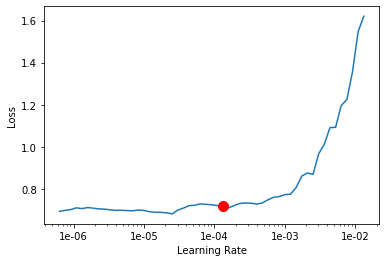

In [66]:
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.404633,0.334834,0.864560,0.135440,19:07
1,0.710428,0.696898,0.500000,0.500000,19:10
2,0.695162,0.696370,0.500000,0.500000,19:10
3,0.691192,0.695797,0.500000,0.500000,19:11
4,0.695383,0.693224,0.500000,0.500000,19:11


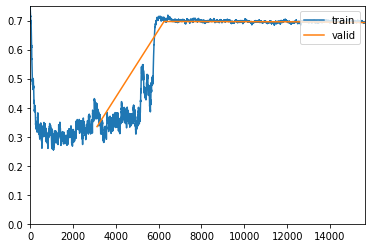

In [67]:
learner.fit_one_cycle(5, 1e-4, moms=(0.8,0.7))

In [51]:
learner.save('albert-no-pre-training-freezed')

In [40]:
# learner.load('no-pre-training-freezed');

## we only have 4 layer groups

In [52]:
len(learner.layer_groups)

4

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 2.29E-07


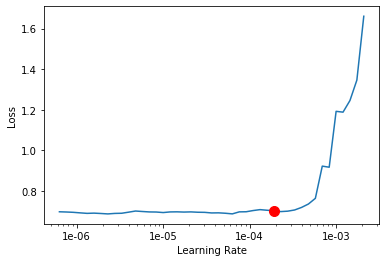

In [53]:
# since we have 14 layer_groups, we will unfreeze 2-3 layers to speed up the process
learner.freeze_to(-2)
torch.cuda.empty_cache()
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.188021,0.154190,0.942720,0.057280,11:49
1,0.149319,0.136903,0.949360,0.050640,11:14
2,0.119082,0.133555,0.951440,0.048560,11:13


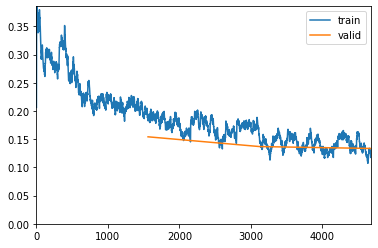

In [47]:
# ignore suggestion
learner.fit_one_cycle(3, 5e-5, moms=(0.8,0.7))

In [48]:
learner.save('no-pre-training-freez_to_-3')

In [ ]:
# learner.load('no-pre-training-freez_to_-3');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.31E-07


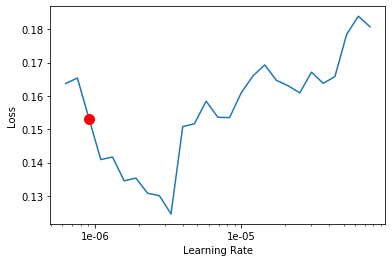

In [49]:
# since we have 14 layer_groups, we will unfreeze 2-3 layers to speed up the process
learner.freeze_to(-5)
torch.cuda.empty_cache()
learner.lr_find()
learner.recorder.plot(skip_end = 10, suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.127595,0.130388,0.952680,0.047320,11:48
1,0.127141,0.131005,0.953080,0.046920,12:39


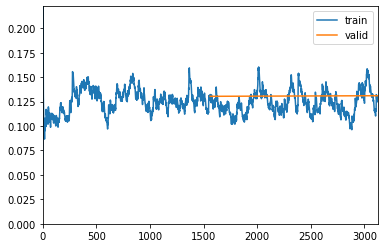

In [50]:
# ignore suggestion
learner.fit_one_cycle(2, 9.12E-07, moms=(0.8,0.7))

In [52]:
learner.save('no-pre-training-freez_to_-5')

In [38]:
learner.load('no-pre-training-freez_to_-5');

### We are able to get 95.3% accuracy without pre-finetuning

In the original guide of Jeremy Howard's ULMFiT for IMDB, he achieved **94.7%** accuracy. All the training strategies, like gradual unfreezing, learning rate annealing, batching are the same when constructing our `Learner`. Therefore, it's obvious that the `transformer` in stronger than `AWD_LSTM` for this task in terms of architecture.<br>

In the next notebook, we are going to push things further by incorporate the **ULMFiT** training procedure to the `transformer` training and see if we can get even better result.